# Differentially expressed genes

# Questions

### Questions:

- Are (all) X genes with a homolog on Y more often DEGs or is it only the ASF ones?
- Are there any autosomal DEGs, and do they interact with DEGs on X and Y?
- Are DEGs enriched among ASF genes or is it only those without admixture or with ILS or sweeps?
- Is there a significant correlation between DE, pachytene peak, seelction and ASF?

## Are DeltaE genes enriched for DE genes?

## Is X significantly depleted of pachytene peak expression, compared to other post-MSCI expression?

Do a k-means clustering of X and autosome genes based pseudo-time from pachytene and onwards

Test if proportions of each each cluster is significantly diffferent on X and autosomes

## .

# TODO:

- Try to plot all the SFARI genes, codemml, and spermatogenesis genes on the ideogram, along with low-ILS regions in both HCG and HOG
- codeml selected genes in each expression category and by mean expression at each stage. Are there more with late expression in spermatogenesis? And do these overlap SFARI or brain GTex genes?
- is there an overlap to genes in low-ILS regions?
- Try to plot nr SFARI genes against chrom length
- Try to make an ideogram to plot genes on
- Are there more genes on X than A with GO term including "neuron" or "brain". If so see which genes explain the enrichment.
- What is the overlap between expression in spermatogenesis and brain. Are there more genes with dual roles on X than A?
- Are there more SFARI genes in low-ILS regions?
- Among all brain expressed genes, do suceptibility genes have a characteristic expression profile through spermatogenesis?


- IL13RA1: Peak, *sperm. expression*
- EGFL6: sperm. expression
- OGT: 
- DYNLT3: Peak, *sperm. expression*
- PCDH11X: maybe associated with **AD and fragile X**, *sperm. expression*
- ZDHHC9: associated with **X-linked cognitive disability**., 
- HMGN5: 
- RAB41: 
- OFD1: *sperm. expression*
- EDA: *sperm. expression*
- GK: *sperm. expression*
- LAGE3: A form of Galloway-Mowat syndrome, a severe renal-neurological disease characterized by early-onset nephrotic syndrome associated with microcephaly, **central nervous system abnormalities**, developmental delays, and a propensity for seizures.
- ZNF41: may be associated with X-linked cognitive disability
- PDHA1: Leigh syndrome is a rare genetic **neurometabolic disorder**. It is characterized by the degeneration of the central nervous system (i.e., brain, spinal cord, and optic nerve).
- WWC3: A rare disorder of sex development affecting 46,XY individuals and characterized by **complete gonadal dysgenesis** (normal external female genitalia...
- BRCC3: This complex plays a role in the DNA damage response, where it is responsible for the stable accumulation of BRCA1 at DNA break sites
- BGN: ?

Cadhedrines under selection (checked if sperm. expressed):

- [x] PCDH11X, AD, fragile X
- [ ] PCDHA13
- [ ] PCDHA6
- [ ] PCDHA9 
- [x] PCDHB15 (strong expression in chimps and other primates, not humans), May be involved in the establishment and maintenance of specific neuronal connections in the brain.
- [ ] PCDHGA8
- [ ] PCDHGC3
- [x] PCDHGC5 May be involved in the establishment and maintenance of specific neuronal connections in the brain     
- [x] CDHR2 Intermicrovillar adhesion molecule that forms, via its extracellular domain, calcium-dependent heterophilic complexes with CDHR5 on adjacent microvilli.

# it seems there is a bug in geneinfo so you cannot use background_chrom unless you have already run an analysis withuot it

In [1]:
import anndata as ad
import scanpy as sc
import pandas as pd
import numpy as np
import random
import sys, os
from collections import defaultdict

#sys.path.append('.')

from sklearn.cluster import KMeans

import geneinfo as gi
gi.email('kaspermunch@birc.au.dk')

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# scale down size of default plots
sns.set_context("paper")
import matplotlib as mpl
scale = 0.8
d = dict([(k, v*scale) for (k, v) in sns.plotting_context('paper').items()])
d['figure.figsize'] = [5.4, 3.5]
mpl.rcParams.update(d)

# high-res plots
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina', 'png')

from matplotlib_venn import venn2, venn3

class left:
    def __rlshift__(self, df):
        "Left align columns of data frame: df << left()"
        left_aligned_df = df.style.set_properties(**{'text-align': 'left'})
        left_aligned_df = left_aligned_df.set_table_styles(
        [dict(selector = 'th', props=[('text-align', 'left')])])
        display(left_aligned_df)

from math import sqrt
from itertools import zip_longest

def list_genes(words, ncols=None):
    n = len(words)
    col_width = max(map(len, words)) + 3
    if ncols is None:
        ncols = min(200//col_width, 1+sqrt(n/col_width))
    nrows = int(n/ncols) + 1
    rows = []
    for r in range(0, n, nrows):
        rows.append(words[r:r+nrows])
    for row in list(zip_longest(*rows, fillvalue='')):
        line = []
        for gene in row:
            line.append(gene.ljust(col_width))
        print(''.join(line))
        
        
%env http_proxy=http://proxy-default:3128
%env https_proxy=http://proxy-default:3128        

env: http_proxy=http://proxy-default:3128
env: https_proxy=http://proxy-default:3128


# Gene sets from Google sheet

In [2]:
SHEET_ID = '1JSjSLuto3jqdEnnG7JqzeC_1pUZw76n7XueVAYrUOpk'
SHEET_NAME = 'Sheet1'
url = f'https://docs.google.com/spreadsheets/d/{SHEET_ID}/gviz/tq?tqx=out:csv&sheet={SHEET_NAME}'
df = pd.read_csv(url, header=1)
df.head()

all_npx neuron_genome_proteome neuron_npx_proteome  all_post_mei_expr  \
0    ABCB7                   A1BG               ABCB7                NaN   
1    ABCD1                   A1CF               ABCD1                NaN   
2     ACE2                    A2M               ACOT9                NaN   
3  ACE2-DT                   AAAS               ACSL4                NaN   
4    ACOT9                   AACS              ADGRG2                NaN   

   msci  msci_esc my_primate_codeml    cDEG                        nDEG  \
0   NaN       NaN             ABCD1    AFF2                        AFF2   
1   NaN       NaN              ACE2   CDKL5                      AKAP14   
2   NaN       NaN            AKAP14  DIAPH2                       ALG13   
3   NaN       NaN             AKAP4  EIF1AX  amplicon-chrX-BIG-FAMILY-B   
4   NaN       NaN           ARHGEF9    FHL1        amplicon-chrX-CPXCR1   

  primate_ampl_multi  ... Unnamed: 37 Unnamed: 38 Unnamed: 39 Unnamed: 40  \
0             ARMCX6  ...         NaN         NaN         NaN         NaN   
1             ATXN3L  ...         NaN         NaN         NaN         NaN   
2           C16ORF89  ...         NaN         NaN         NaN         NaN   
3             CENPVL  ...         NaN         NaN         NaN         NaN   
4               CSAG  ...         NaN         NaN         NaN         NaN   

  Unnamed: 41 Unnamed: 42 Unnamed: 43 Unnamed: 44 Unnamed: 45 Unnamed: 46  
0         NaN         NaN         NaN         NaN         NaN         NaN  
1         NaN         NaN         NaN         NaN         NaN         NaN  
2         NaN         NaN         NaN         NaN         NaN         NaN  
3         NaN         NaN         NaN         NaN         NaN         NaN  
4         NaN         NaN         NaN         NaN         NaN         NaN  

[5 rows x 47 columns]

In [3]:
def read_google_sheet():
    SHEET_ID = '1JSjSLuto3jqdEnnG7JqzeC_1pUZw76n7XueVAYrUOpk'
    SHEET_NAME = 'Sheet1'
    url = f'https://docs.google.com/spreadsheets/d/{SHEET_ID}/gviz/tq?tqx=out:csv&sheet={SHEET_NAME}'
    df = pd.read_csv(url, header=1)
    return df.loc[:, [not x.startswith('Unnamed') for x in df.columns]]
    
def gene_list_names():
    df = read_google_sheet()
    return sorted(df.columns.tolist())

def gene_list(name):
    df = read_google_sheet()
    sr = df[name]
    return sr[~sr.isnull()]
    
gene_list_names()

['accel_reg_simiiformes_br',
 'all_npx',
 'all_post_mei_expr',
 'cDEG',
 'candidates',
 'ech75_regions',
 'expr_mod_xi_copynr_fibrobl',
 'expr_mod_xi_copynr_lcl',
 'gametologs',
 'intelect_disabil',
 'msci',
 'msci_esc',
 'my_primate_codeml',
 'nDEG',
 'neuron_genome_proteome',
 'neuron_npx_proteome',
 'primate_ampl_multi',
 'reg_sa_pheno',
 'sfari_all_conf',
 'xi',
 'xi_any_evidence',
 'xi_escape',
 'xi_uncertain']

List of X genes differentially expressed in whole cells:

In [4]:
genes_whole_cell_de_x = gene_list('cDEG')

In [5]:
list_genes(gene_list('primate_ampl_multi'))

ARMCX6     FAM47A     PABPC      XAGE1A     
ATXN3L     FAM47B     PAGE       XAGE1B     
C16ORF89   FAM9A      PNMA       XAGE2      
CENPVL     FAM9B      PWWP3B     XAGE3      
CSAG       GAGE       RHOXF2     XAGE5      
CT45A      H2AB       RPL10      ZNF        
CT47       H2BW       SAGE1                 
CT55       HMGB       SCML1                 
CT83       HSFX1      SPANXN                
CTAG       HSFX2      SPIN                  
CXORF49    HSFX3      SSX                   
CXORF51B   HSFX4      TCP11X                
DDX53      IKBKG      TEX28                 
DMRTC1     LAGE3      TMEM185A              
EOLA1      MAGEA      TMLHE                 
F8A        MAGEB      TMSB15B               
FAM156A    MAGED      TRMT2B                
FAM156B    NXF        USP27X                
FAM236     OPN1       VCX                   


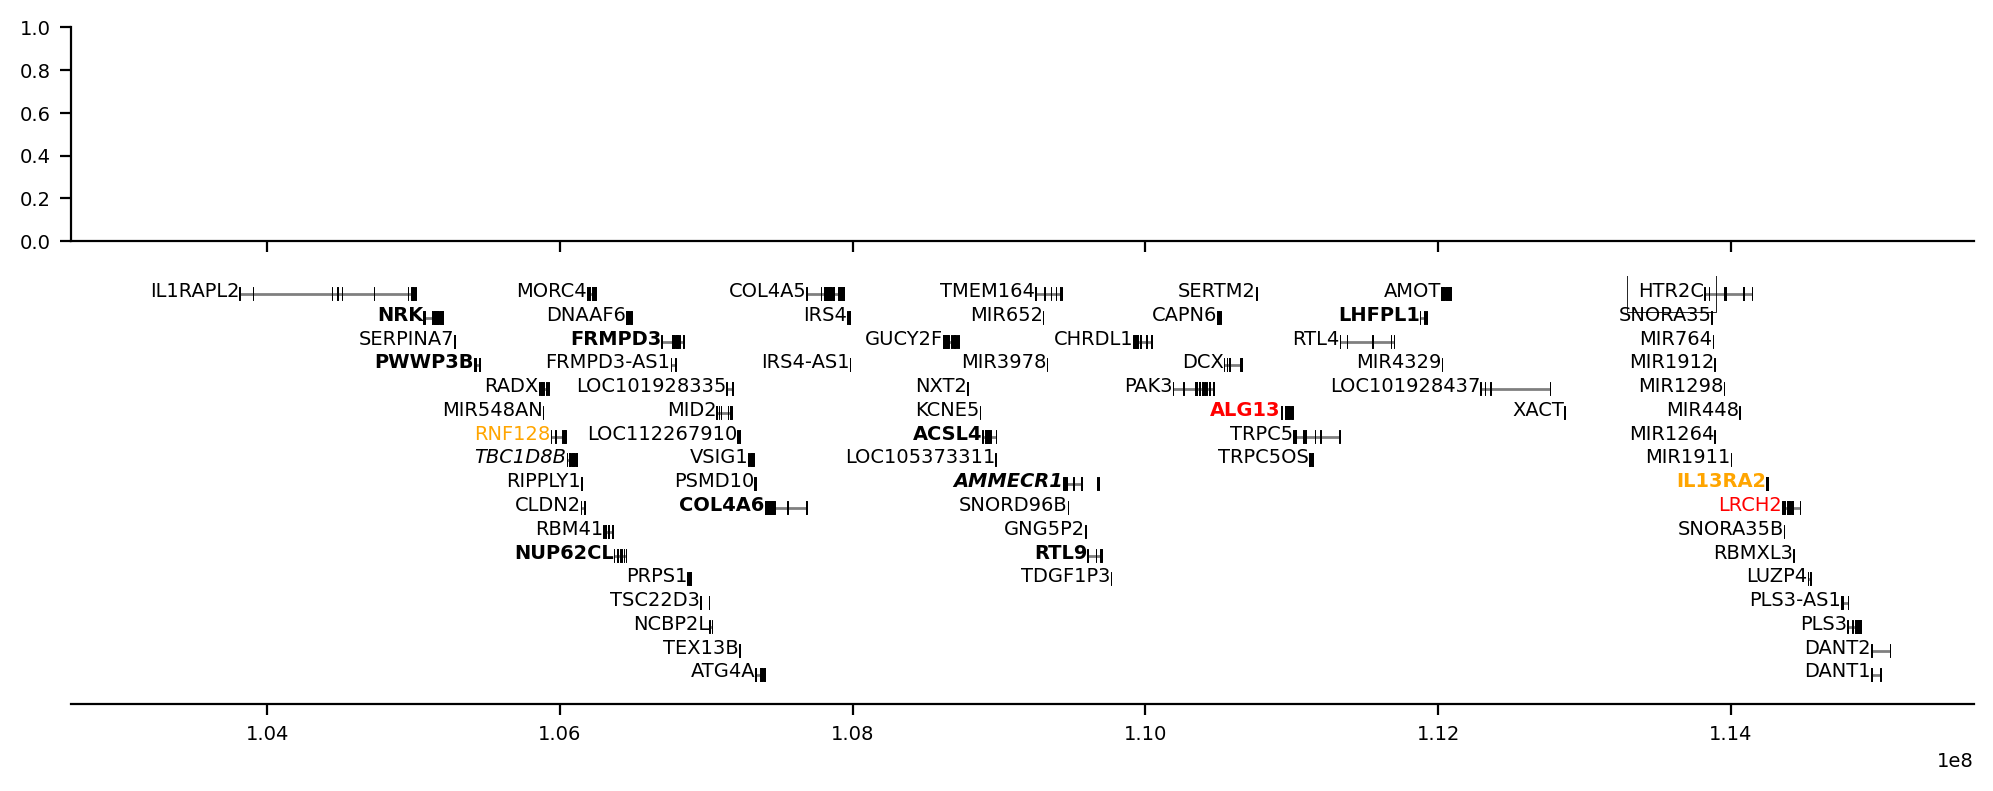

In [6]:
highlight = defaultdict(dict)
for gene in gene_list('xi_escape'):
    highlight[gene].update(dict(color='red'))
for gene in gene_list('xi_uncertain'):
    highlight[gene].update(dict(color='orange'))
    
for gene in gene_list('expr_mod_xi_copynr_fibrobl'):
    highlight[gene].update(dict(style='italic'))
for gene in gene_list('expr_mod_xi_copynr_lcl'):
    highlight[gene].update(dict(style='italic'))   

for gene in gene_list('my_primate_codeml'):
    highlight[gene].update(dict(weight='bold'))     
for gene in gene_list('accel_reg_simiiformes_br'):
    highlight[gene].update(dict(weight='bold'))  
    
for gene in gene_list('cDEG'):
    highlight[gene].update(dict(bbox={'edgecolor':'black','facecolor': "None", 'linewidth':0.3}))
# for gene in gene_list('nDEG'):
#     highlight[gene].update(dict(bbox={'edgecolor':'black','facecolor': "None", 'linewidth':0.3}))

ax = gi.gene_plot('chrX', 105000000, 115000000, assembly='hg19', 
                  figsize=(10, 4), highlight=highlight, aspect=2)
sns.despine(ax=ax)
plt.tight_layout()

In [7]:
# import importlib
# import expression_plots
# importlib.reload(expression_plots)
# expression_plots.load_data("../data/adata_susbet_kasper.h5ad")
# #expression_plots.x_ratio_trajectory(genes_whole_cell_de_x) ;

# #expression_plots.x_ratio_trajectory(['CHIC1']) ;
# expression_plots.x_ratio_trajectory(['AFF2']) ;


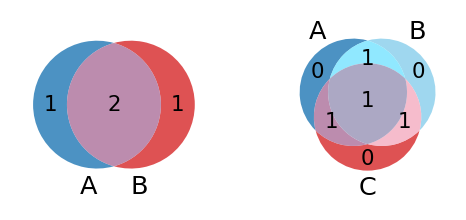

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(3,1))
g = venn2([set([1, 2, 3]),  set([2, 3, 4])], 
          set_labels = ('A', 'B'),
          alpha = 0.8, 
          set_colors=('tab:blue', 'tab:red'),
          ax=ax1
         )
g = venn3([set([1, 2, 3]),  set([2, 3, 4]), set([3, 4, 1])], 
          set_labels = ('A', 'B', 'C'),
          alpha = 0.8, 
          set_colors=('tab:blue', 'skyblue', 'tab:red'),
          ax=ax2     
         )

# from scipy import stats
# stats.binom_test(5, n=15, p=0.01, alternative='greater')

# Functions for plotting gene expression

In [9]:
import expression_plots as ep
import importlib
importlib.reload(ep)
ep.load_data("../data/adata_susbet_kasper.h5ad")

In [10]:
candidate_short_list =[
    'DYNLT3',
'BCLAF3',
'IL13RA2',
'CFAP47',
'EIF1AX',
'PHF8',
'CHIC1',
'LRCH2',
'PGK1',
'ATRX',
'ZCCHC13',
'LAS1L',
'ALG13']

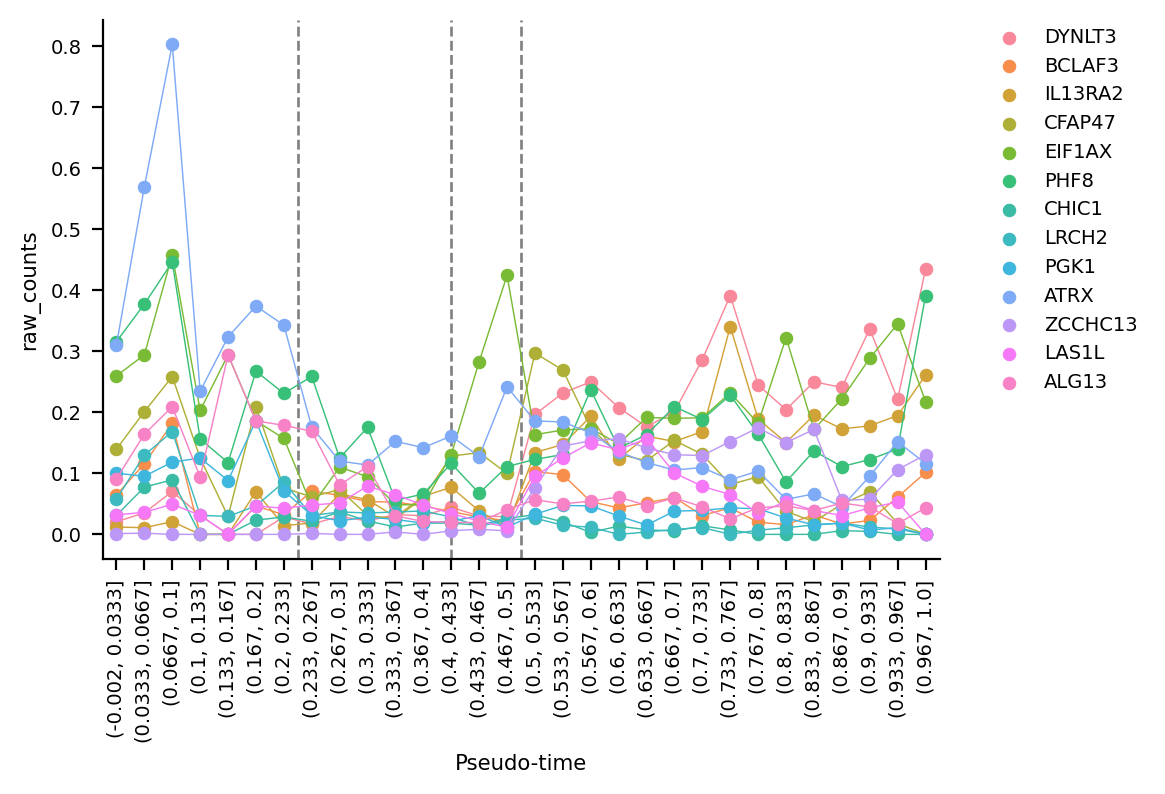

In [11]:
ep.trajectory(candidate_short_list, 'raw_counts') ;

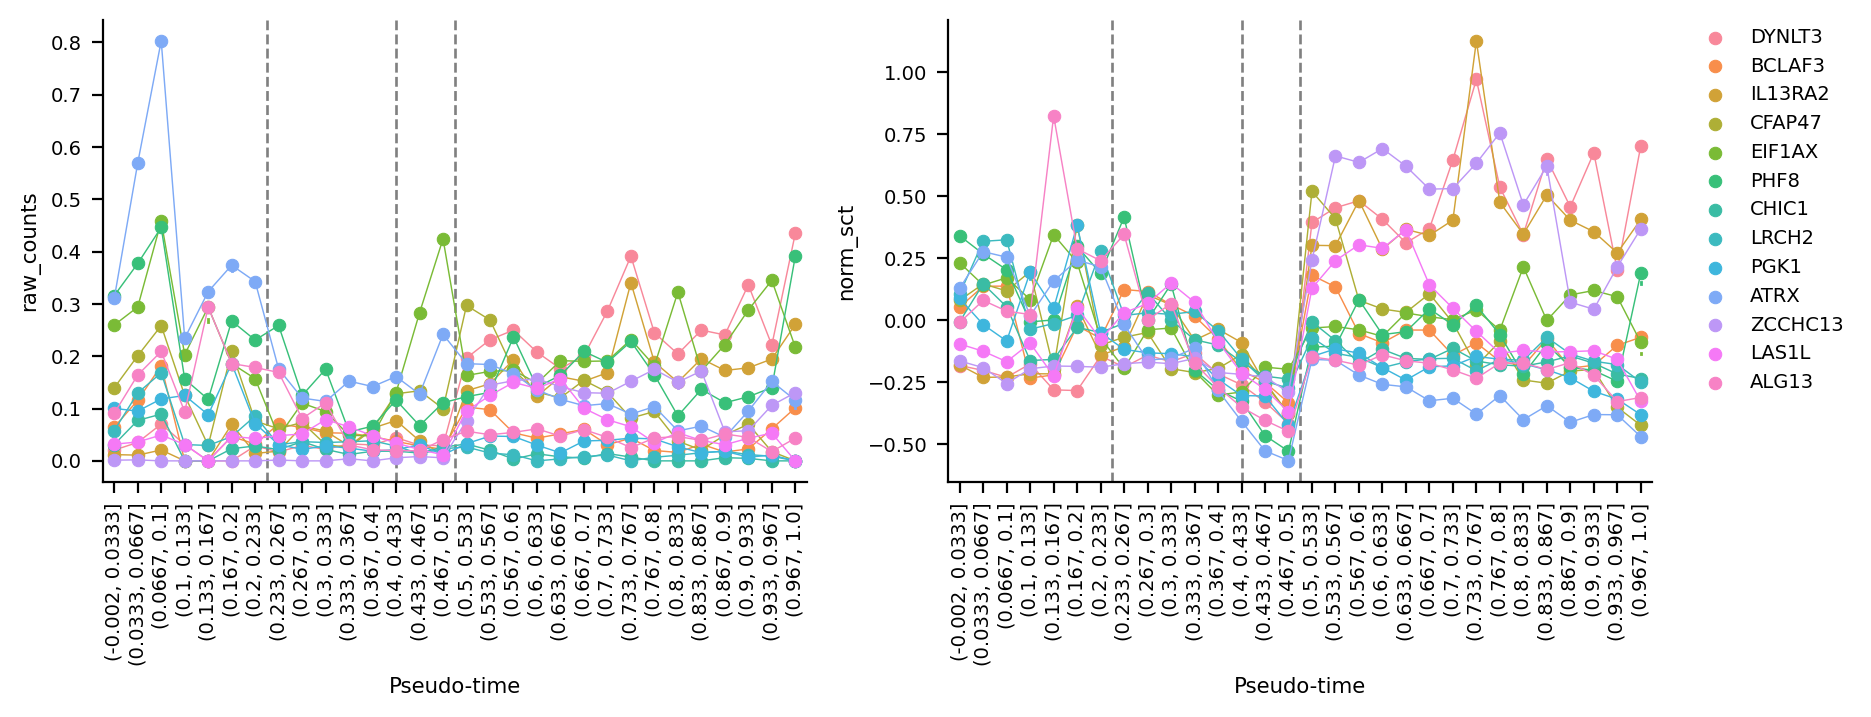

In [12]:
ep.trajectory(candidate_short_list) ;

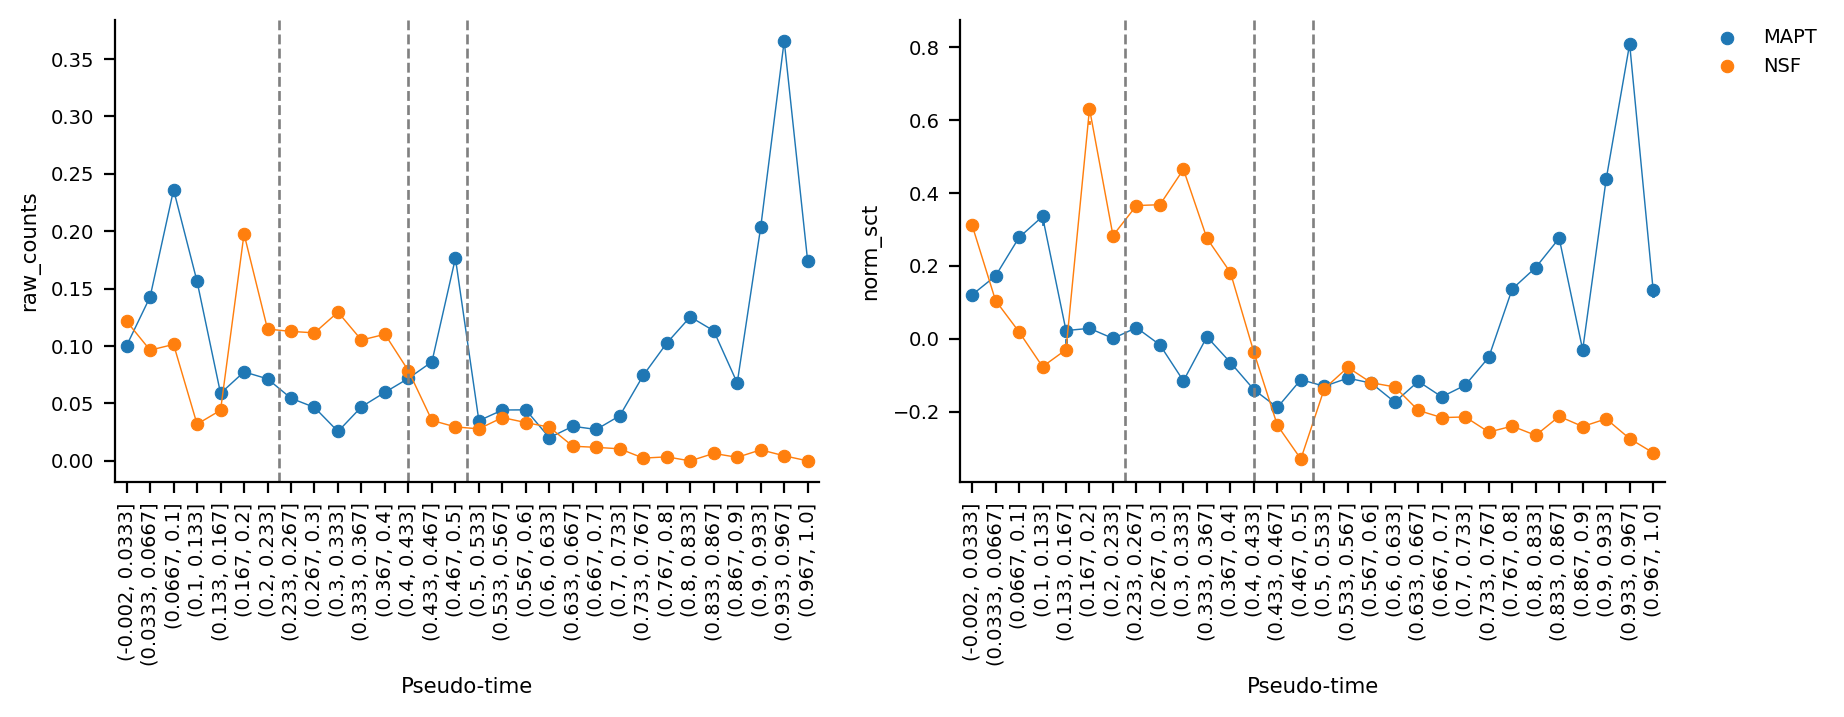

In [39]:
ep.trajectory(['MAPT', 'NSF']) ;

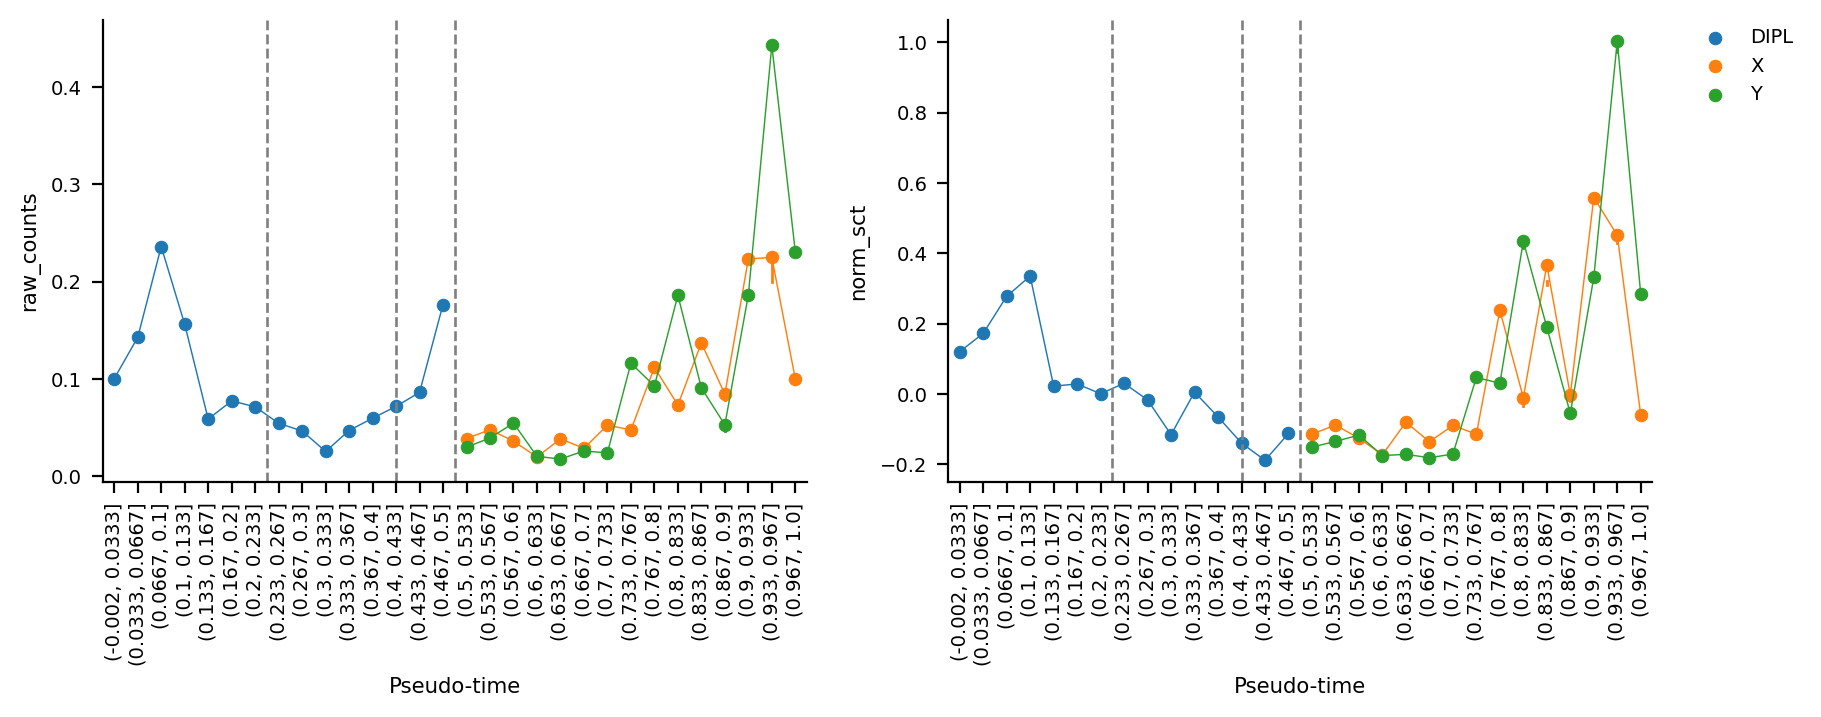

In [40]:
ep.split_trajectory('MAPT') ;

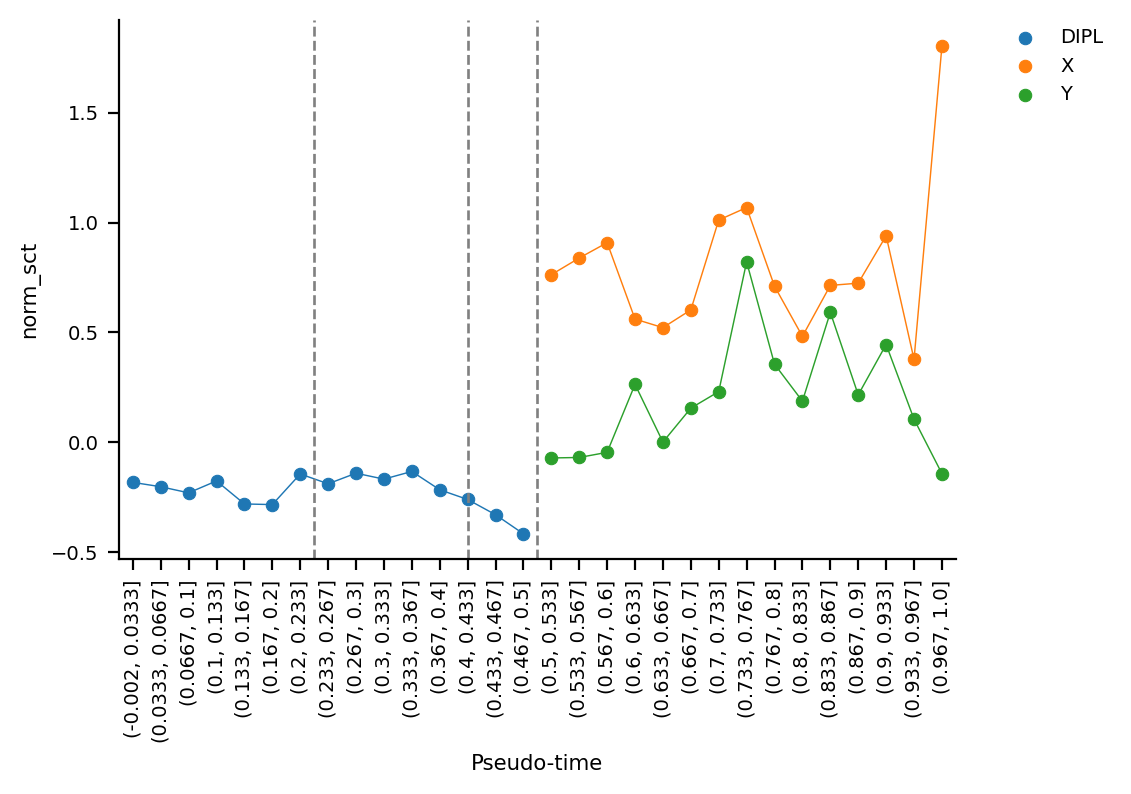

In [13]:
ep.split_trajectory('DYNLT3', 'norm_sct') ;

In [14]:
# def facet_plot(genes, plot_fun, *args, **kwargs):
#     nr_genes = len(candidate_short_list)
#     nr_rows = nr_genes // 3 + int(nr_genes % 3)
#     fig, axes = plt.subplots(nr_rows, 3, figsize=(10, 10), sharex=True)
#     axes_flat = axes.flatten()
#     for gene, ax in zip(candidate_short_list, axes_flat):
#         plot_fun(gene, *args, **kwargs, ax=ax, )
#         ax.set_title(gene, loc='right')
#         ax.get_legend().remove()
#     if plot_fun == ep.split_trajectory:
#         handles, labels = ax.get_legend_handles_labels()
#     fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1, 0.5), frameon=False)        
#     for ax in axes_flat[nr_genes:]:
#         ax.remove()
#     plt.tight_layout()

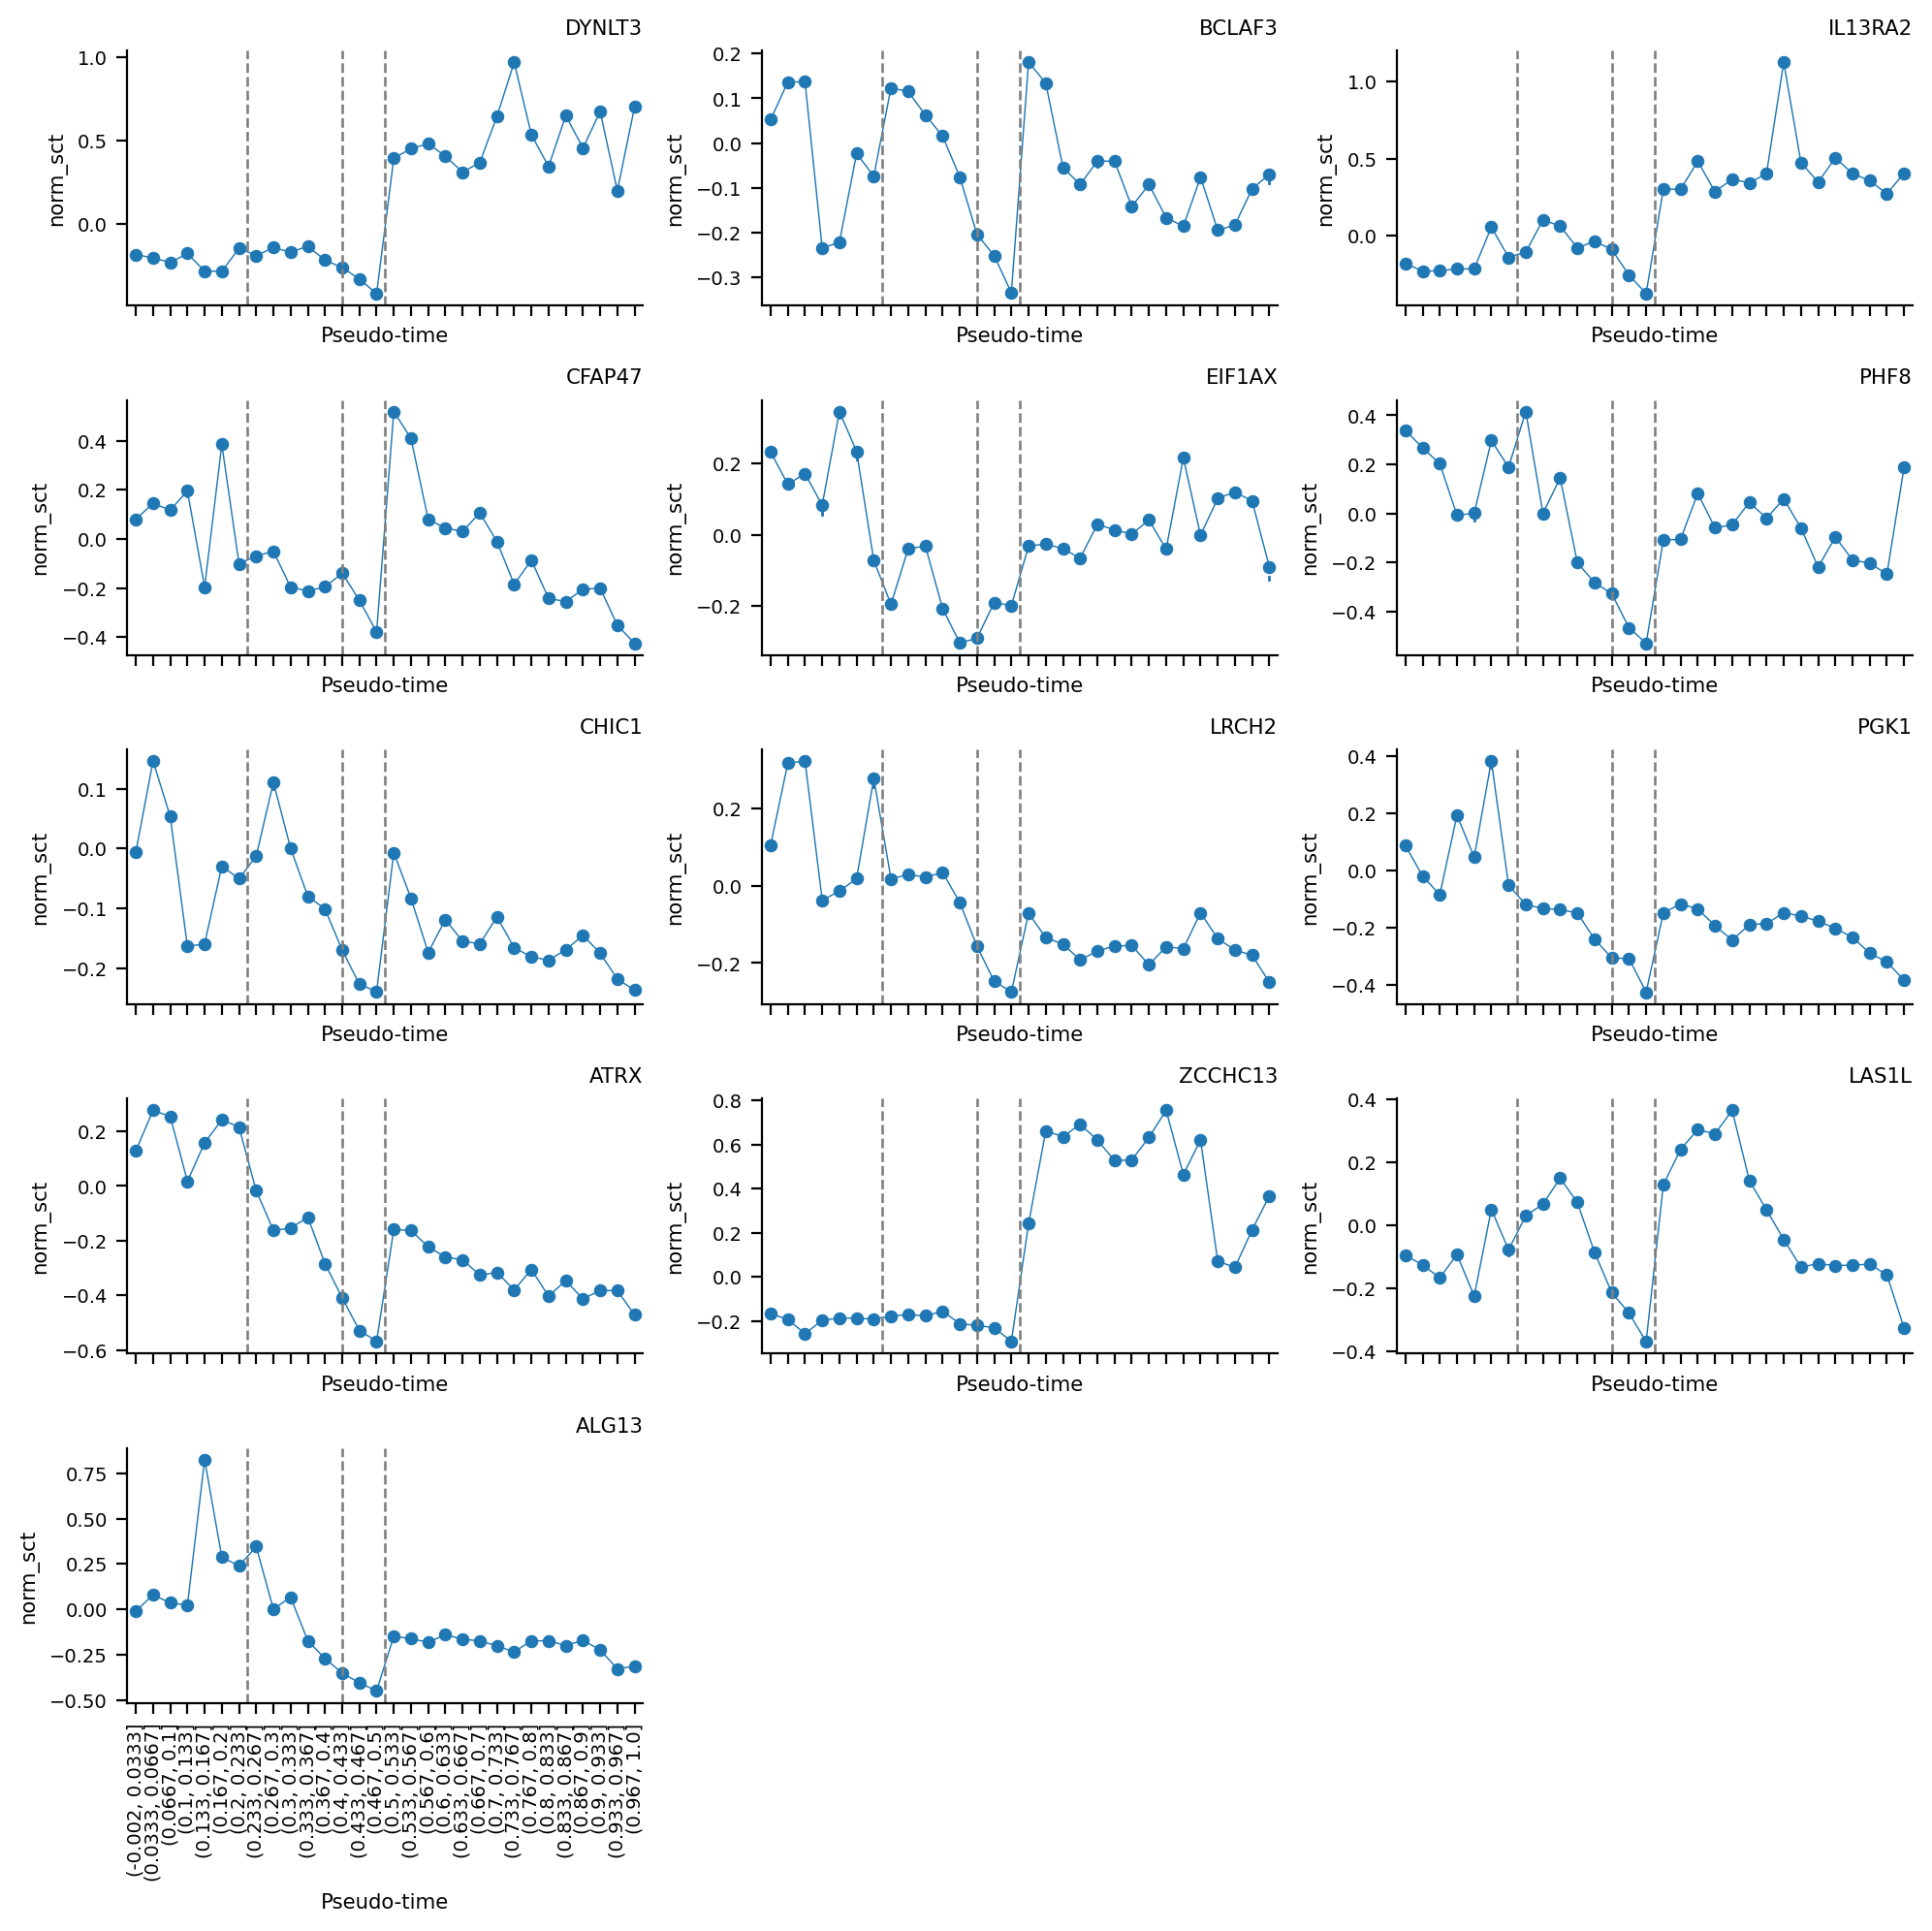

In [15]:
ep.facet_plot(candidate_short_list, ep.trajectory, 'norm_sct')

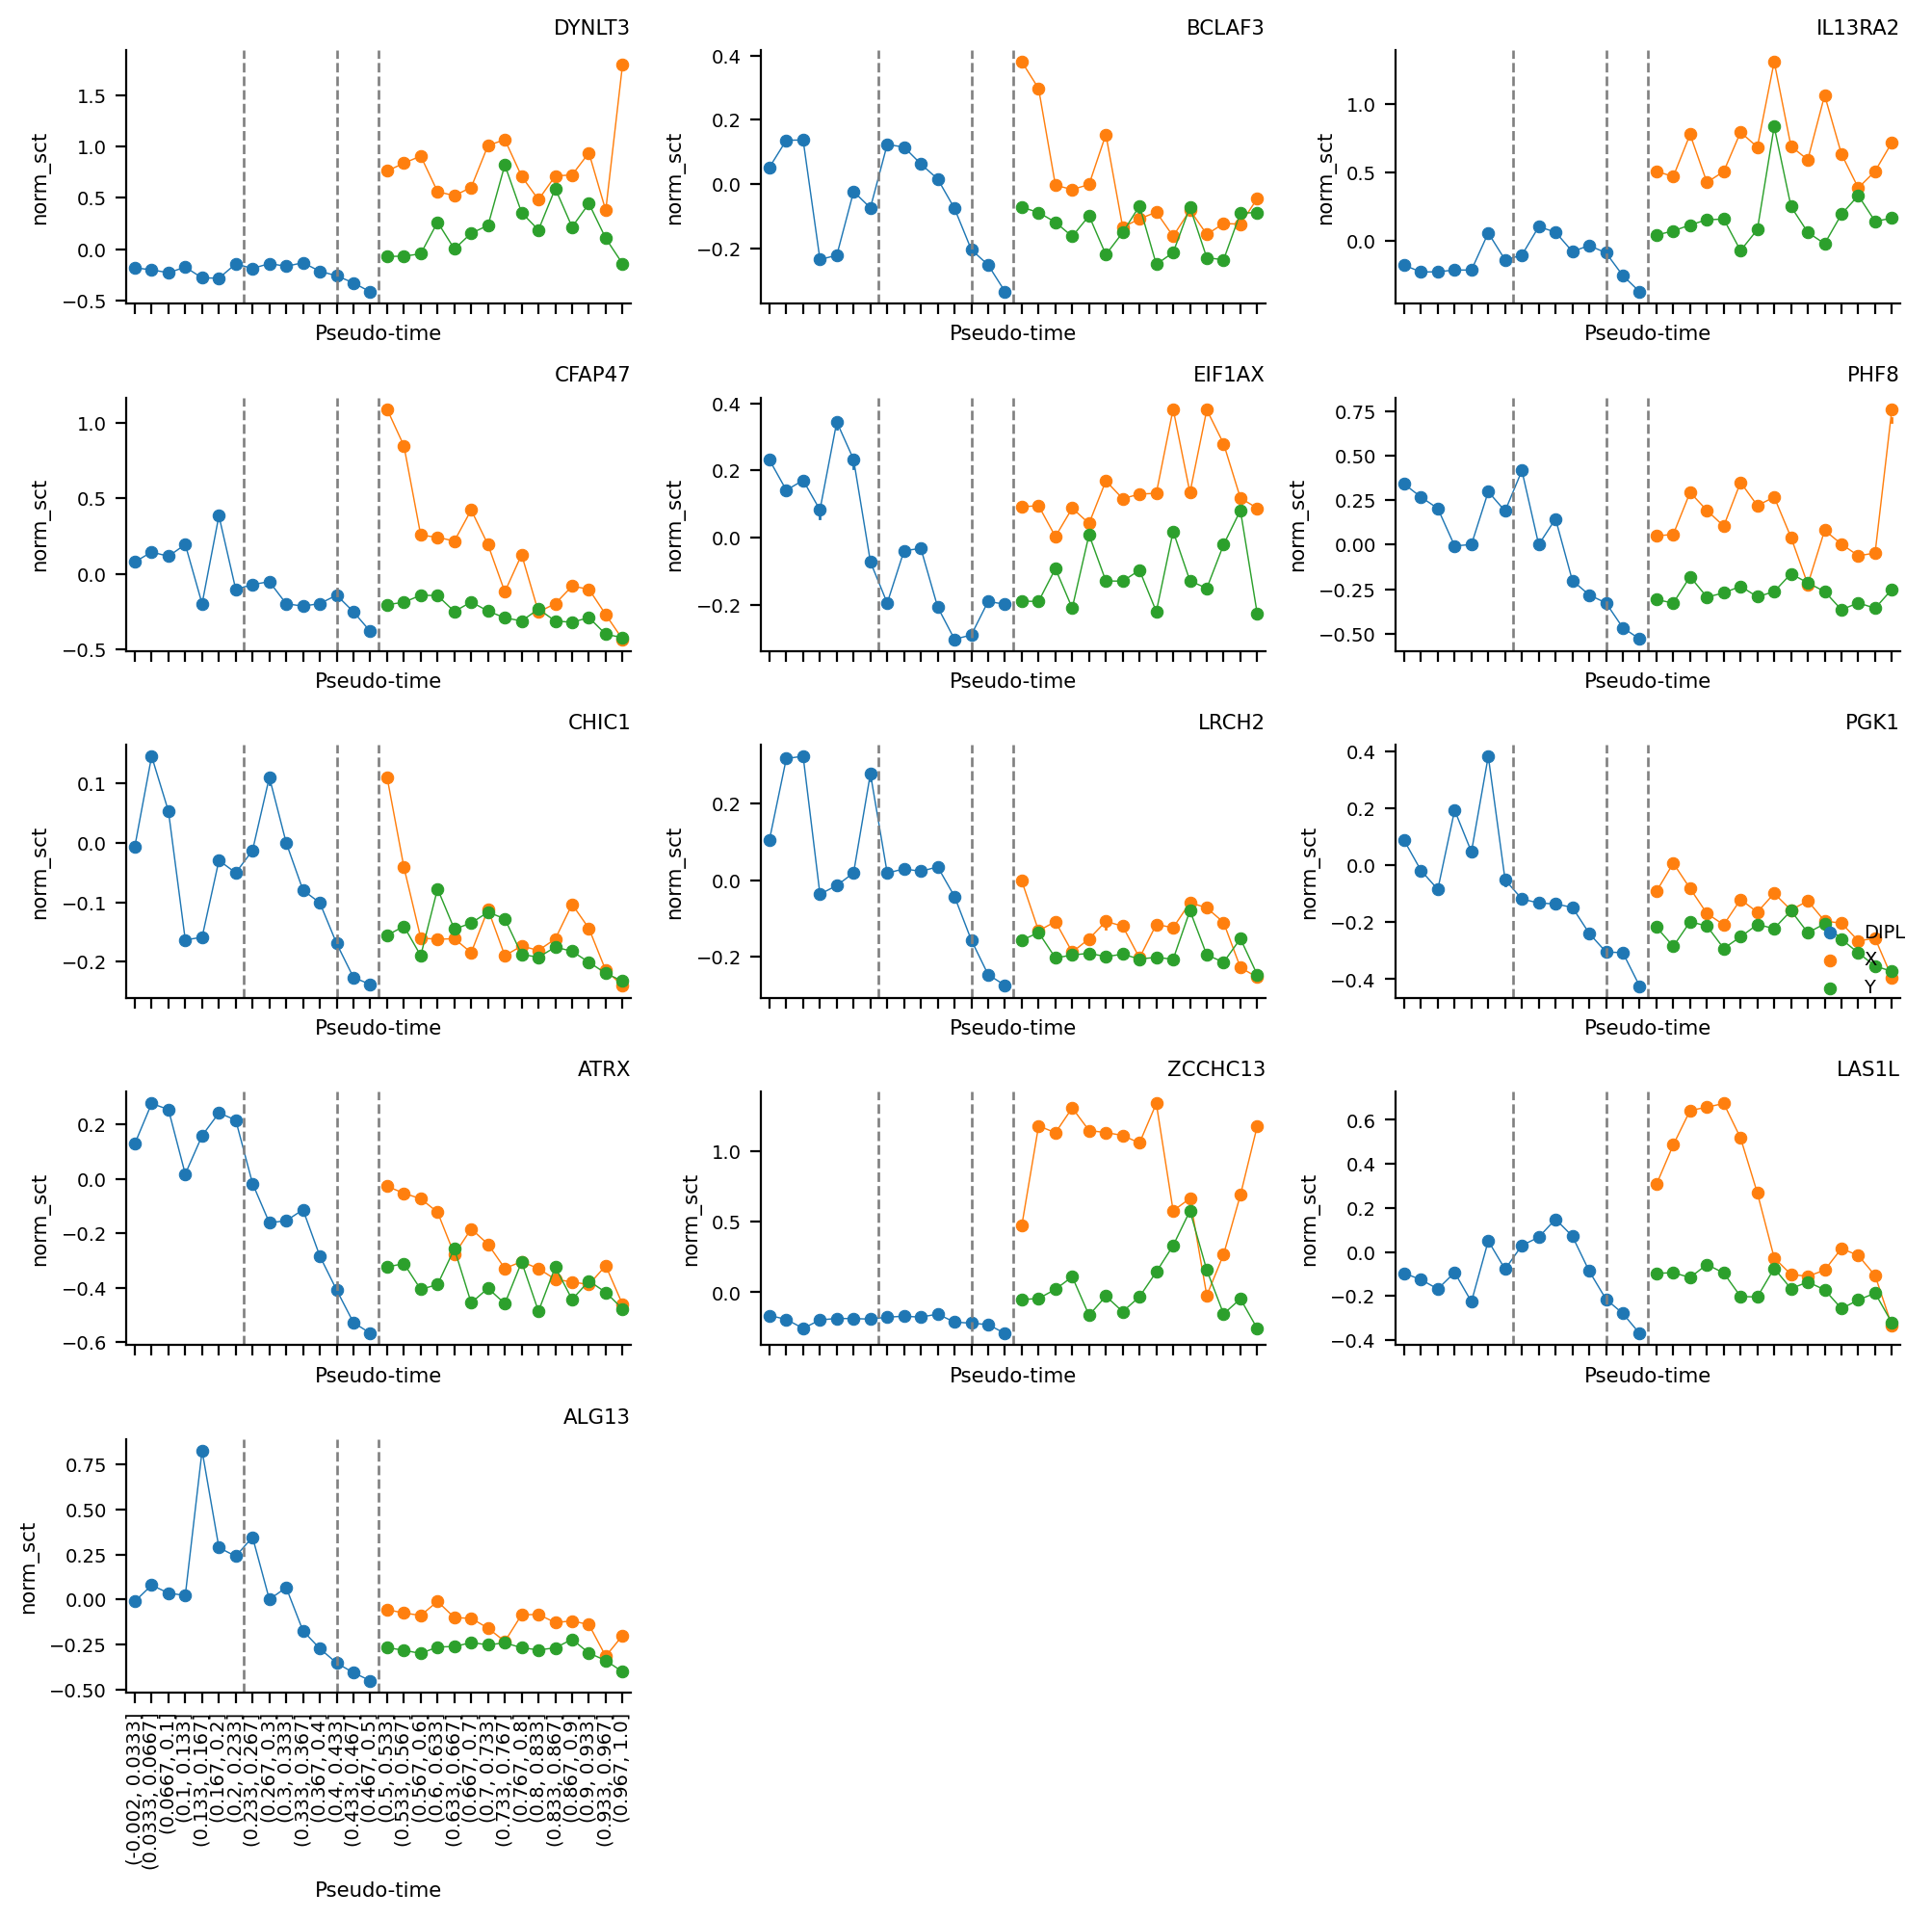

In [16]:
ep.facet_plot(candidate_short_list, ep.split_trajectory, 'norm_sct')

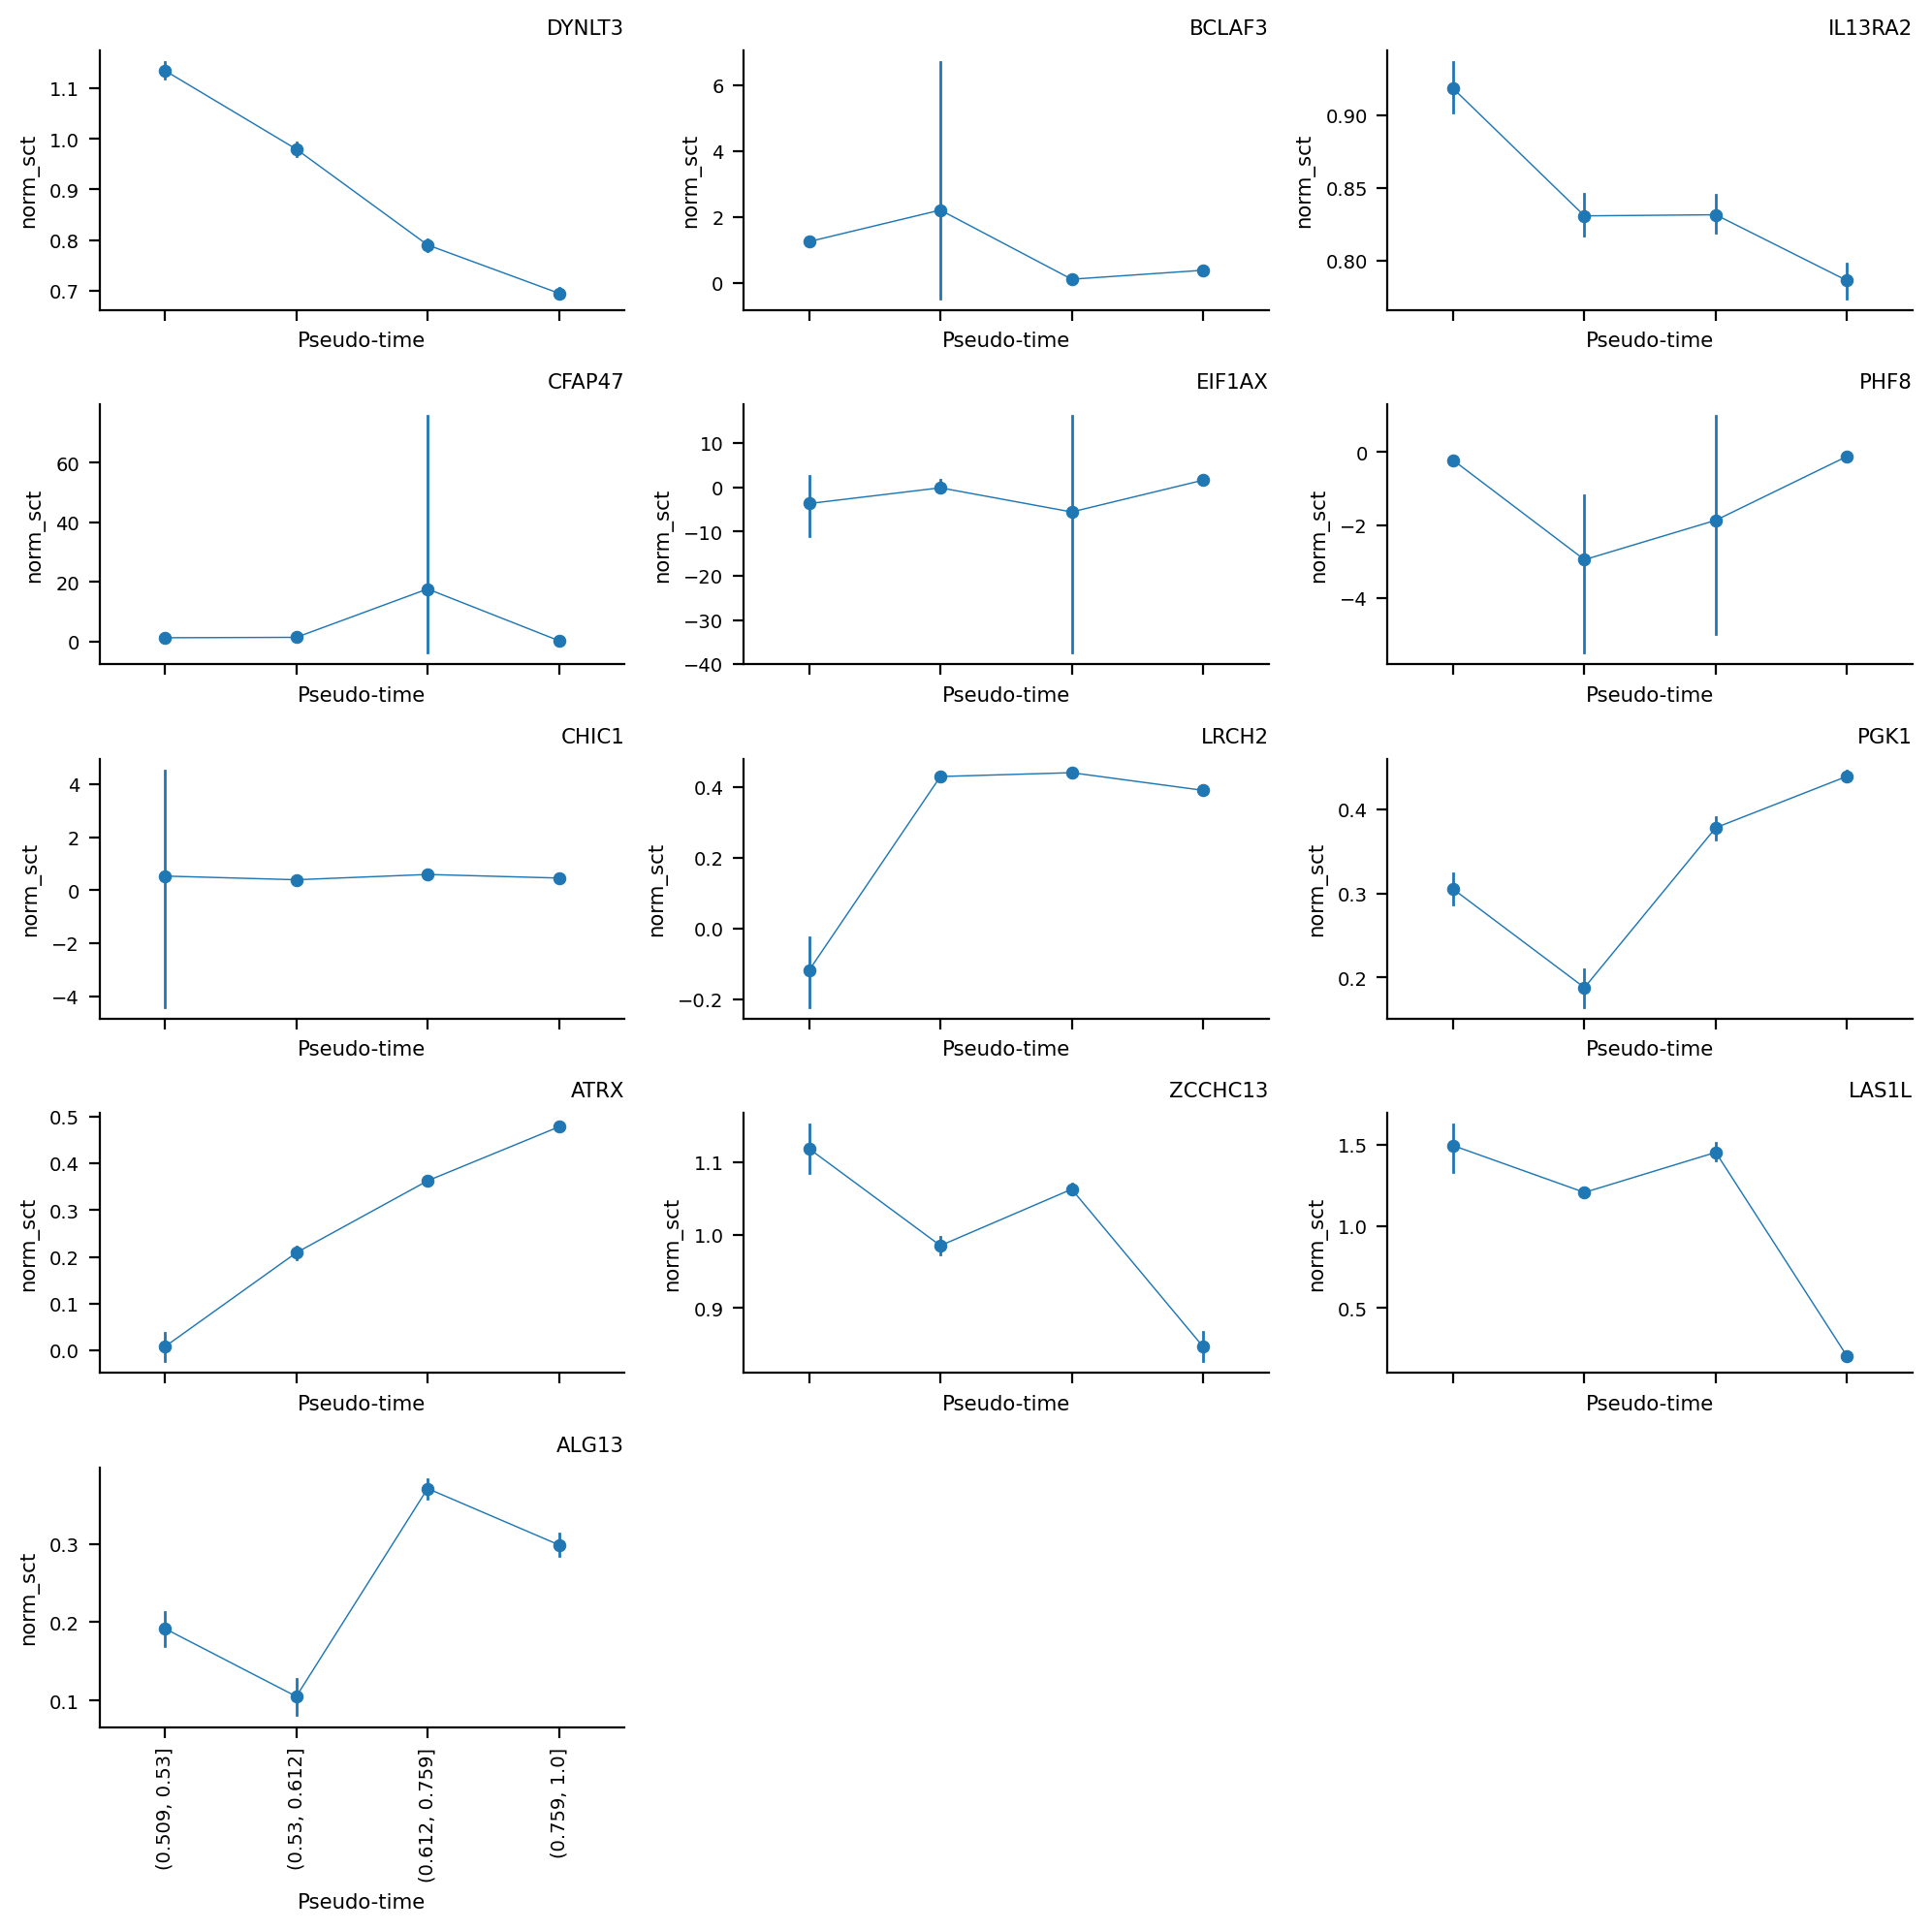

In [17]:
ep.facet_plot(candidate_short_list, ep.x_ratio_trajectory, 'norm_sct')

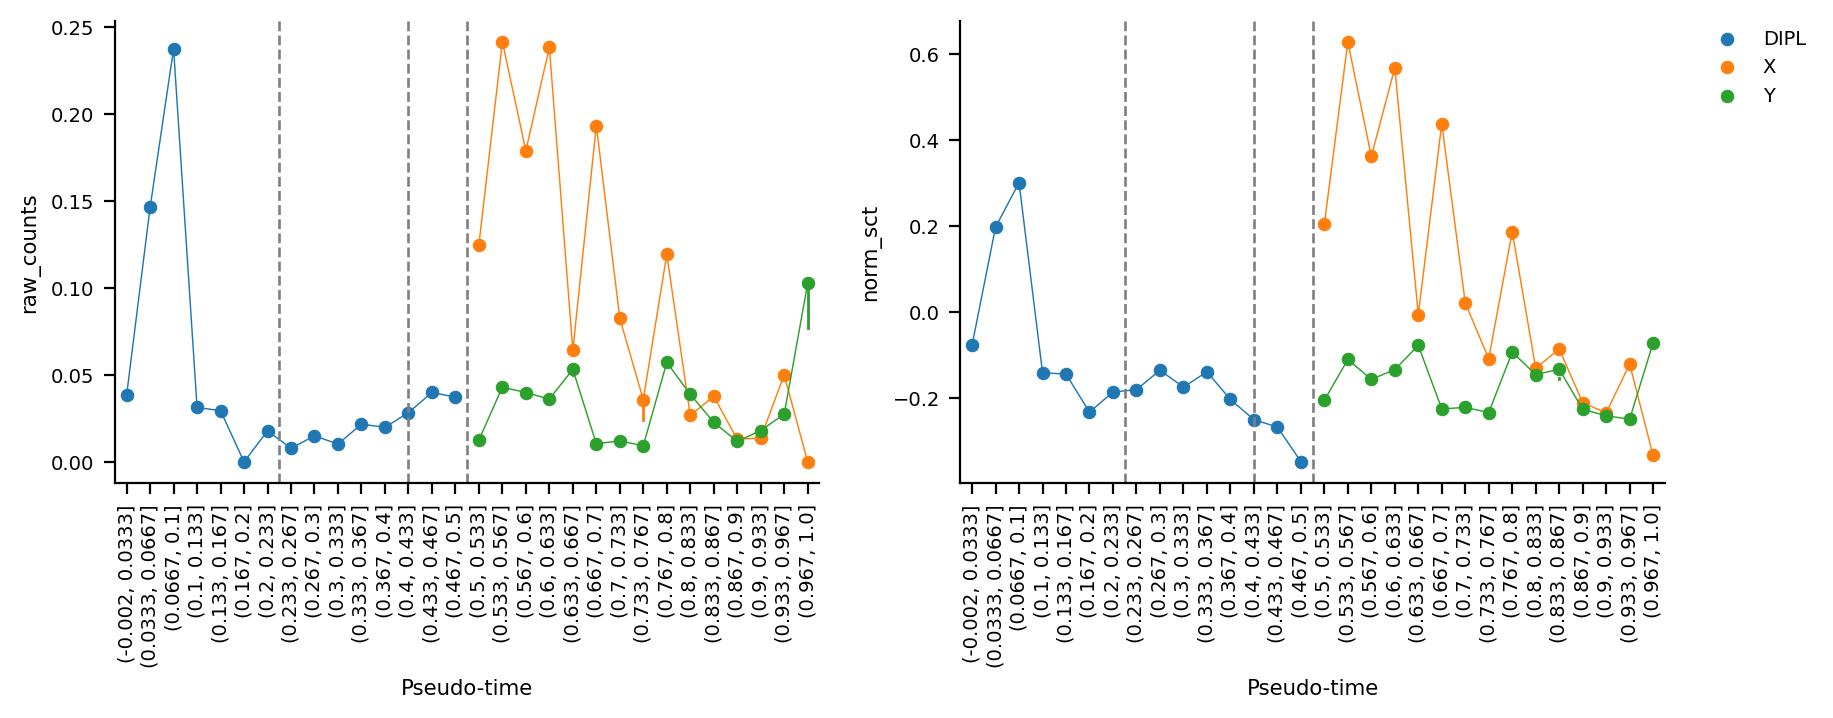

In [18]:
ep.split_trajectory('AFF2') ;

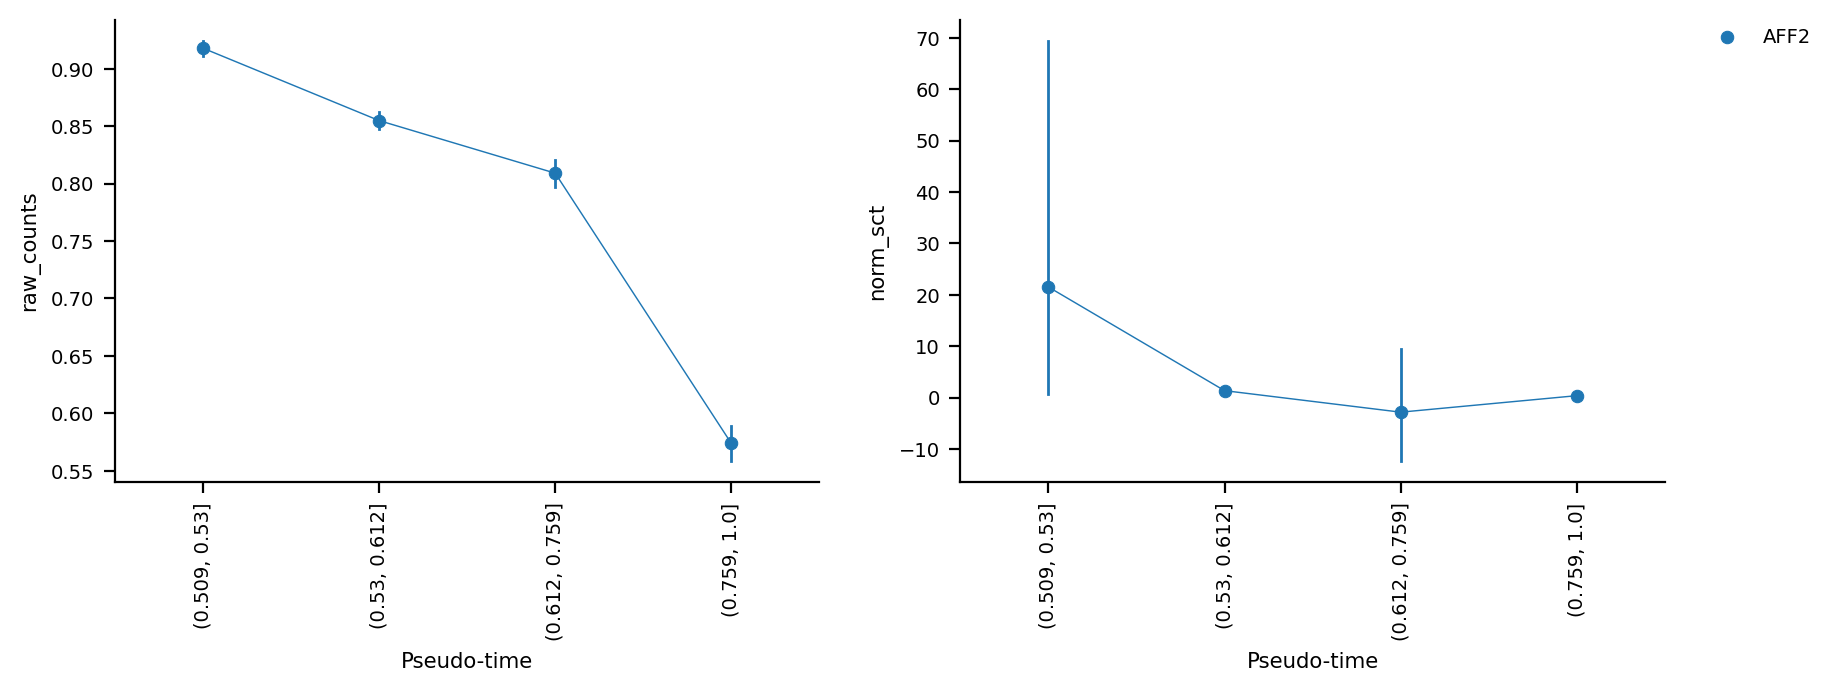

In [19]:
#expression_plots.x_ratio_trajectory(['CHIC1']) ;
ep.x_ratio_trajectory(['AFF2']) ;

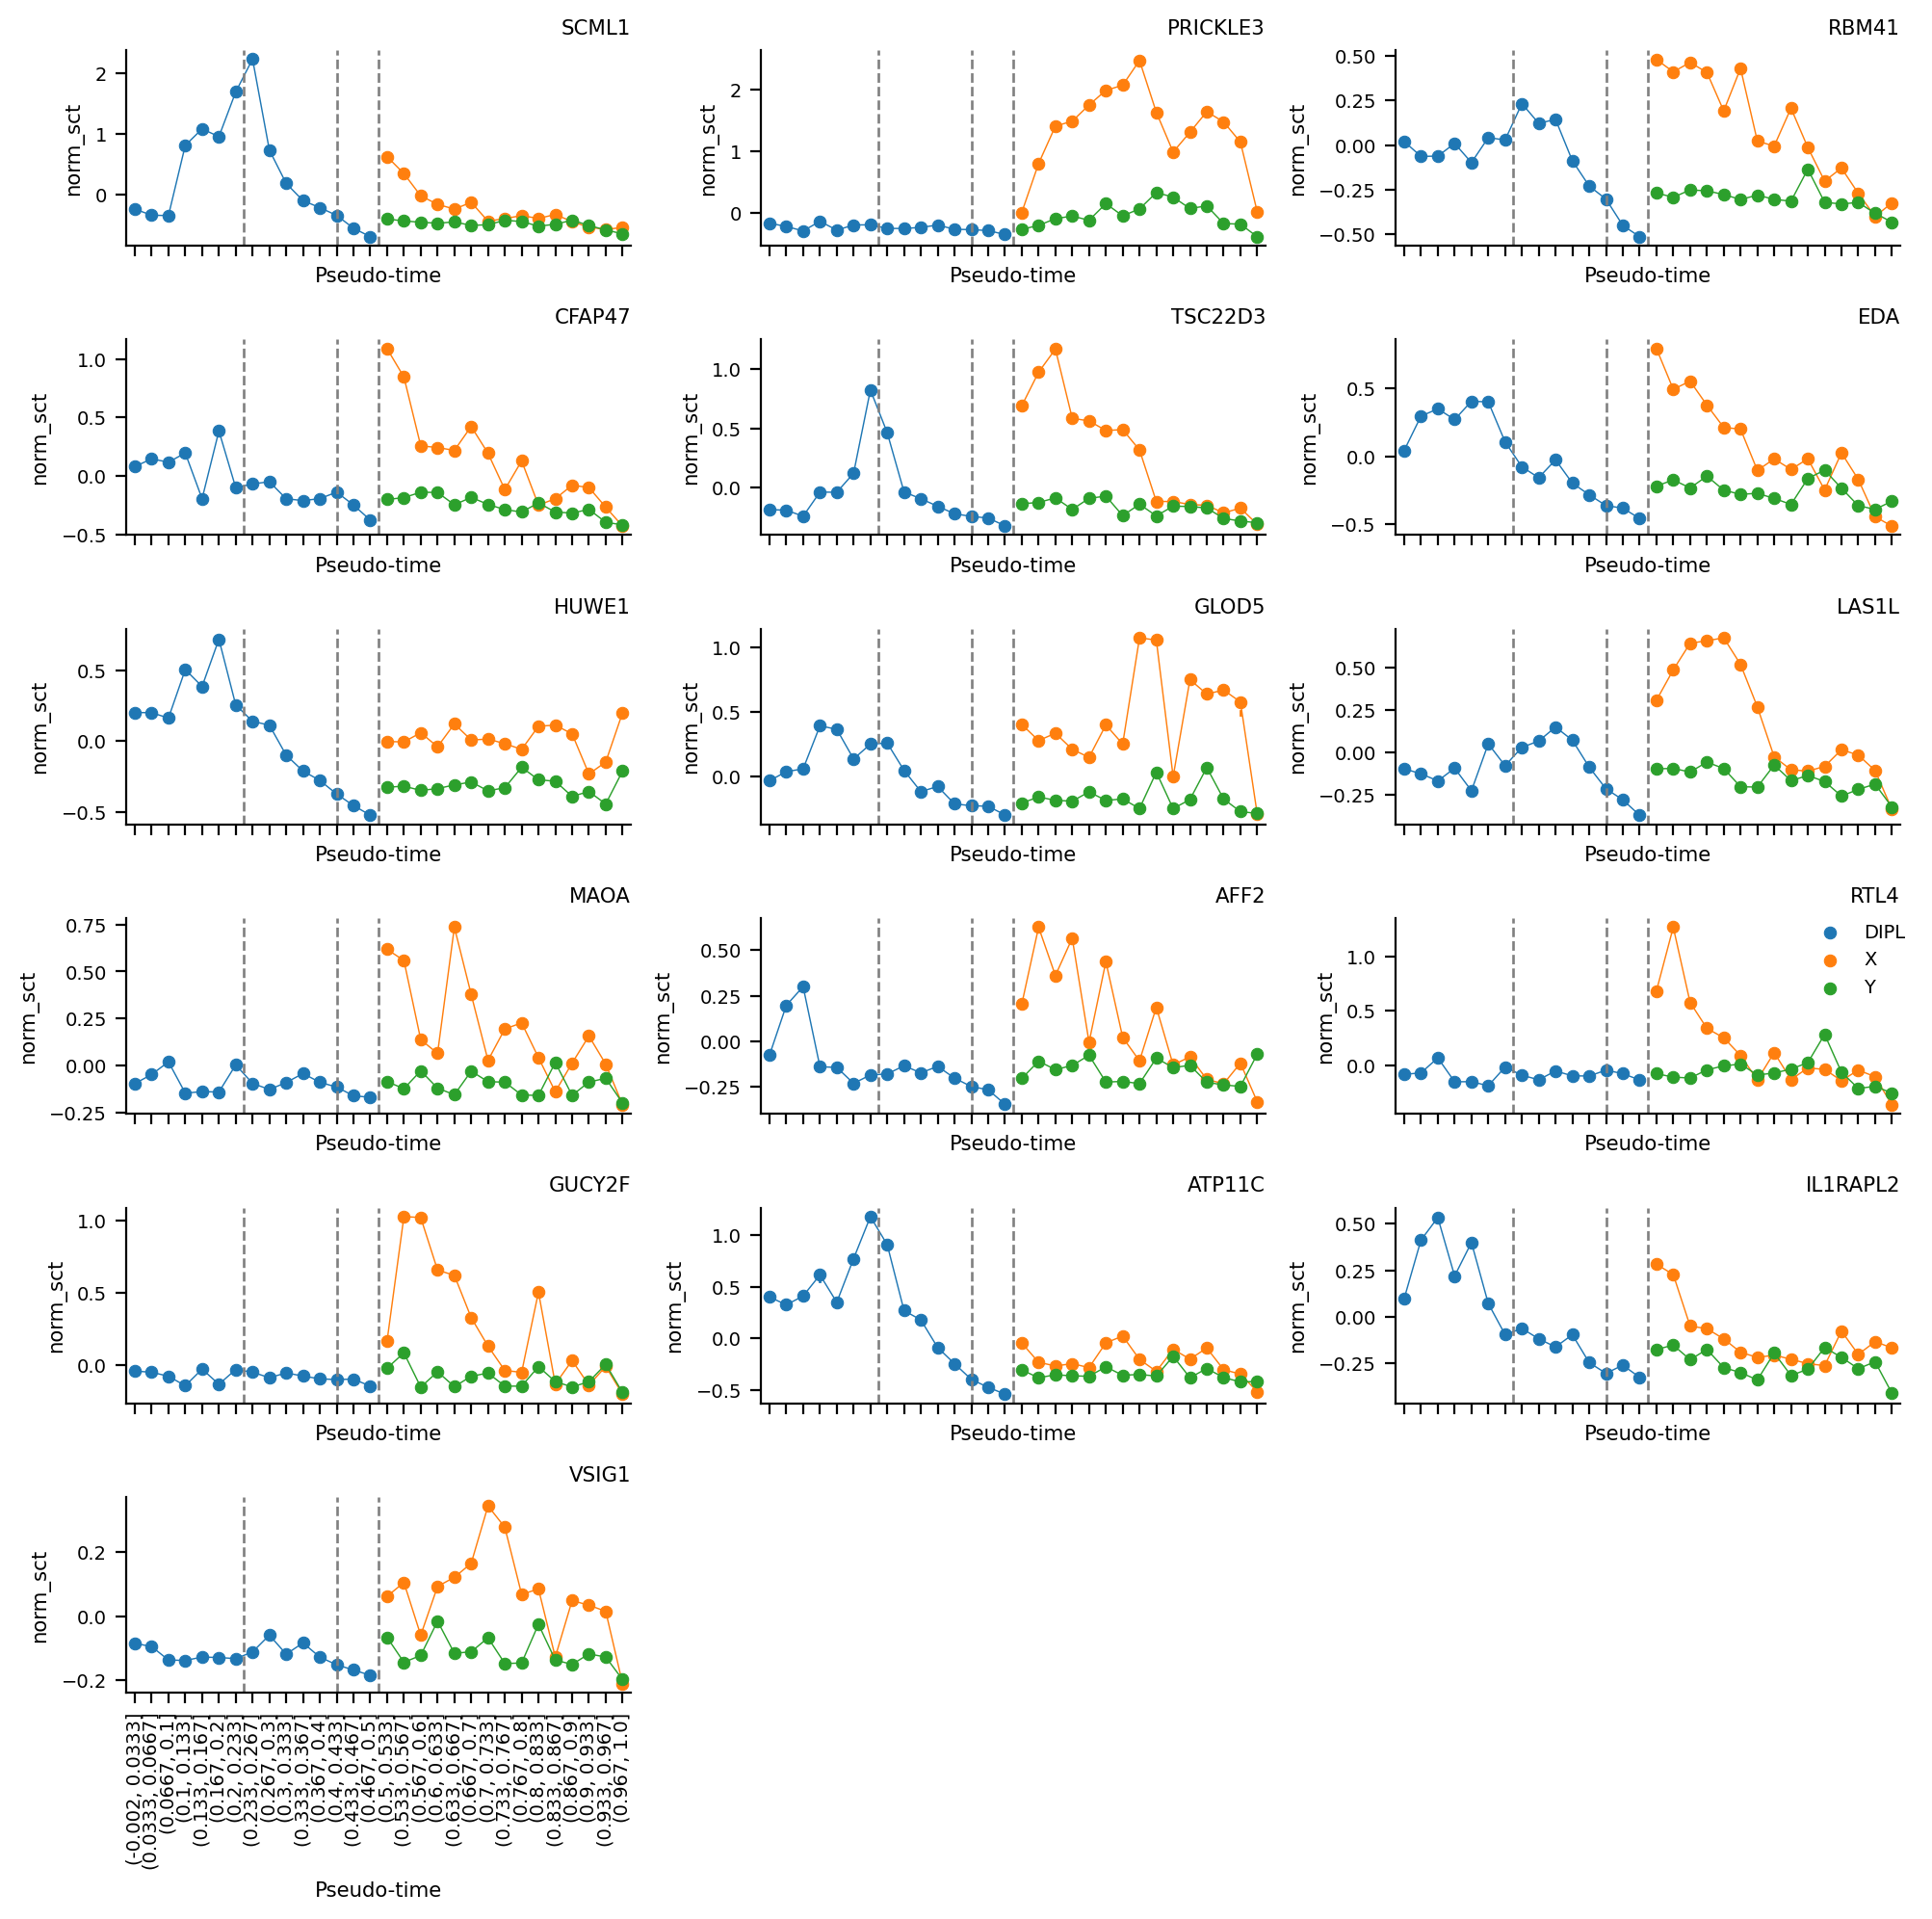

In [20]:
ncDEG = ['SCML1',
'PRICKLE3',
'RBM41',
'CFAP47',
'TSC22D3',
'EDA',
'HUWE1',
'GLOD5',
'LAS1L',
'MAOA',
'AFF2',
'RTL4',
'GUCY2F',
'ATP11C',
'IL1RAPL2',
'VSIG1']
ep.facet_plot(ncDEG, ep.split_trajectory, 'norm_sct')

In [21]:
# def cat_plot(genes, layer, markersize=20, ci=95, ax=None):
#     # layer is 'norm_sct' or 'raw_counts'
#     axes = ax
#     clusters = ['Spermatogonia', 'Leptotene/Zygotene', 'Pachytene', 'Spermatids']    
#     try:
#         df = adata.to_df(layer=layer)
#     except NameError:
#         print('''The function needs access to a global varaible "adata" with Meritxell's expression data''')
#         return
#     df['cluster'] = adata.obs.cluster
#     df.set_index('cluster', inplace=True)
#     df.columns.name = 'gene'
#     genes = pd.Series(genes)
#     has_data = genes.isin(df.columns)
#     missing = genes[~has_data]
#     if missing.size:
#         print("missing:", missing.tolist())
#     genes = genes[has_data]
#     plot_df = df.loc[:, genes].stack().to_frame('expression').reset_index()
#     if len(plot_df.index):    
#         # plt.figure(figsize=(10,5))
#         # ax = sns.pointplot(data=plot_df, x='clst', y='exp', hue='gene', order=['SPG', 'SPC', 'SPT'])#, ci=ci, errwidth=1, scale=0.3)
#         ax = sns.pointplot(data=plot_df, x='cluster', y='expression', hue='gene', order=clusters, ax=axes)#, ci=ci, errwidth=1, scale=0.3)
#         plt.setp(ax.collections, sizes=[markersize])
#         ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
#         ax.set_ylabel(layer)
#         ax.set_xlabel('Pseudo-time')
#         if axes is None:
#             plt.legend(bbox_to_anchor=(1.05, 1), loc=2, frameon=False, borderaxespad=0.)
#         else:
#             ax.legend(frameon=False, borderaxespad=0.)        
#     sns.despine()
#     return ax

# def double_cat_plot(genes, markersize=20, ci=95):
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
#     cat_plot(genes, 'raw_counts', markersize, ci, ax=ax1)
#     ax1.legend().set_visible(False)    
#     cat_plot(genes, 'norm_sct', markersize, ci, ax=ax2)
#     ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, frameon=False, borderaxespad=0.)    
#     return (ax1, ax2)

# def expr_plot(genes, layer, markersize=20, ci=95, ax=None):
#     axes = ax
#     try:
#         df = adata.to_df(layer=layer)
#     except NameError:
#         print('''The function needs access to a global varaible "adata" with Meritxell's expression data''')
#         return    df['ptime'] = pd.cut(adata.obs.Pseudotime_scaled, include_lowest=True, bins=30)
#     df.set_index('ptime', inplace=True)
#     df.columns.name = 'gene'
#     genes = pd.Series(genes)
#     has_data = genes.isin(df.columns)
#     missing = genes[~has_data]
#     if missing.size:
#         print("missing:", missing.tolist())
#     genes = genes[has_data]
#     plot_df = df[genes].stack().to_frame('expression').reset_index()
#     if len(plot_df.index):
#         ax = sns.pointplot(data=plot_df, x='ptime', y='expression', hue='gene', errorbar=('ci', 95), errwidth=1, scale=0.3, ax=axes)
#         plt.setp(ax.collections, sizes=[markersize])
#         ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
#         ax.axvline(6.5, color='grey', linestyle='dashed')
#         ax.axvline(12, color='grey', linestyle='dashed')
#         ax.axvline(14.5, color='grey', linestyle='dashed')
#         ax.set_ylabel(layer)
#         ax.set_xlabel('Pseudo-time')
#         if axes is None:
#             plt.legend(bbox_to_anchor=(1.05, 1), loc=2, frameon=False, borderaxespad=0.)
#         else:
#             ax.legend(frameon=False, borderaxespad=0.)
#     sns.despine()
#     return(ax)

# def double_expr_plot(genes, markersize=20, ci=95):
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
#     expr_plot(genes, 'raw_counts', markersize, ci, ax=ax1)
#     ax1.legend().set_visible(False)
#     expr_plot(genes, 'norm_sct', markersize, ci, ax=ax2)
#     ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, frameon=False, borderaxespad=0.)
#     return (ax1, ax2)

# def x_y_expr_plot(gene, layer, markersize=20, ci=95, ax=None):
#     assert type(gene) is str
#     genes = [gene]
#     axes = ax
#     try:
#         df = adata.to_df(layer=layer)
#     except NameError:
#         print('''The function needs access to a global varaible "adata" with Meritxell's expression data''')
#         return    df['ptime'] = pd.cut(adata.obs.Pseudotime_scaled, include_lowest=True, bins=30)
#     df = df.merge(adata.obs["cell_class"].to_frame('cell_class'), how='left', left_index=True, right_index=True)
#     df.set_index(['ptime', 'cell_class'], inplace=True)
#     #df.columns.name = 'gene'
#     genes = pd.Series(genes)
#     has_data = genes.isin(df.columns)
#     missing = genes[~has_data]
#     if missing.size:
#         print("missing:", missing.tolist())
#     genes = genes[has_data]
#     df = df[genes] 
#     df = df.reset_index()
#     plot_df = df.melt(id_vars=['ptime', 'cell_class'], value_name='expression')#.reset_index()
#     if len(plot_df.index):
#         ax = sns.pointplot(data=plot_df, x='ptime', y='expression', 
#                            hue='cell_class', #linestyles=['--', '-', '-'],
#                            errorbar=('ci', 95), errwidth=1, scale=0.3, ax=axes)
#         plt.setp(ax.collections, sizes=[markersize])
#         ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
#         ax.axvline(6.5, color='grey', linestyle='dashed')
#         ax.axvline(12, color='grey', linestyle='dashed')
#         ax.axvline(14.5, color='grey', linestyle='dashed')
#         ax.set_ylabel(layer)
#         ax.set_xlabel('Pseudo-time')
#         if axes is None:
#             plt.legend(bbox_to_anchor=(1.05, 1), loc=2, frameon=False, borderaxespad=0.)
#         else:
#             ax.legend(frameon=False, borderaxespad=0.)
#     sns.despine()

# def double_x_y_expr_plot(genes, markersize=20, ci=95):
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
#     x_y_expr_plot(genes, 'raw_counts', markersize, ci, ax=ax1)
#     ax1.legend().set_visible(False)
#     x_y_expr_plot(genes, 'norm_sct', markersize, ci, ax=ax2)
#     ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, frameon=False, borderaxespad=0.)
#     return (ax1, ax2)    
    
# def x_ratio_plot(genes, layer, markersize=20, errorbar='sd', ax=None, normalize=False):
#     axes = ax
    
#     try:
#         df = adata.to_df(layer=layer)
#     except NameError:
#         print('''The function needs access to a global varaible "adata" with Meritxell's expression data''')
#         return
#     # df['ptime'] = pd.cut(adata.obs.Pseudotime_scaled, include_lowest=True, bins=8)
#     df['ptime'] = adata.obs.Pseudotime_scaled
#     df = df.merge(adata.obs["cell_class"].to_frame('cell_class'), how='left', left_index=True, right_index=True)
#     df = df.loc[df.cell_class.isin(['X', 'Y'])]
#     df['ptime'] = pd.qcut(df.ptime, q=4)
#     df.set_index(['ptime', 'cell_class'], inplace=True)
#     genes = pd.Series(genes)
#     has_data = genes.isin(df.columns)
#     missing = genes[~has_data]
#     if missing.size:
#         print("missing:", missing.tolist())
#     genes = genes[has_data]
#     df = df[genes] 
#     df = df.reset_index()

#     def x_ratio_resamping(df):
#         lst = []
#         x_df = df.loc[df.cell_class == 'X', 'expression']
#         y_df = df.loc[df.cell_class == 'Y', 'expression']
#         for _ in range(100):
#             x = x_df.sample(x_df.index.size, replace=True).mean()
#             y = y_df.sample(x_df.index.size, replace=True).mean()
#             if x + y:
#                 lst.append(x / (x + y))
#             else:
#                 lst.append(np.nan)
#         return pd.DataFrame(dict(x_ratio=lst))

#     def x_ratio(df):
#         x = df.loc[df.cell_class == 'X', 'expression'].mean() 
#         y = df.loc[df.cell_class == 'Y', 'expression'].mean()
#         if x + y:
#             val = x / (x + y)
#         else:
#             val = np.nan
#         return pd.DataFrame(dict(x_ratio=[val]))

#     if errorbar is not None:
#         df = (df.melt(id_vars=['ptime', 'cell_class'], value_name='expression', var_name='gene')
#          .groupby(['ptime', 'gene'])
#          .apply(x_ratio_resamping)
#          .reset_index()
#         )
#     else:
#         df = (df.melt(id_vars=['ptime', 'cell_class'], value_name='expression', var_name='gene')
#          .groupby(['ptime', 'gene'])
#          .apply(x_ratio)
#          .reset_index()
#         )
        
#         if normalize:
#             print(df.head())
#             df['x_ratio'] = df.groupby(['gene']).x_ratio.transform(lambda x: x / x.sum())

#     df['ptime'] = df['ptime'].cat.remove_unused_categories()
        
#     plot_df = df#.melt(id_vars=['ptime', 'cell_class'], value_name='expression')#.reset_index()
#     if len(plot_df.index):
#         ax = sns.pointplot(data=plot_df, x='ptime', y='x_ratio', 
#                            hue='gene', #linestyles=['--', '-', '-'],
#                            errorbar='sd',
# #                           errorbar=('ci', 0.95),
#                            errwidth=1, scale=0.3, ax=axes)
#         plt.setp(ax.collections, sizes=[markersize])
#         ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
#         # ax.axvline(6.5, color='grey', linestyle='dashed')
#         # ax.axvline(12, color='grey', linestyle='dashed')
#         # ax.axvline(14.5, color='grey', linestyle='dashed')
#         ax.set_ylabel(layer)
#         ax.set_xlabel('Pseudo-time')
#         if axes is None:
#             plt.legend(bbox_to_anchor=(1.05, 1), loc=2, frameon=False, borderaxespad=0.)
#         else:
#             ax.legend(frameon=False, borderaxespad=0.)
#         # ax.set_xlim(left=14.5)
#     sns.despine()
    
# def double_x_ratio_plot(genes, errorbar='sd', markersize=20, normalize=False):
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
#     x_ratio_plot(genes, 'raw_counts', markersize, errorbar=errorbar, normalize=normalize, ax=ax1)
#     ax1.legend().set_visible(False)
#     x_ratio_plot(genes, 'norm_sct', markersize, errorbar=errorbar, normalize=normalize, ax=ax2)
#     ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, frameon=False, borderaxespad=0.)
#     return (ax1, ax2)     

# Meritxell's results

## Expression data

In [22]:
adata_file = "../data/adata_susbet_kasper.h5ad"

In [23]:
adata = sc.read(adata_file)
adata

AnnData object with n_obs × n_vars = 10370 × 26325
    obs: 'DATASET', 'clst_groups', 'Pseudotime_scaled', 'cell_class', 'enrich_rate_scaled', 'cluster'
    var: 'gene_ids', 'feature_types', 'chromosome'
    uns: 'DATASET_colors', 'DE_leiden', 'cell_class_colors', 'clst_groups_colors', 'cluster_colors', 'dendrogram_cluster', 'diffmap_evals', 'iroot', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_diffmap', 'X_pca', 'X_pca_std', 'X_umap'
    varm: 'PCs'
    layers: 'norm_sct', 'raw_counts'
    obsp: 'connectivities', 'distances'

LAYERS (matrices of counts; cell x gene )

In [24]:
adata.layers["norm_sct"]

array([[-0.15812184, -0.01926548,  1.04929873, ...,  0.58322422,
        -0.60356874, -0.21755656],
       [-0.13626554, -0.01114993, -0.20909682, ..., -1.3248105 ,
        -0.55327467, -1.20926411],
       [ 1.06187169, -0.02270227,  1.46272279, ..., -1.44290413,
        -0.62436029, -0.35891916],
       ...,
       [-0.13256583, -0.00976892, -0.52701381, ..., -1.30924448,
        -0.5445973 , -1.19408726],
       [-0.09576617,  0.00421229, -0.44994874, ..., -1.13917029,
        -0.45648362, -1.03000332],
       [-0.09846557,  0.00316564, -0.46601452, ..., -1.15243667,
        -0.46302499, -1.04270391]])

In [25]:
adata.layers["raw_counts"]

array([[0.     , 0.     , 2.66667, ..., 2.     , 0.     , 1.     ],
       [0.     , 0.     , 0.5    , ..., 0.     , 0.     , 0.     ],
       [0.2    , 0.     , 3.75   , ..., 0.     , 0.     , 1.     ],
       ...,
       [0.     , 0.     , 0.125  , ..., 0.     , 0.     , 0.     ],
       [0.     , 0.     , 0.     , ..., 0.     , 0.     , 0.     ],
       [0.     , 0.     , 0.     , ..., 0.     , 0.     , 0.     ]],
      dtype=float32)

Cell names

In [26]:
adata.obs_names

Index(['SN111_AAACCTGGTGGACGAT', 'SN111_AAACGGGAGCCAGGAT',
       'SN111_AAACGGGCAGCTTAAC', 'SN111_AAACGGGGTACCCAAT',
       'SN111_AAAGATGAGCCTATGT', 'SN111_AAAGATGCAGTAACGG',
       'SN111_AAAGTAGAGCCTTGAT', 'SN111_AAAGTAGTCTACCTGC',
       'SN111_AAATGCCAGAGCCTAG', 'SN111_AACACGTCAAGTAGTA',
       ...
       'SN142_highseq_TTGCGTCAGATCACGG', 'SN142_highseq_TTGCGTCCACATTTCT',
       'SN142_highseq_TTGGCAAGTAGAAGGA', 'SN142_highseq_TTGTAGGCAGTAACGG',
       'SN142_highseq_TTTACTGTCAGGCAAG', 'SN142_highseq_TTTATGCTCCGCTGTT',
       'SN142_highseq_TTTCCTCAGTATGACA', 'SN142_highseq_TTTGCGCTCCTAGAAC',
       'SN142_highseq_TTTGTCAAGACGACGT', 'SN142_highseq_TTTGTCAAGTGTTGAA'],
      dtype='object', length=10370)

Cell X,Y,DIPL annot

In [27]:
adata.obs["cell_class"]

SN111_AAACCTGGTGGACGAT            DIPL
SN111_AAACGGGAGCCAGGAT            DIPL
SN111_AAACGGGCAGCTTAAC            DIPL
SN111_AAACGGGGTACCCAAT            DIPL
SN111_AAAGATGAGCCTATGT            DIPL
                                  ... 
SN142_highseq_TTTATGCTCCGCTGTT       Y
SN142_highseq_TTTCCTCAGTATGACA       X
SN142_highseq_TTTGCGCTCCTAGAAC       X
SN142_highseq_TTTGTCAAGACGACGT       Y
SN142_highseq_TTTGTCAAGTGTTGAA       X
Name: cell_class, Length: 10370, dtype: category
Categories (3, object): ['DIPL', 'X', 'Y']

All cell annot

In [28]:
adata.obs.head()

DATASET clst_groups  Pseudotime_scaled cell_class  \
SN111_AAACCTGGTGGACGAT   HUM_2         SPG           0.000000       DIPL   
SN111_AAACGGGAGCCAGGAT   HUM_2         SPG           0.092595       DIPL   
SN111_AAACGGGCAGCTTAAC   HUM_2         SPG           0.062889       DIPL   
SN111_AAACGGGGTACCCAAT   HUM_2         SPC           0.473230       DIPL   
SN111_AAAGATGAGCCTATGT   HUM_2         SPG           0.048667       DIPL   

                        enrich_rate_scaled        cluster  
SN111_AAACCTGGTGGACGAT                 NaN  Spermatogonia  
SN111_AAACGGGAGCCAGGAT                 NaN  Spermatogonia  
SN111_AAACGGGCAGCTTAAC                 NaN  Spermatogonia  
SN111_AAACGGGGTACCCAAT                 NaN      Pachytene  
SN111_AAAGATGAGCCTATGT                 NaN  Spermatogonia

Gene names

In [29]:
adata.var_names

Index(['MIR1302-2HG', 'FAM138A', 'LOC100996442', 'LOC729737', 'LOC107985721',
       'LOC112268260', 'LOC100132287', 'LOC105378947', 'OR4F16',
       'LOC100288069',
       ...
       'ND2', 'COX1', 'COX2', 'ATP6', 'COX3', 'ND3', 'ND4L', 'ND4', 'ND5',
       'CYTB'],
      dtype='object', length=26325)

Chromosomes

In [30]:
adata.var["chromosome"]

MIR1302-2HG      1
FAM138A          1
LOC100996442     1
LOC729737        1
LOC107985721     1
                ..
ND3             MT
ND4L            MT
ND4             MT
ND5             MT
CYTB            MT
Name: chromosome, Length: 26325, dtype: category
Categories (27, object): ['1', '2', '3', '4', ..., 'PAR', 'Un', 'X', 'Y']

In [31]:
clusters = ['Spermatogonia', 'Leptotene/Zygotene', 'Pachytene', 'Spermatids']

Distribution of cell counts across pseudo-time:

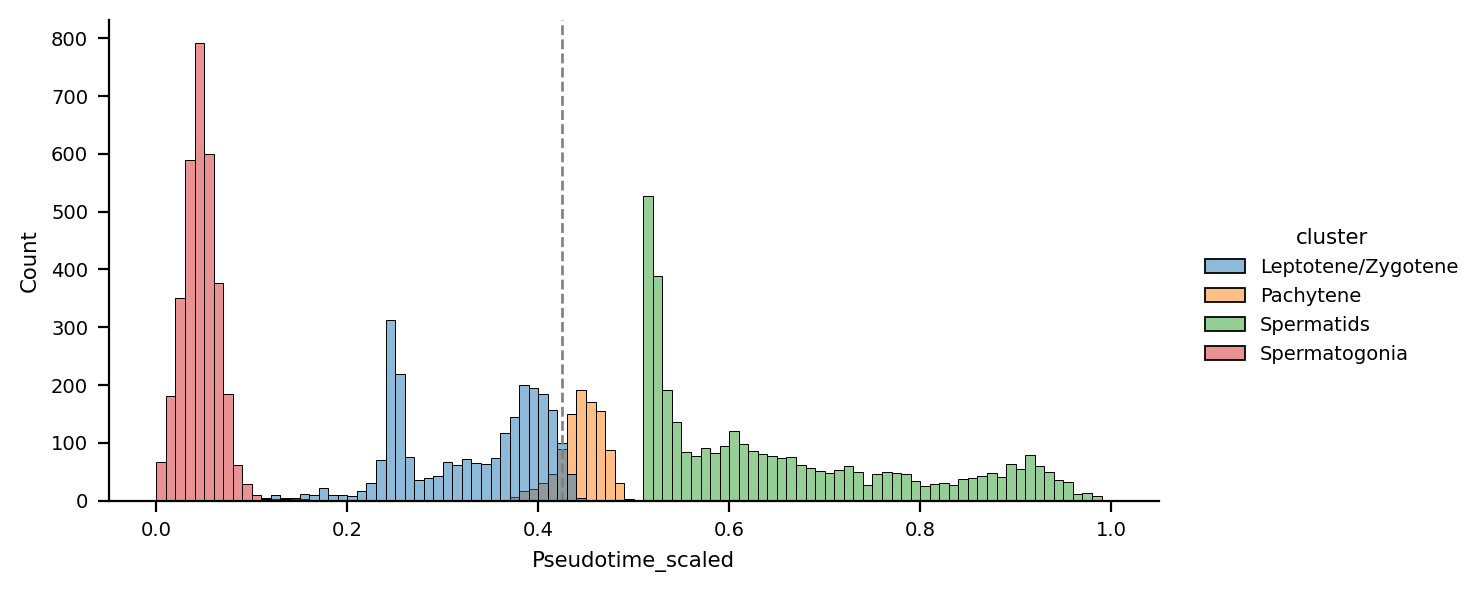

In [32]:
df = sc.get.obs_df(adata, keys=['cluster', 'Pseudotime_scaled'])
sns.displot(df, x='Pseudotime_scaled', hue='cluster', bins=100, height=3, aspect=2) ;
plt.axvline(0.425, color='grey', linestyle='dashed') ;

## Cell DEG X genes humans

### Maybe do permutation test to see if the mean coef of my candidates is significantly larger than a random sample of the same size.

In [ ]:
df = pd.read_csv('../data/mast_output_flt_cell.tsv', sep='\t')
cDEG_x_genes = df.loc[~df.signif.isnull() & (df.diff_exp == 'X')].sort_values('coef', ascending=False).set_index('primerid') 
cDEG_x_genes << left()

## Supplementary tables

In [ ]:
from openpyxl import load_workbook
wb = load_workbook(filename = '../data/Supplementary tables.xlsx')
wb.sheetnames

**Table 10** is the table of differentially expressed in whole cells for each species:

In [ ]:
data = wb.worksheets[wb.sheetnames.index('Supplementary table 10')].values
columns = next(data)[0:]
meritxell_som_table_10 = pd.DataFrame(data, columns=columns)
meritxell_som_table_10.tail()

Cut of the non-table rows in the sheet:

In [ ]:
meritxell_som_table_10 = meritxell_som_table_10.iloc[:51, :]
meritxell_som_table_10.tail()

In [ ]:
# genes_whole_cell_de_x = (meritxell_som_table_10
#                          .loc[(meritxell_som_table_10.diff_exp_Human == 'X'), 'gene']
#                          .sort_values()
#                         )
# list_genes(genes_whole_cell_de_x)

**Table 11** is the table of genes differentially in expressed either nuclecus or both nucleus and whole cell, which overlaps a region with indication of selection (sweep, low-ils, low-admixture):

In [ ]:
data = wb.worksheets[wb.sheetnames.index('Supplementary table 11')].values
columns = next(data)[0:]
meritxell_som_table_11 = pd.DataFrame(data, columns=columns)
meritxell_som_table_11.tail()

All X and Y genes:

In [33]:
chrX_genes = gi.get_genes_region_dataframe('chrX', 0, 160000000, assembly='hg19').drop_duplicates('name')
chrY_genes = gi.get_genes_region_dataframe('chrY', 0, 160000000, assembly='hg19').drop_duplicates('name')
chrX_genes.head()

name   start     end strand
0      PLCXD1  193022  220023      +
7      GTPBP6  221425  230887      -
8   LINC00685  281384  282067      +
10    PPP2R3B  294667  347642      -
11       SHOX  585078  620146      +

X genes with expression data:

In [34]:
x_genes_with_expr_data = set(adata.var["chromosome"][adata.var["chromosome"] == 'X'].index.values)

Import genes lists for sharing across analyses:

- List of genes from the sex chromosome paper (Zhou et al. 2023) that are ampliconic in at least primates (names are regular expressions to allow matching to genes in each set of multicopy genes)
- List of primate gametolog genes from the sex chromosome paper (Zhou et al. 2023).





In [35]:
from gene_lists import ampliconic_in_some_primates_regex, xy_gametologs, grove_autosomal_2019

In [36]:
list_genes(ampliconic_in_some_primates_regex)

HMGB         PNMA         CSAG         
USP27X       H2BW         TCP11X       
FAM9[AB]     NXF          XAGE1[AB]    
FAM47[AB]    SAGE1        FAM236       
SPIN         ARMCX6       CENPVL       
C16ORF89     TMLHE        H2AB         
SCML1        TEX28        GAGE         
RPL10        PABPC        SPANXN       
ATXN3L       PAGE         PWWP3B       
TRMT2B       CTAG         CXORF49      
DDX53        OPN1         HSFX[12]     
LAGE3        TMEM185A     SSX          
VCX          CT45A        DMRTC1       
ZNF          TMSB15B      FAM156[AB]   
IKBKG        CT55         MAGED        
CT83         CT47         XAGE[235]    
RHOXF2       EOLA1        F8A          
CXORF51B     HSFX[34]     MAGE[AB]     


In [37]:
list_genes(xy_gametologs)

P2RY8X     EIF1AX     TGIF2LX    
AKAP17AX   MBTPS2X    PCDH11X    
ASMTX      EIF2S3X    XKRX       
DHRSX      ZFX        RPL36AX    
ZBED1X     TAB3X      THOC2X     
MXRA5X     BCORX      RBMX       
PRKX       USP9X      SOX3       
NLGN4X     DDX3X      SRY        
VCX        KDM6A      SPANXNX    
TBL1X      UTY        HSFX       
AMELX      UBA1X      CCNQX      
MSL3X      TSPX       RPL10X     
PRPS2X     KDM5C                 
TMSB4X     KDM5D                 
TXLNGX     RPS4X                 


Grove autosomal ASD GWAS genes:

In [38]:
list_genes(grove_autosomal_2019)

KIZ            POU3F2         BEND4          
XRN2           NUD12          TMEM33         
NKX2-2         MROH5          DCAF4L1        
NKX2-4         CADPS                         
C8orf74        NEGR1                         
SOX7           MARK3                         
PINX1          CKB                           
LOC102723661   TRMT61A                       
PTBP2          BAG5                          
MACROD2        APOPT1                        
KMT2E          KLC1                          
SRPK2          XRCC3                         
MMS22L         SLC30A9                       


SFARI genes:

In [47]:
sfari_genes = pd.read_csv('../data/SFARI-Gene_genes_05-05-2022release_06-27-2022export.csv')
sfari_genes.head()

status gene-symbol                                          gene-name  \
0       9        ABAT                   4-aminobutyrate aminotransferase   
1       9      ABCA10  ATP-binding cassette, sub-family A (ABC1), mem...   
2       9      ABCA13         ATP binding cassette subfamily A member 13   
3       9       ABCA7  ATP-binding cassette, sub-family A (ABC1), mem...   
4       9         ACE                    angiotensin I converting enzyme   

        ensembl-id chromosome                                genetic-category  \
0  ENSG00000183044         16  Rare Single Gene Mutation, Genetic Association   
1  ENSG00000154263         17                       Rare Single Gene Mutation   
2  ENSG00000179869          7           Rare Single Gene Mutation, Functional   
3  ENSG00000064687         19                       Rare Single Gene Mutation   
4  ENSG00000159640         17  Rare Single Gene Mutation, Genetic Association   

   gene-score  syndromic  number-of-reports  
0         2.0          0                  6  
1         2.0          0                  1  
2         2.0          0                  7  
3         2.0          0                  4  
4         2.0          0                  3

SFARI genes on chrX:

In [48]:
list_genes(sfari_genes.loc[sfari_genes.chromosome == 'X'].sort_values('gene-symbol')['gene-symbol'])

AFF2        FRMPD4      OCRL        TAF1        
AGTR2       GABRA3      OFD1        TBL1X       
AP1S2       GLRA2       OPHN1       TBX22       
AR          GPC4        PCDH11X     TFE3        
ARHGEF9     GRIA3       PCDH19      TMLHE       
ARX         HCFC1       PHF8        TSPAN7      
ATRX        HDAC8       PJA1        UPF3B       
BCORL1      HNRNPH2     PLXNA3      USP9X       
BRWD3       HUWE1       PTCHD1      VSIG4       
CACNA1F     IL1RAPL1    PTCHD1-AS   WNK3        
CASK        IL1RAPL2    RAB39B      ZNF711      
CD99L2      IQSEC2      RHOXF1                  
CDKL5       KDM5C       RLIM                    
CHM         KDM6A       RPL10                   
CLCN4       LAS1L       RPS6KA3                 
CNKSR2      MAOA        SLC6A8                  
DDX3X       MAOB        SLC7A3                  
DDX53       MECP2       SLC9A6                  
DMD         MSL3        SMC1A                   
FAM47A      NEXMIF      SYAP1                   
FGF13       NLGN3   

# Exploring individual trajectories

DEG PPI sets (Experiments, Databases, Gene Fusion, Co‑occurrence):

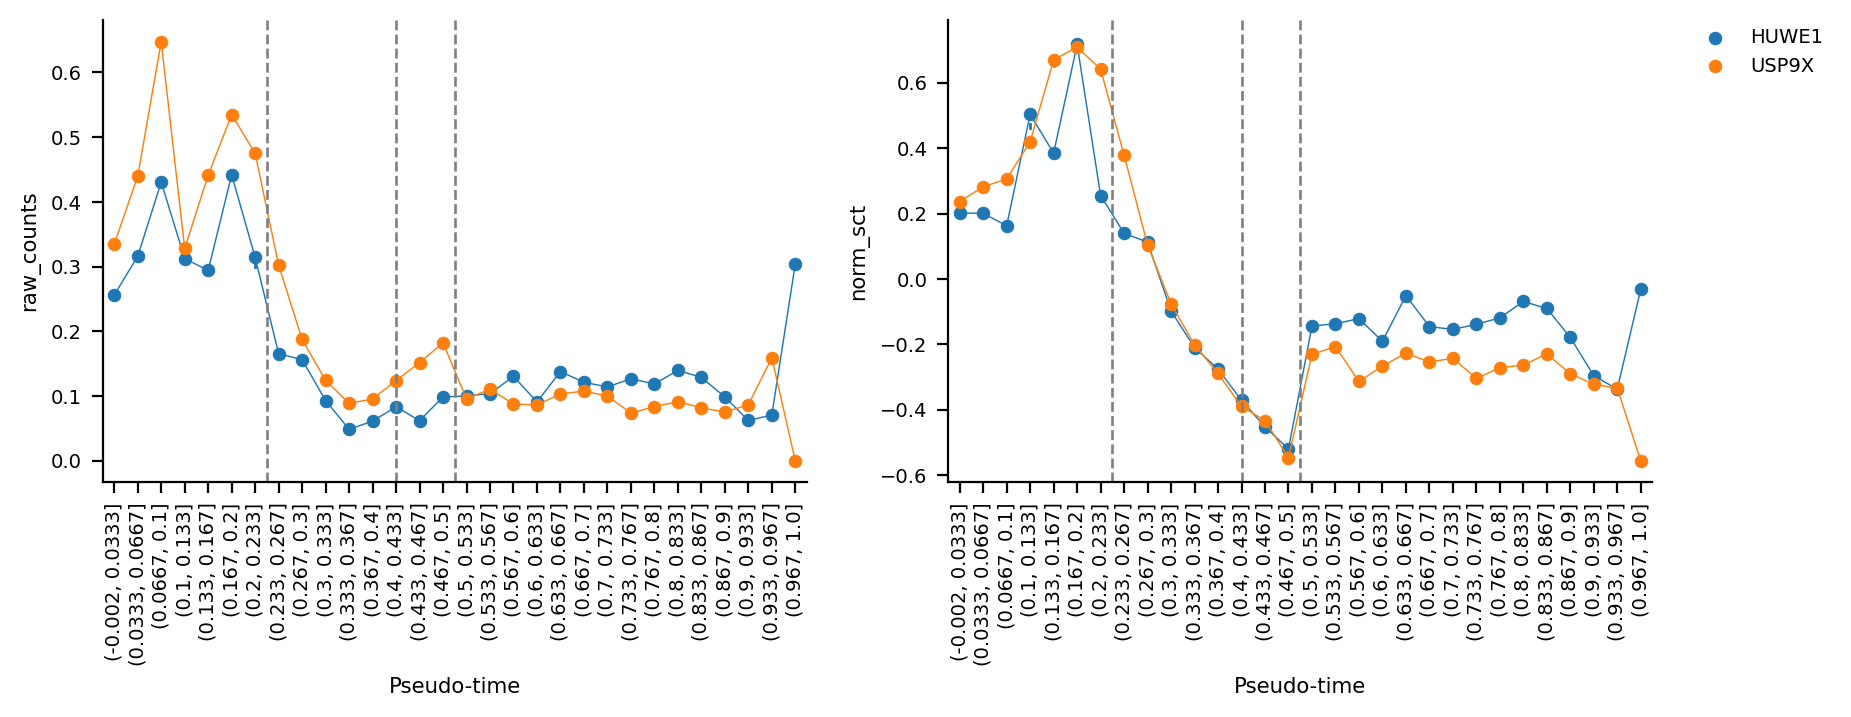

In [49]:
ep.trajectory(['HUWE1', 'USP9X']) ;

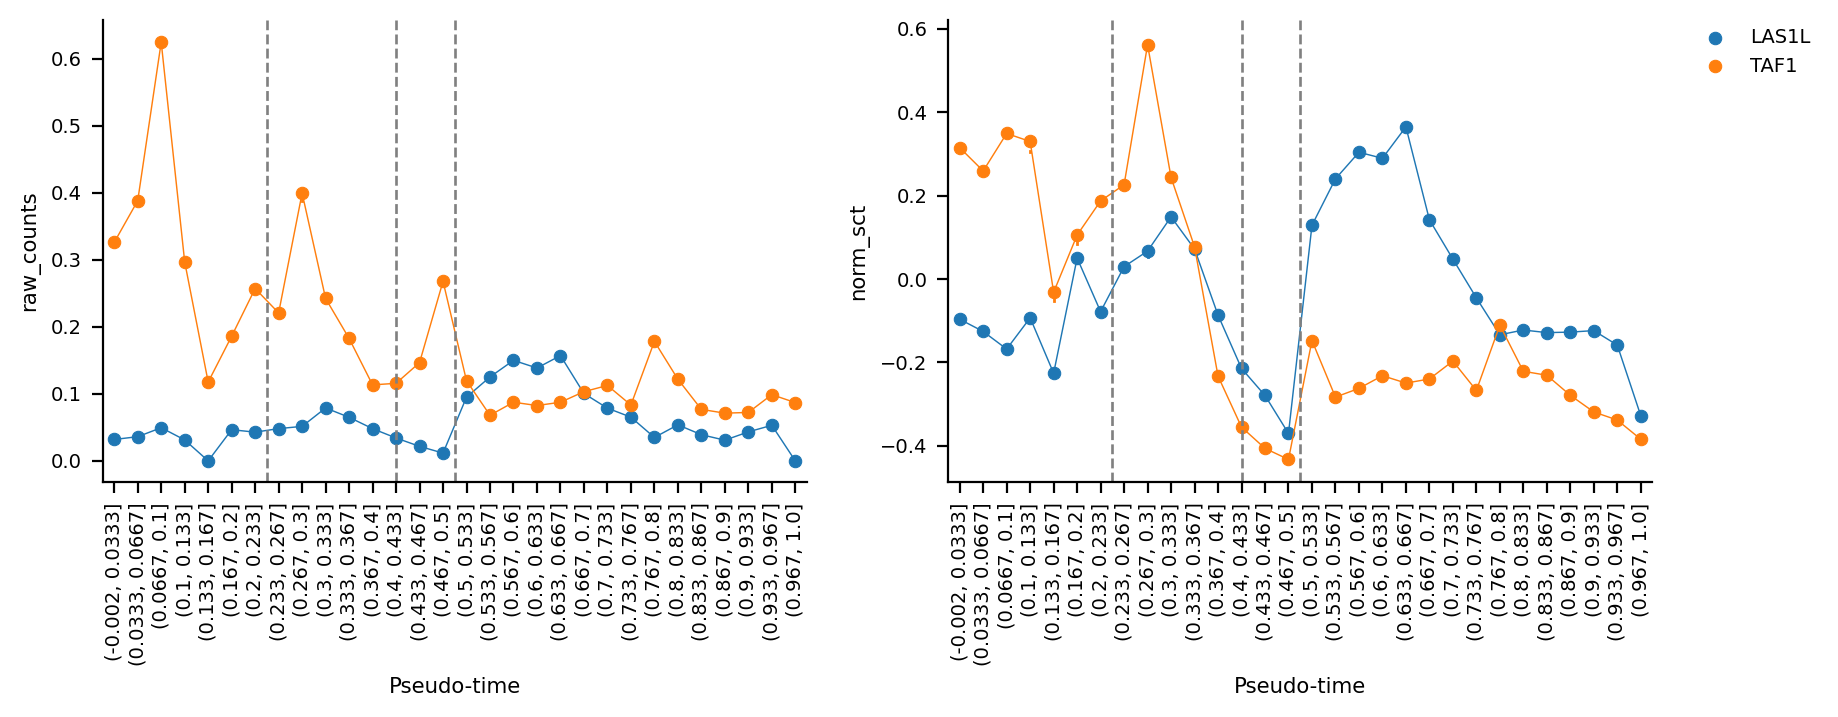

In [50]:
ep.trajectory(['LAS1L', 'TAF1']) ;

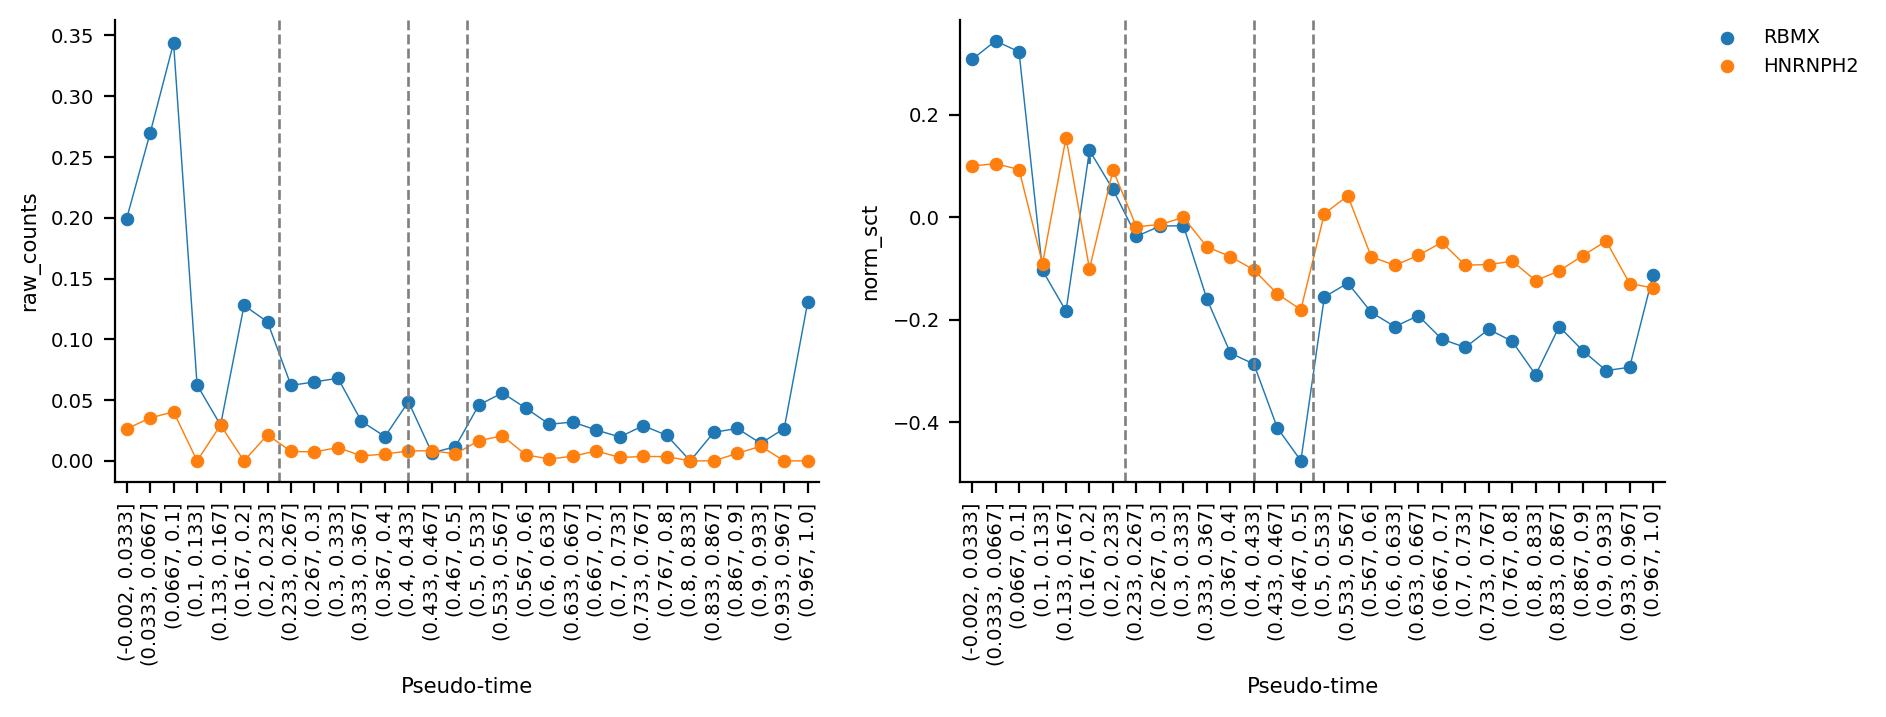

In [51]:
ep.trajectory(['RBMX', 'HNRNPH2']) ;

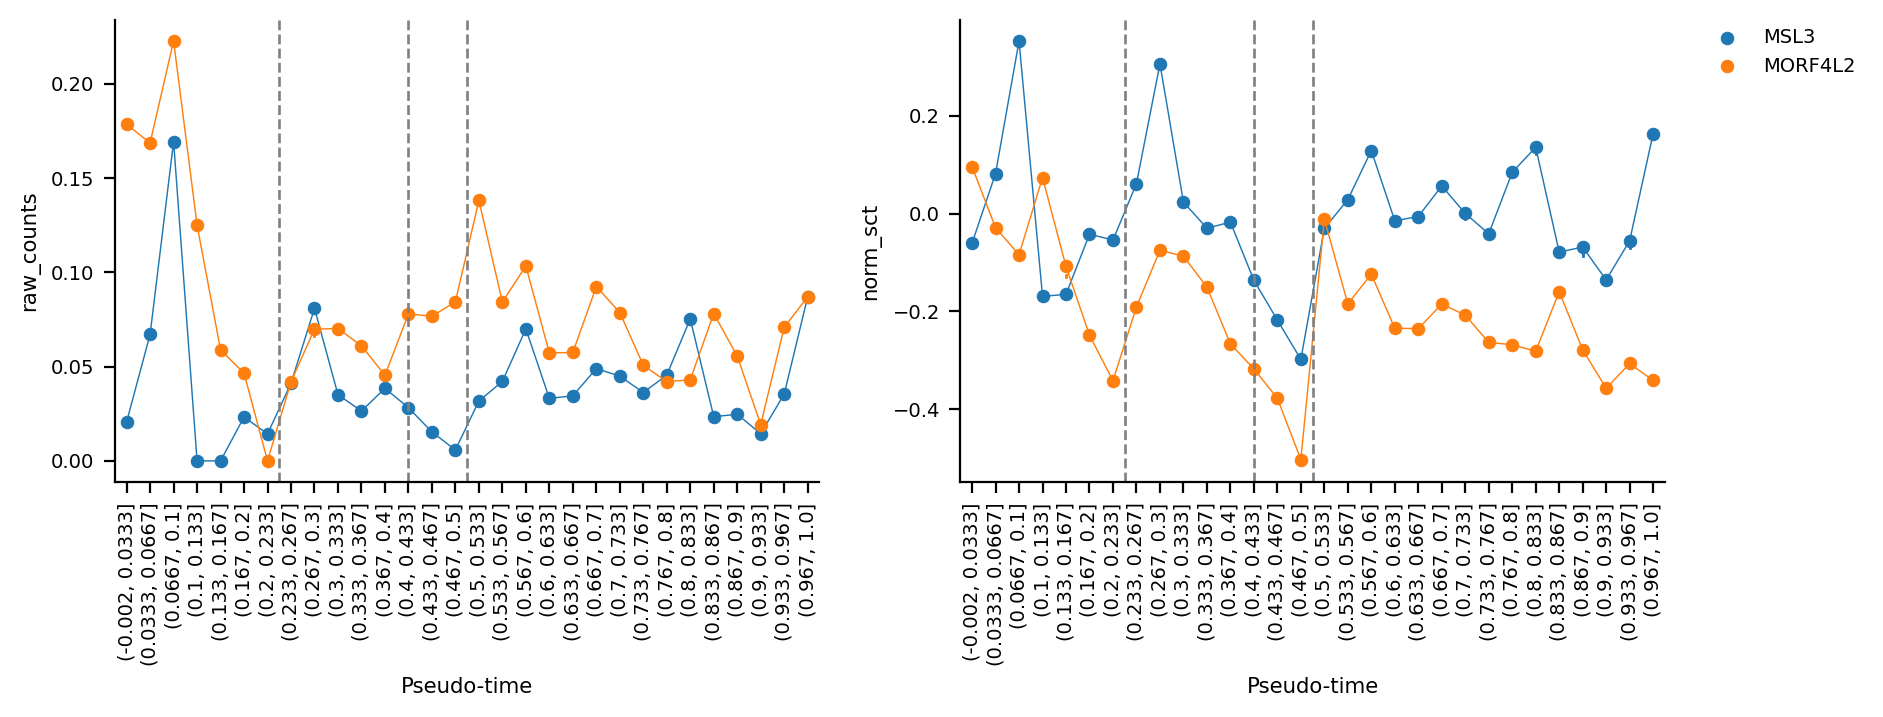

In [52]:
ep.trajectory(['MSL3', 'MORF4L2']) ;

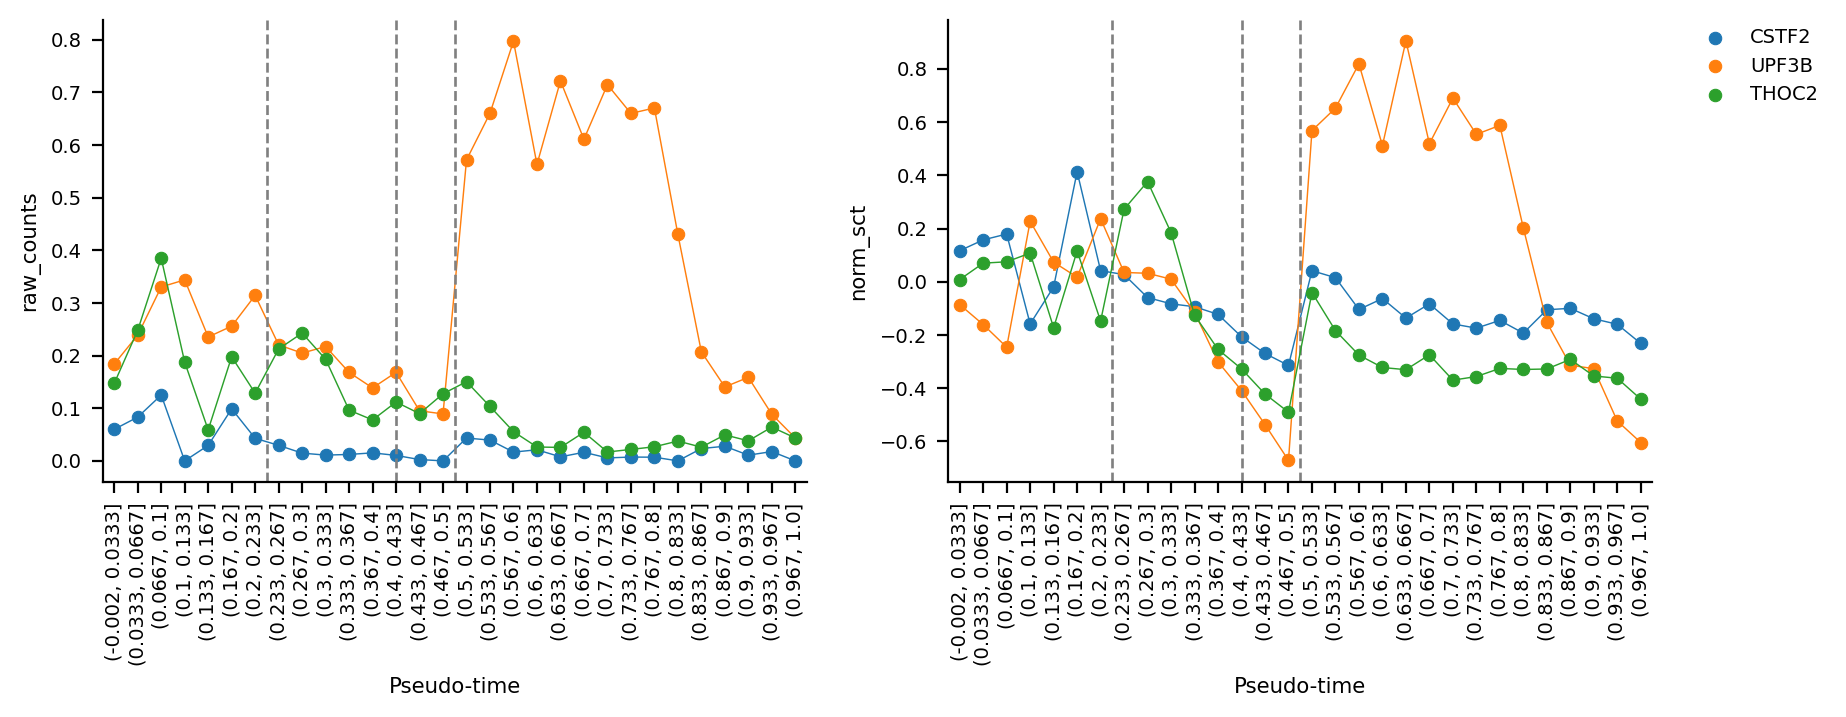

In [53]:
ep.trajectory(['CSTF2', 'UPF3B', 'THOC2']) ;

In [54]:
# for g in top_diff_exp.loc[top_diff_exp.diff_exp != 'No-significant'].sort_values('coef', ascending=False).gene_name.values:
#     print(g)

In [55]:
#top_diff_exp.loc[top_diff_exp.diff_exp != 'No-significant'].sort_values('coef', ascending=False)

In [56]:
#top_diff_exp.loc[top_diff_exp.diff_exp != 'No-significant'].sort_values('coef', ascending=False).head(20) << left()

# Compute norm_sct expression means

In [57]:
df = adata.to_df(layer='norm_sct')
#df = df.loc[adata.var.chromosome == 'X']
df['ptime'] = pd.cut(adata.obs.Pseudotime_scaled, include_lowest=True, bins=30)
ptime_bins = df['ptime'].unique().sort_values()
means_fine_df_all = df.groupby('ptime').mean()
means_fine_df_all.columns.name = 'gene'
means_fine_df_all = means_fine_df_all.transpose()
means_fine_df_all = means_fine_df_all[ptime_bins]

# only chrX
means_fine_df = means_fine_df_all.loc[adata.var.chromosome == 'X']
means_fine_df.head()

ptime  (-0.002, 0.0333]  (0.0333, 0.0667]  (0.0667, 0.1]  (0.1, 0.133]  \
gene                                                                     
GYG2           0.013320          0.162852       0.153664     -0.105513   
ARSD           0.051306          0.069367       0.008655     -0.086141   
ARSL           0.063023         -0.016802       0.102967      0.178717   
ARSH          -0.001131          0.042301       0.107978      0.048469   
ARSF           0.023974          0.065903       0.029981     -0.108592   

ptime  (0.133, 0.167]  (0.167, 0.2]  (0.2, 0.233]  (0.233, 0.267]  \
gene                                                                
GYG2        -0.103562      0.163964     -0.079616       -0.064393   
ARSD        -0.084228     -0.087577     -0.088926       -0.032798   
ARSL        -0.093546     -0.094777     -0.096842       -0.051508   
ARSH        -0.073433     -0.075903     -0.076965        0.056948   
ARSF        -0.104168     -0.055895     -0.108773       -0.061148   

ptime  (0.267, 0.3]  (0.3, 0.333]  ...  (0.667, 0.7]  (0.7, 0.733]  \
gene                               ...                               
GYG2      -0.099105     -0.064864  ...      0.034594     -0.074653   
ARSD      -0.080085     -0.050843  ...     -0.099612     -0.099845   
ARSL      -0.084600     -0.058478  ...     -0.088750     -0.091513   
ARSH       0.071976      0.007075  ...     -0.022339      0.064382   
ARSF      -0.038569     -0.013696  ...     -0.010365     -0.092713   

ptime  (0.733, 0.767]  (0.767, 0.8]  (0.8, 0.833]  (0.833, 0.867]  \
gene                                                                
GYG2         0.116886     -0.073202     -0.123290       -0.084088   
ARSD        -0.103134     -0.097347     -0.101333        0.026941   
ARSL         0.121692     -0.001074     -0.009786       -0.050826   
ARSH         0.038611      0.059173      0.008478       -0.078128   
ARSF         0.098239     -0.039301     -0.002062        0.002513   

ptime  (0.867, 0.9]  (0.9, 0.933]  (0.933, 0.967]  (0.967, 1.0]  
gene                                                             
GYG2       0.037497     -0.100138       -0.141711     -0.011975  
ARSD      -0.015032     -0.043603       -0.055052     -0.128201  
ARSL       0.058062     -0.034937       -0.129359      0.062067  
ARSH      -0.082962     -0.043001       -0.099089      0.078078  
ARSF      -0.036779     -0.042136        0.043196     -0.156244  

[5 rows x 30 columns]

In [58]:
# df = adata.to_df(layer='norm_sct')
# df['cluster'] = adata.obs.cluster
# df.set_index('cluster', inplace=True)
# means_df = df.groupby('cluster').mean()
# means_df.columns.name = 'gene'
# means_df = means_df.transpose()
# means_df = means_df[clusters]
# means_df.head()

In [59]:
# df = adata.to_df(layer='raw_counts')
# df['cluster'] = adata.obs.cluster
# df.set_index('cluster', inplace=True)
# raw_means_df = df.groupby('cluster').mean()
# raw_means_df.columns.name = 'gene'
# raw_means_df = raw_means_df.transpose()
# raw_means_df = raw_means_df[clusters]
# raw_means_df.head()

In [60]:
# # %env http_proxy=http://proxyserv:3128
# # %env https_proxy=http://proxyserv:3128
# import geneinfo as gi
# gi.email = 'kaspermunch@birc.au.dk'

In [61]:
# from Bio import Entrez
# gi._assert_entrez_email()
# handle = Entrez.esearch(db="gene", term=f'9606[Taxonomy ID] AND alive[property] AND genetype protein coding[Properties]', retmax="1000000")
# records = Entrez.read(handle)
# id_list = records["IdList"]

In [62]:
# gi._fetch_ids_to_file(id_list, 'all_genes.txt')

In [63]:
# df = pd.read_csv('all_genes.txt', sep='\t')
# x_genes = (df
#            .loc[df.chromosome=='X', ['Symbol', 
#                                     'chromosome', 
#                                     'start_position_on_the_genomic_accession', 
#                                     'end_position_on_the_genomic_accession']]
#  .rename(columns=dict(chromosome='chrom',
#          Symbol='gene',
#          start_position_on_the_genomic_accession='start',
#          end_position_on_the_genomic_accession='end'))
#           )
# x_genes.head()

In [64]:
# df = means_df.reset_index().merge(x_genes, on='gene', how='right').sort_values(by=['start', 'end'])
# df.head()

# K-means clustering of X genes

In [96]:
n_clusters = 20
membership_labels = list(range(n_clusters))
ptime_columns = means_fine_df.columns
#ptime_columns = means_fine_df.columns[[x > pd.Interval(0.4, 1, closed='right') for x in means_fine_df.columns]]
X = means_fine_df[ptime_columns].values

kmeans = KMeans(n_clusters=n_clusters, n_init='auto', random_state=0).fit(X)
df = pd.DataFrame().from_records(kmeans.cluster_centers_, columns=ptime_columns)
df.index.name = 'membership'
df.columns.name = 'ptime'
plot_df = df.stack().to_frame('expression').reset_index()
plot_df.tail()

membership           ptime  expression
595          19  (0.833, 0.867]   -0.305810
596          19    (0.867, 0.9]   -0.266097
597          19    (0.9, 0.933]   -0.348365
598          19  (0.933, 0.967]   -0.305726
599          19    (0.967, 1.0]   -0.365809

In [108]:
memberships = kmeans.predict(X)
means_fine_df_with_memberships = means_fine_df.copy()
means_fine_df_with_memberships.columns = means_fine_df_with_memberships.columns.tolist() # remvoe categoriesfrom column index
means_fine_df_with_memberships['membership'] = memberships
plot_df = means_fine_df_with_memberships.reset_index().melt(id_vars=['gene', 'membership'], var_name='ptime', value_name='expression')
plot_df

gene  membership             ptime  expression
0                           GYG2           6  (-0.002, 0.0333]    0.013320
1                           ARSD           6  (-0.002, 0.0333]    0.051306
2                           ARSL           6  (-0.002, 0.0333]    0.063023
3                           ARSH           6  (-0.002, 0.0333]   -0.001131
4                           ARSF           6  (-0.002, 0.0333]    0.023974
...                          ...         ...               ...         ...
22045     amplicon-chrX-RHOXF2/B          19      (0.967, 1.0]   -0.346633
22046     amplicon-chrX-SPACA5/B           2      (0.967, 1.0]   -0.109813
22047  amplicon-chrX-SUPT20HL1/2           0      (0.967, 1.0]   -0.112949
22048  amplicon-chrX-VCX/2/3A/3B          11      (0.967, 1.0]   -0.667669
22049     amplicon-chrX-XAGE1A/B           7      (0.967, 1.0]   -0.293735

[22050 rows x 4 columns]

In [98]:
# ax = sns.pointplot(data=plot_df, x='ptime', y='expression', hue='membership', 
#                    errorbar='sd', capsize=.1, 
#                    order=ptime_bins,
#                    scale=0.5
#                   )
# plt.xticks(rotation=90)
# ax.axvline(6.5, color='grey', linestyle='dashed')
# ax.axvline(12, color='grey', linestyle='dashed')
# ax.axvline(14.5, color='grey', linestyle='dashed')
# ax.set_ylabel('norm_sct-time')
# ax.set_xlabel(None)
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, frameon=False, borderaxespad=0.)
# sns.despine()

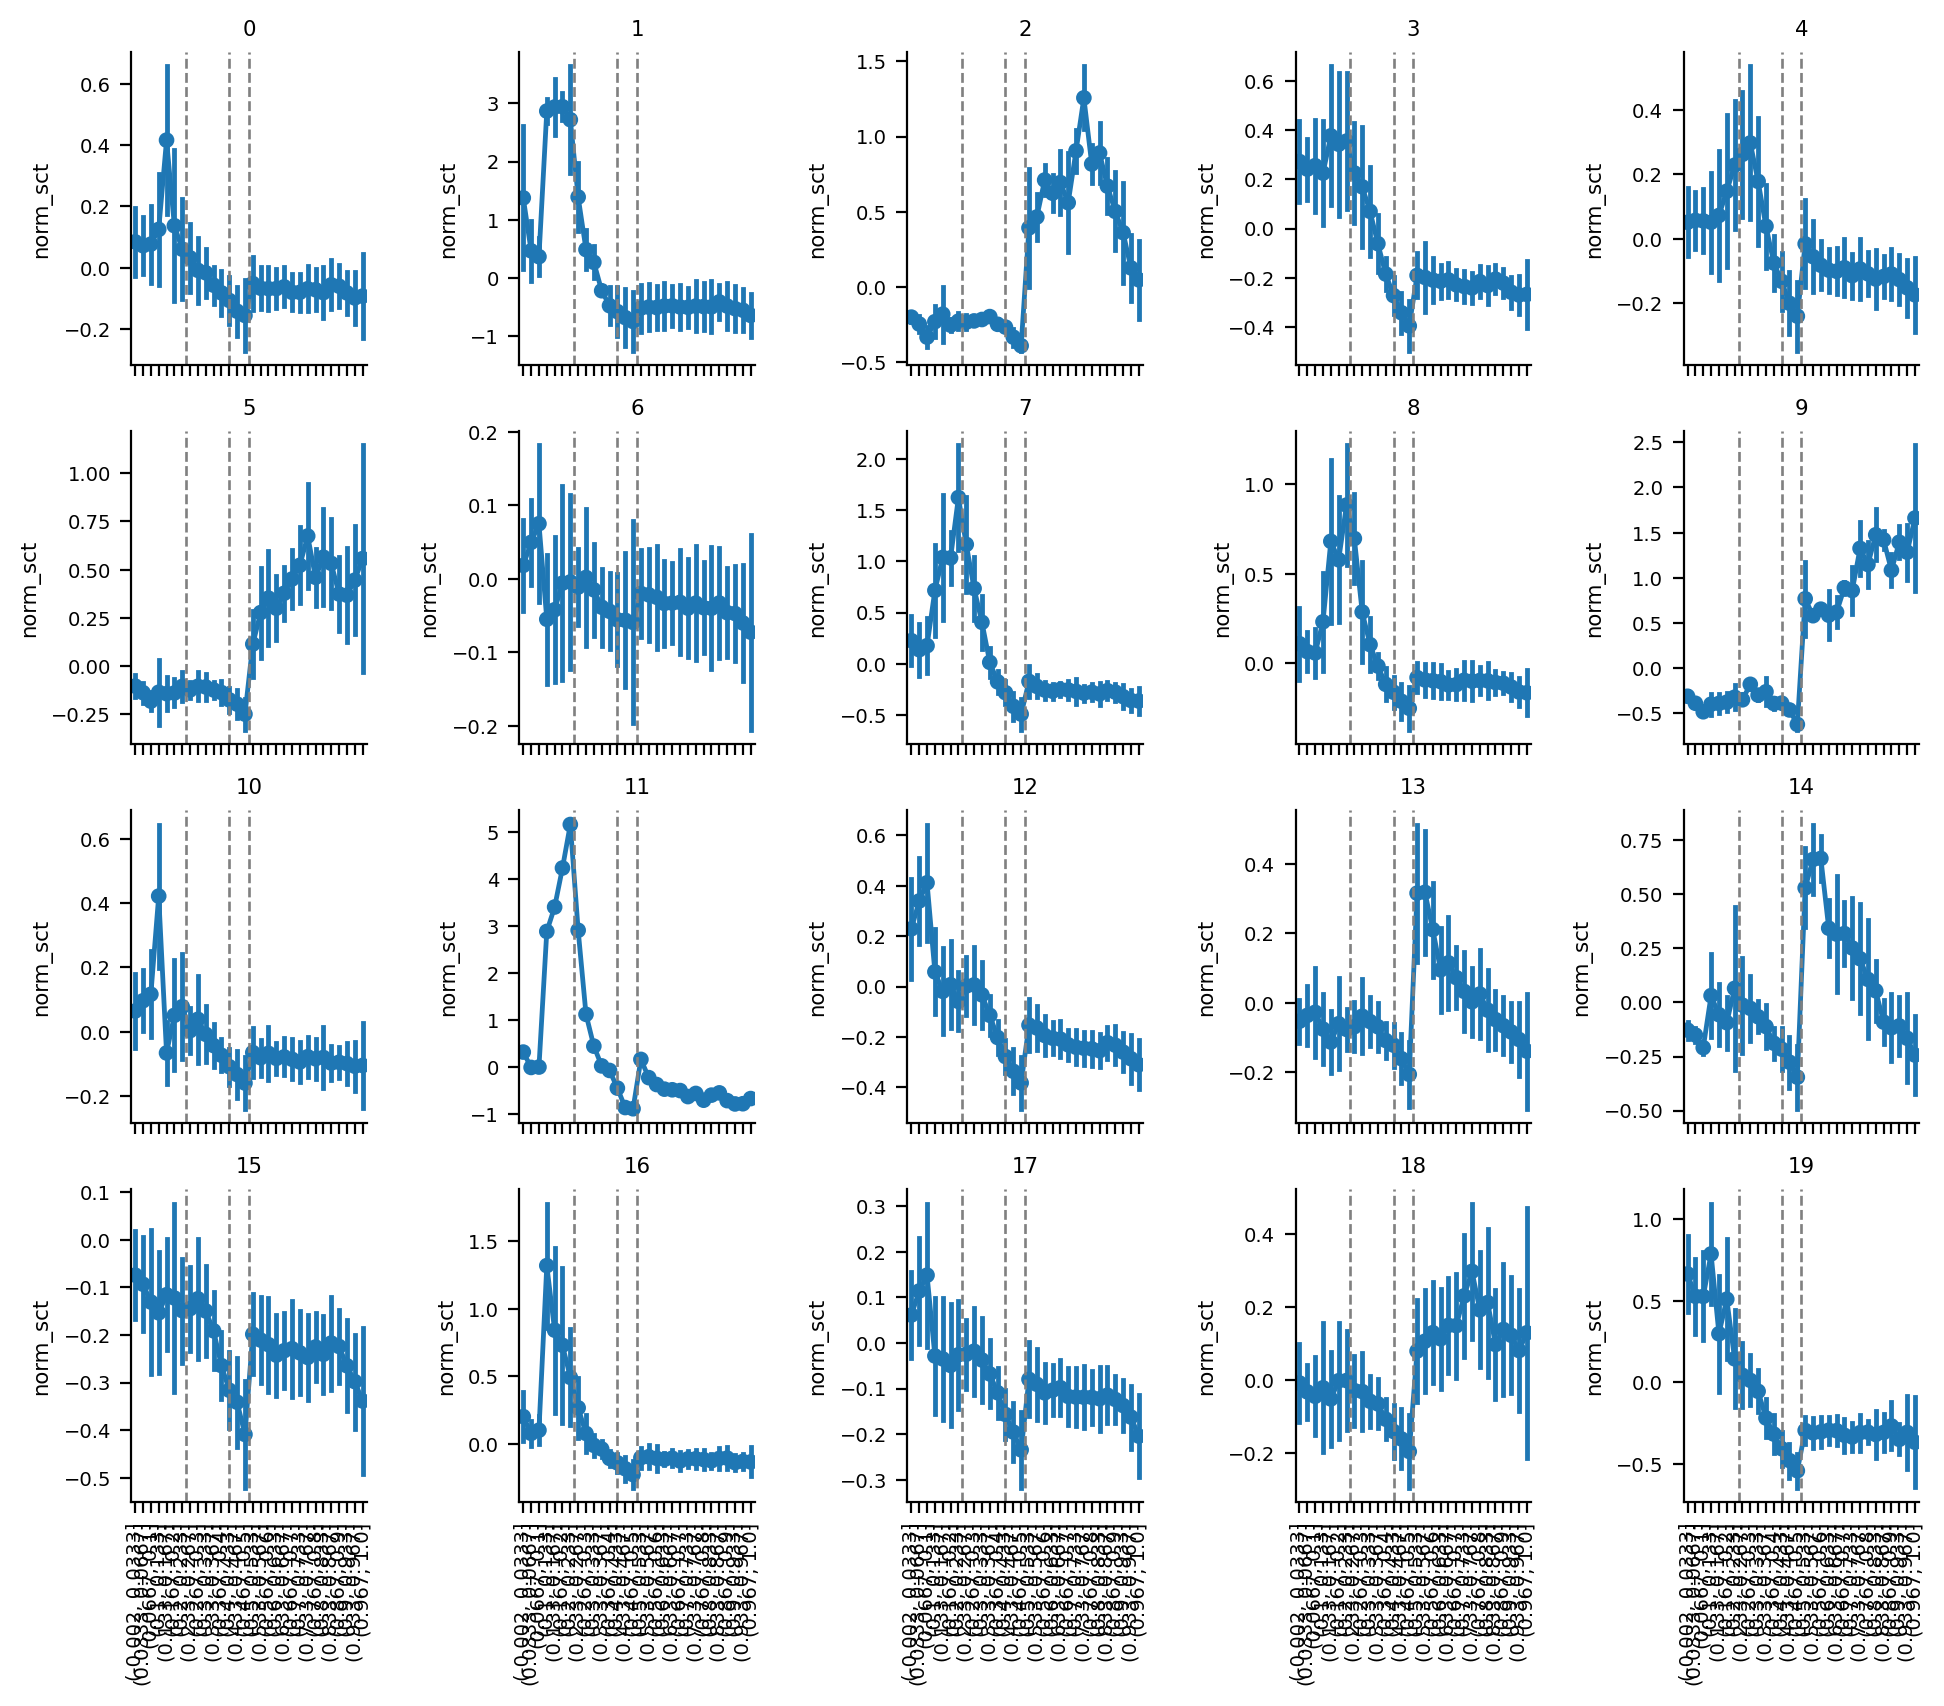

In [99]:
g = sns.FacetGrid(plot_df,
                  col="membership", height=2, col_wrap=5, sharey=False)
g.map(sns.pointplot, 'ptime', 'expression', 
      order=ptime_bins, 
      errorbar='sd')
for ax in g.axes.flat:
    ax.tick_params(axis='x', labelrotation=90)
    ax.set_xlabel(None)
    ax.set_ylabel('norm_sct')
    ax.axvline(6.5, color='grey', linestyle='dashed')
    ax.axvline(12, color='grey', linestyle='dashed')
    ax.axvline(14.5, color='grey', linestyle='dashed')    
g.set_titles(col_template="{col_name}", row_template="{row_name}") ;

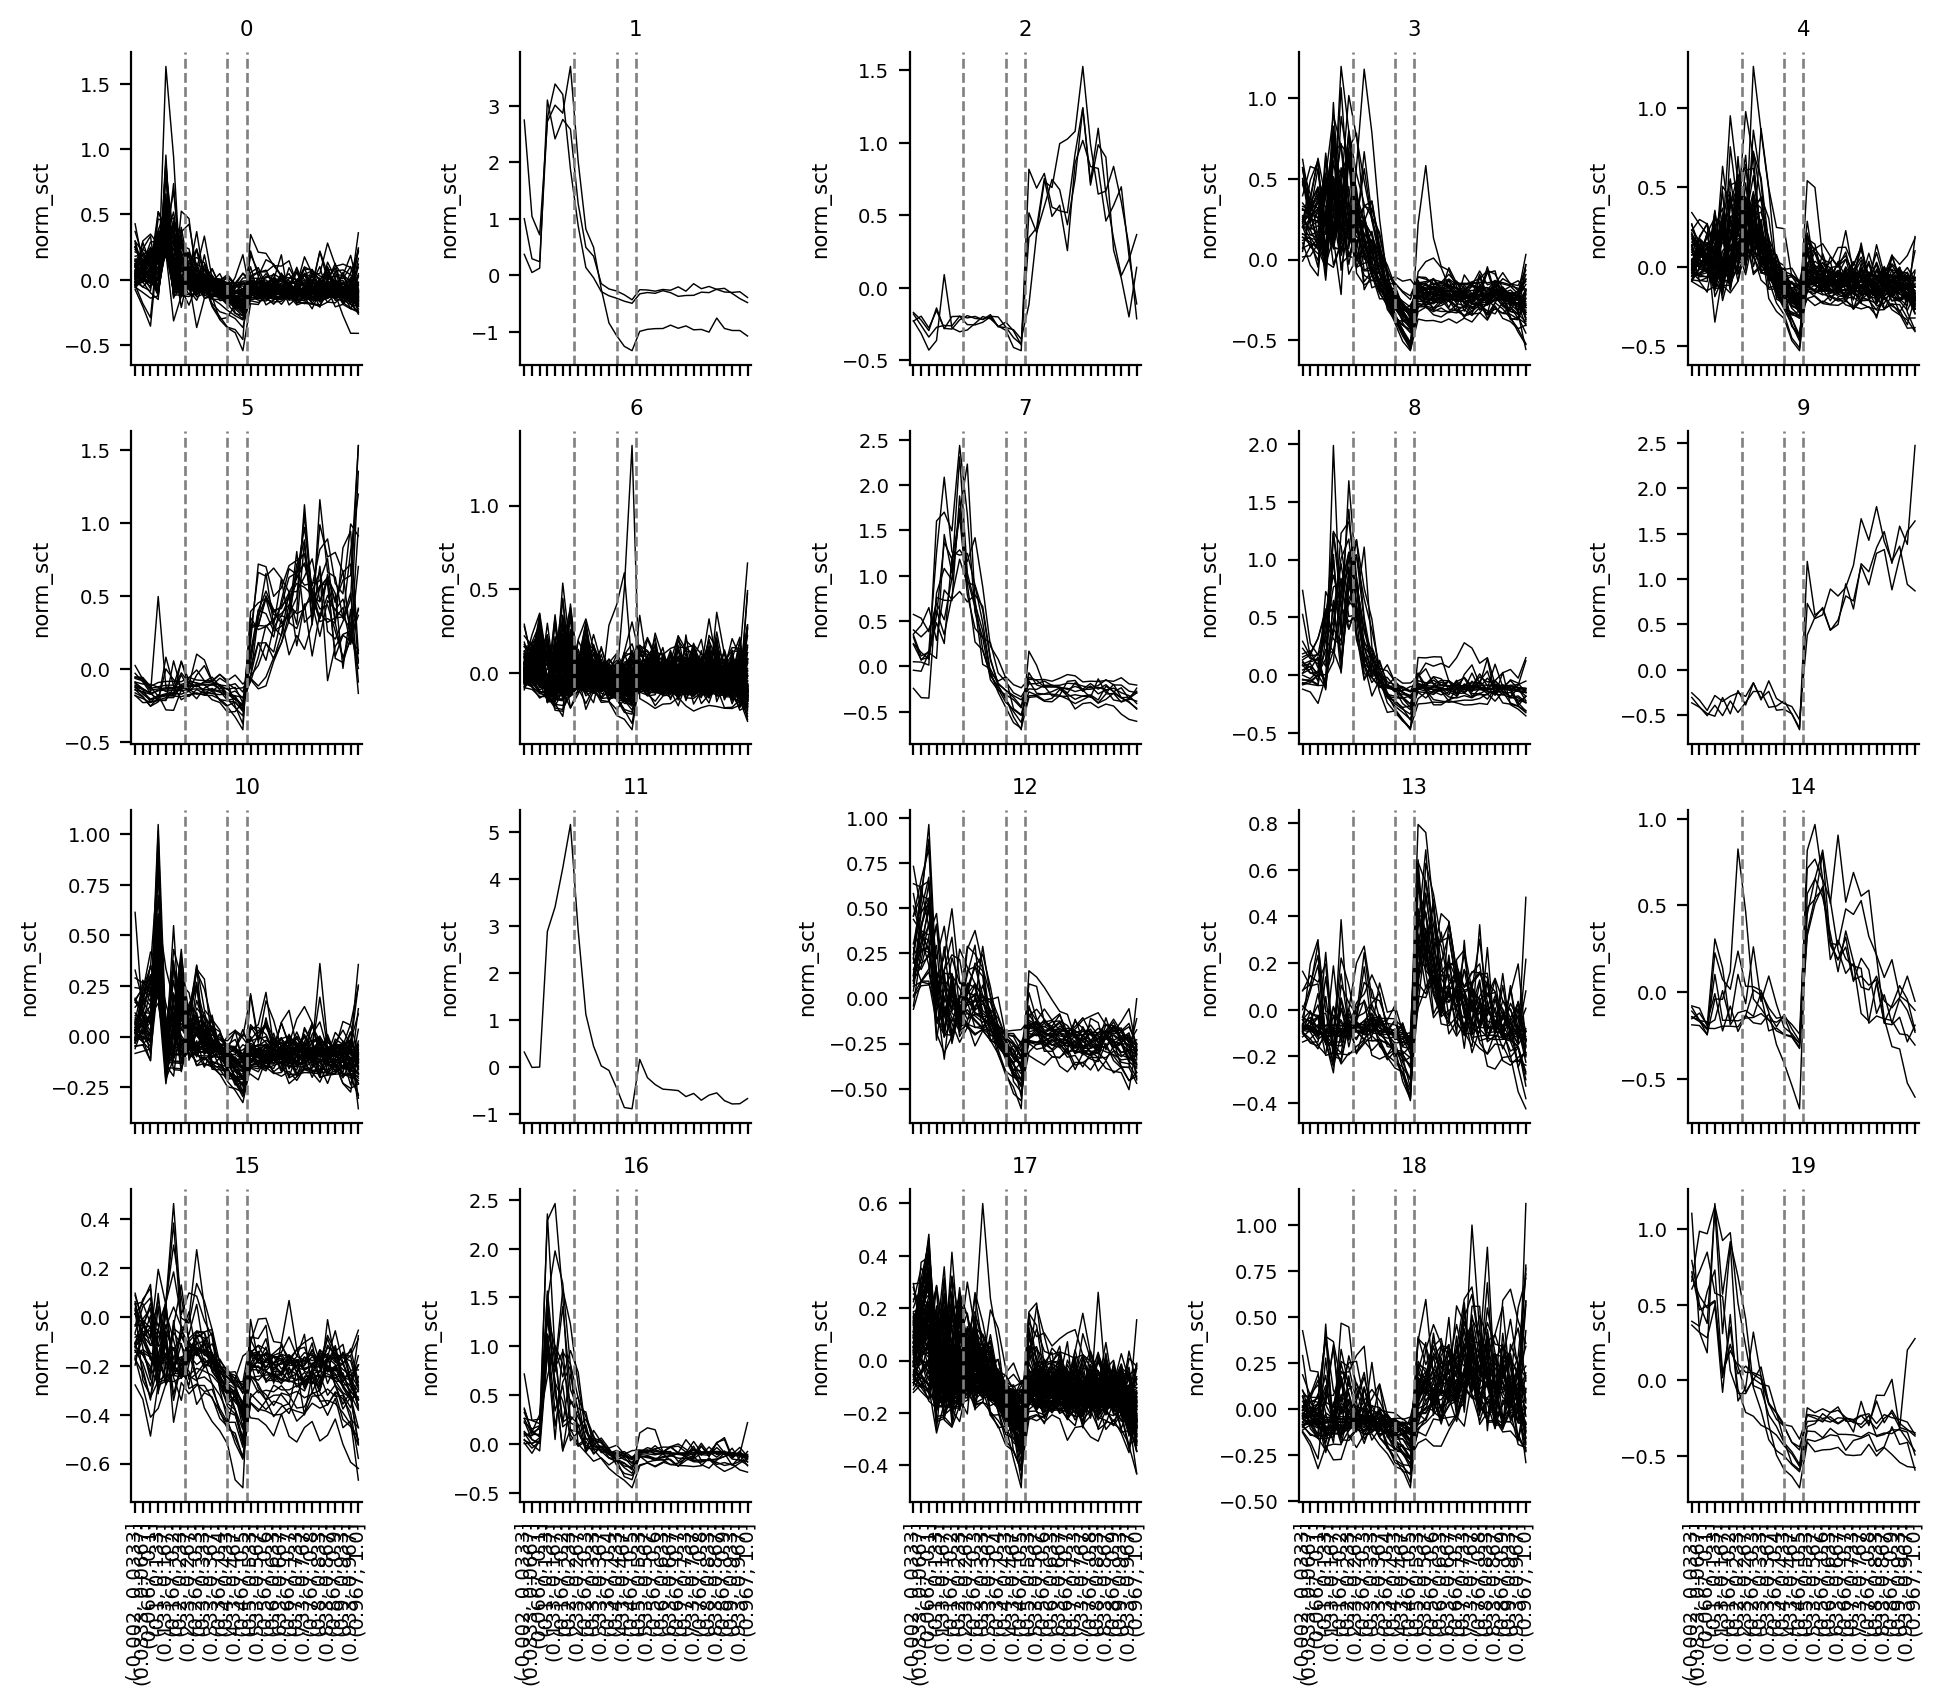

In [69]:
g = sns.FacetGrid(plot_df, 
                  col="membership", hue="gene", height=2, col_wrap=5, sharey=False)
g.map(sns.pointplot, 'ptime', 'expression', 
      order=ptime_bins, 
      errorbar=None, scale=0.3, color='black')

for ax in g.axes.flat:
    ax.tick_params(axis='x', labelrotation=90)
    ax.set_xlabel(None)
    ax.set_ylabel('norm_sct')
    ax.axvline(6.5, color='grey', linestyle='dashed')
    ax.axvline(12, color='grey', linestyle='dashed')
    ax.axvline(14.5, color='grey', linestyle='dashed')
    plt.setp(ax.collections, sizes=[0], alpha=1) #for the markers
    plt.setp(ax.lines, alpha=1)       #for the lines    
    #plt.setp(ax.collections, )
g.set_titles(col_template="{col_name}", row_template="{row_name}") ;

In [70]:
for i in range(20):
    print(f'\nCluster {i}')
    list_genes(plot_df.loc[plot_df.membership == i].gene.unique())


Cluster 0
CLCN4                       PBDC1                       FMR1-AS1                    
ARHGAP6                     SATL1                       IDS                         
TMSB4X                      LOC107985653                HAUS7                       
LINC02154                   NAP1L3                      CCNQ                        
EIF1AX                      FAM133A                     LOC105373383                
LOC107985707                NOX1                        ABCD1                       
MAGEB10                     CENPI                       PDZD4                       
GPR82                       TIMM8A                      NAA10                       
ZNF674                      BTK                         UBL4A                       
CHST7                       RPL36A                      FAM3A                       
LINC01560                   RADX                        G6PD                        
TIMP1                       NUP62CL                   

Number of genes in each cluster:

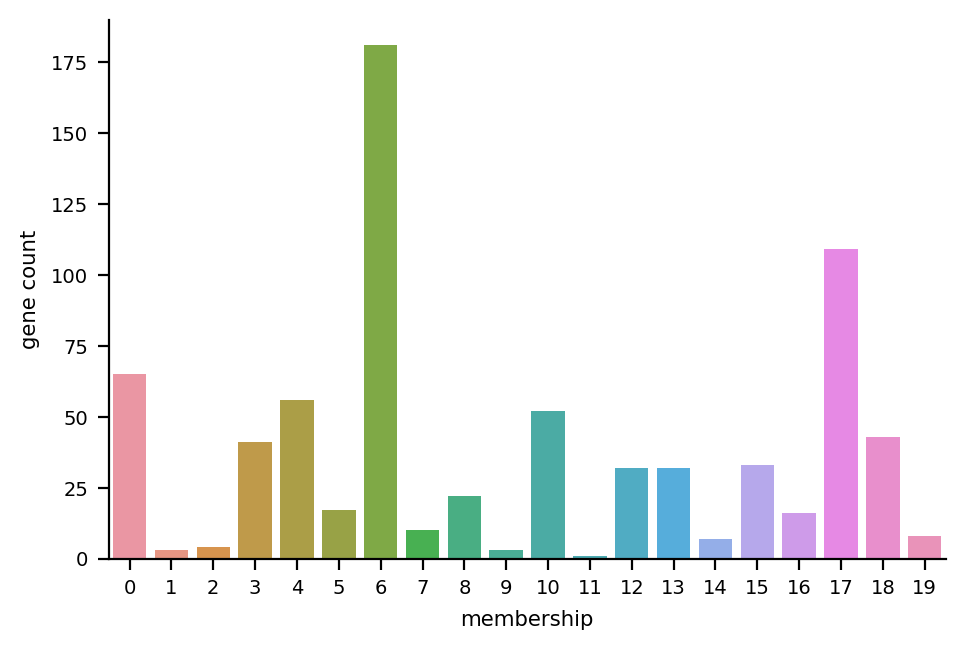

In [109]:
df = plot_df.membership.value_counts() / ptime_bins.size
df.index.name = 'membership'
all_genes_bar_plot_df =  df.to_frame('counts').sort_values('membership').reset_index()

ax = sns.barplot(x="membership", y="counts", data=all_genes_bar_plot_df)
ax.set_ylabel('gene count')
sns.despine()

How cDEG genes distribute among clusters made to fit all genes:

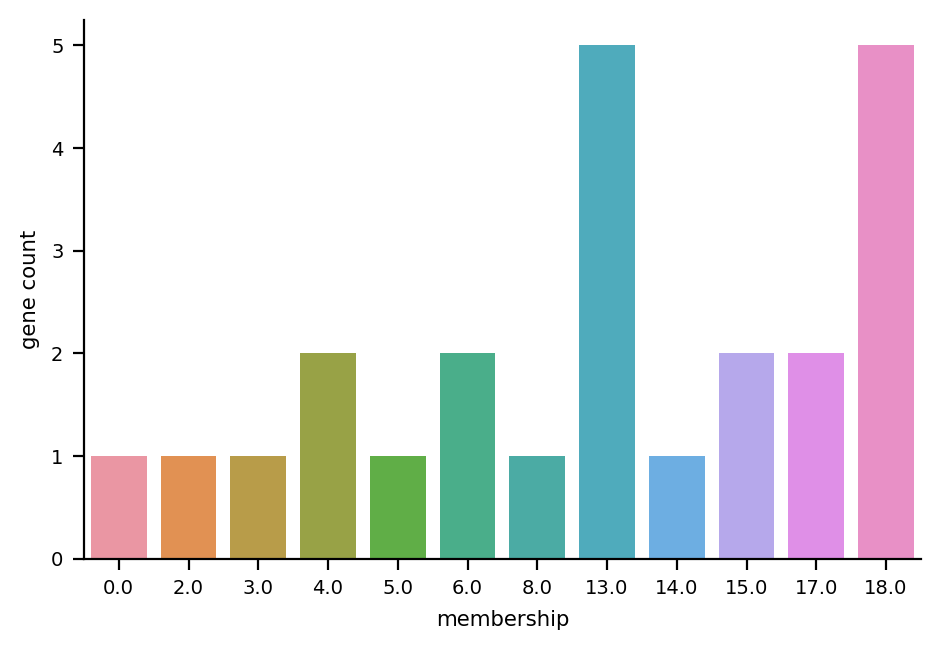

In [107]:
#plot_df.loc[~plot_df.gene.isin(genes_whole_cell_de_x), 'membership'] = np.nan
df = plot_df.membership.value_counts() / ptime_bins.size
df.index.name = 'membership'

all_genes_bar_plot_df =  df.to_frame('counts').sort_values('membership').reset_index()
ax = sns.barplot(x="membership", y="counts", data=all_genes_bar_plot_df)
ax.set_ylabel('gene count')
sns.despine()

# K-means clustering of X genes DE in whole cells

In [72]:
n_clusters = 20
membership_labels = list(range(n_clusters))
means_fine_df_cDEG = means_fine_df.loc[means_fine_df.index.isin(genes_whole_cell_de_x)]
X = means_fine_df_cDEG.values
kmeans = KMeans(n_clusters=n_clusters, n_init='auto', random_state=0).fit(X)
df = pd.DataFrame().from_records(kmeans.cluster_centers_, columns=means_fine_df_cDEG.columns)
df.index.name = 'membership'
df.columns.name = 'ptime'
plot_df = df.stack().to_frame('expression').reset_index()
plot_df.head()

membership             ptime  expression
0           0  (-0.002, 0.0333]    0.340254
1           0  (0.0333, 0.0667]    0.266882
2           0     (0.0667, 0.1]    0.203138
3           0      (0.1, 0.133]   -0.007293
4           0    (0.133, 0.167]    0.000762

/scratch/20207228/ipykernel_1688079/2605043261.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  means_fine_df_cDEG['membership'] = memberships


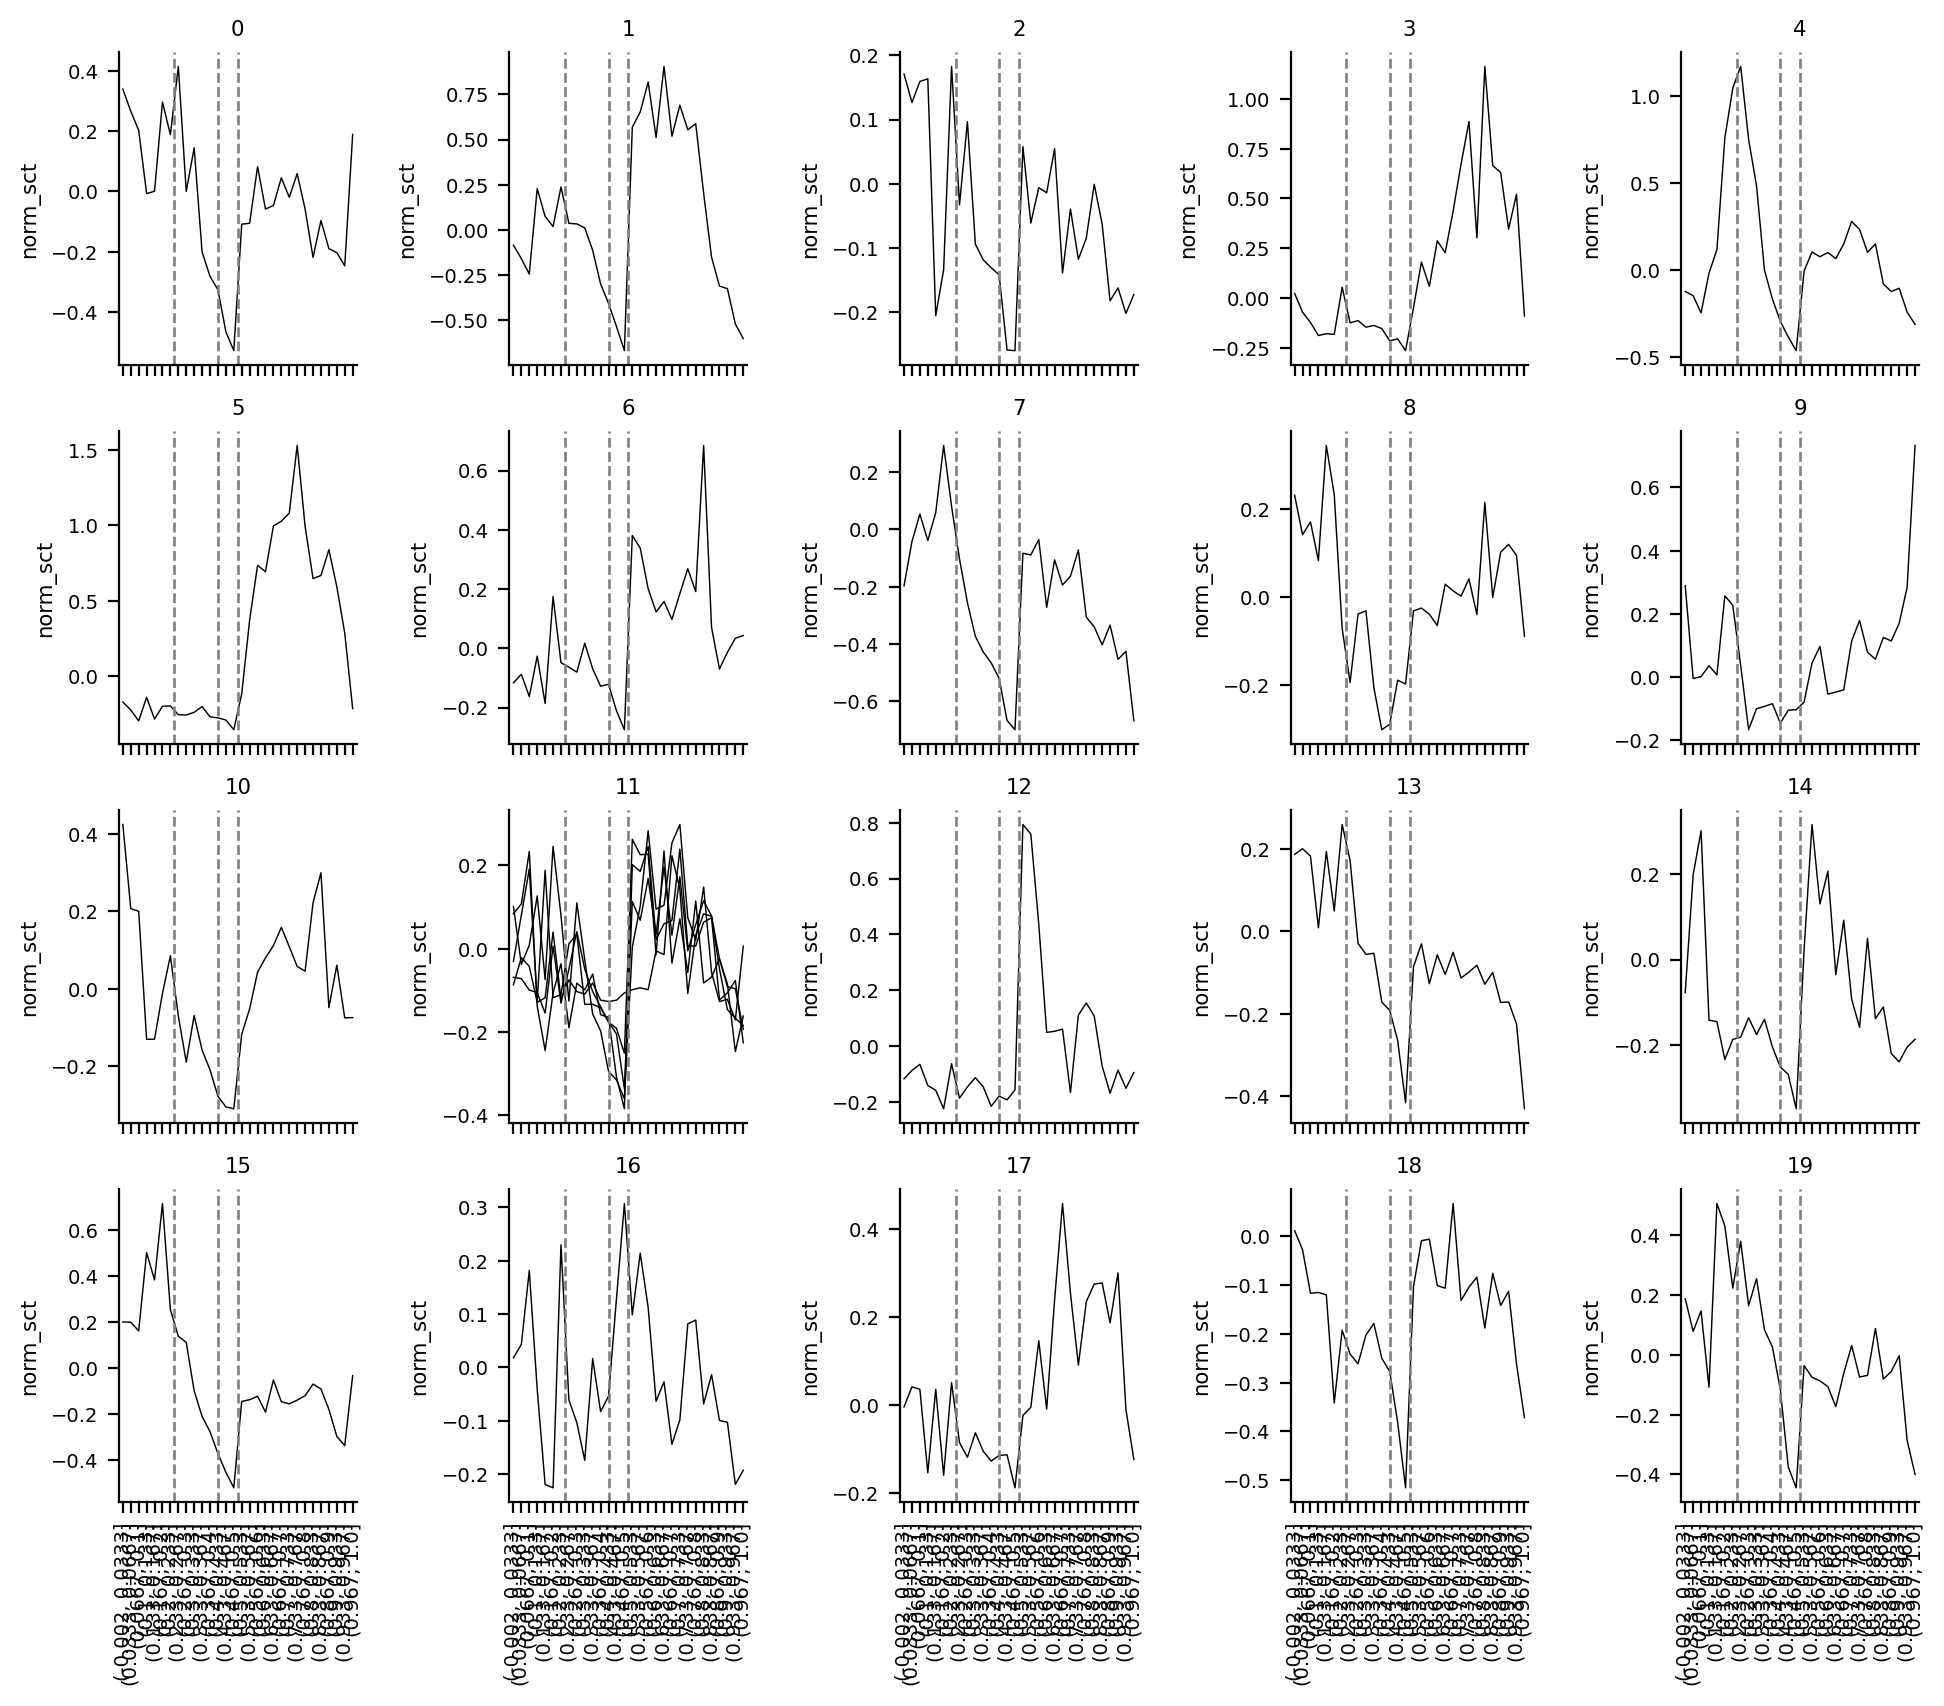

In [73]:
memberships = kmeans.predict(X)
means_fine_df_cDEG.columns = means_fine_df_cDEG.columns.tolist() # remvoe categoriesfrom column index
means_fine_df_cDEG['membership'] = memberships
plot_df = means_fine_df_cDEG.reset_index().melt(id_vars=['gene', 'membership'], var_name='ptime', value_name='expression')

g = sns.FacetGrid(plot_df, col="membership", hue="gene", height=2, col_wrap=5, sharey=False)
g.map(sns.pointplot, 'ptime', 'expression', 
      order=ptime_bins, 
      errorbar=None, scale=0.3, color='black')

for ax in g.axes.flat:
    ax.tick_params(axis='x', labelrotation=90)
    ax.set_xlabel(None)
    ax.set_ylabel('norm_sct')
    ax.axvline(6.5, color='grey', linestyle='dashed')
    ax.axvline(12, color='grey', linestyle='dashed')
    ax.axvline(14.5, color='grey', linestyle='dashed')
    plt.setp(ax.collections, sizes=[0], alpha=1) #for the markers
    plt.setp(ax.lines, alpha=1)       #for the lines    
    #plt.setp(ax.collections, )
g.set_titles(col_template="{col_name}", row_template="{row_name}") ;

In [74]:
for i in range(20):
    print(f'{i}:\t', ' '.join(plot_df.loc[plot_df.membership == i].gene.unique().tolist()))

0:	 PHF8
1:	 UPF3B
2:	 IGBP1
3:	 SYP
4:	 HDAC6
5:	 PRICKLE3
6:	 LL0XNC01-250H12.3
7:	 DIAPH2
8:	 EIF1AX
9:	 LOC105373184
10:	 FHL1
11:	 PPEF1 RPGR SRPX2 OCRL PABIR3
12:	 LOC105373313
13:	 CDKL5
14:	 AFF2
15:	 HUWE1
16:	 HTR2C
17:	 IQSEC2
18:	 PDK3
19:	 PRDX4


# Are X and Y genes expressed differently?

In [75]:
# plot_df = means_fine_df_all
# plot_df['chromosome'] = adata.var.chromosome[means_fine_df_all.index]
# plot_df = means_fine_df_all.groupby(['chromosome', 'membership']).membership.count().to_frame('counts').reset_index()
# plot_df.head()

In [76]:
# g = sns.FacetGrid(plot_df, col="chromosome", hue="membership", height=2, col_wrap=2, sharey=False)
# g.map(sns.barplot, "membership", "counts", order=membership_labels) ;   

# Comupte X ratio trajectories

In [77]:
layer='raw_counts'
df = adata.to_df(layer=layer)
df = df.loc[:, adata.var.chromosome.loc[df.columns] == 'X']
df = df.loc[:, df.columns.isin(genes_whole_cell_de_x)]
df['ptime'] = adata.obs.Pseudotime_scaled
df = df.merge(adata.obs["cell_class"].to_frame('cell_class'), how='left', left_index=True, right_index=True)
df = df.loc[df.cell_class.isin(['X', 'Y'])]
df['ptime'] = pd.qcut(df.ptime, q=4)

def x_ratio(df):
    x = df.loc[df.cell_class == 'X', 'expression'].mean() 
    y = df.loc[df.cell_class == 'Y', 'expression'].mean()
    if x + y:
        val = x / (x + y)
    else:
        val = np.nan
    return pd.DataFrame(dict(x_ratio=[val]))

x_ratio_trajectories = (df.melt(id_vars=['ptime', 'cell_class'], value_name='expression', var_name='gene')
 .groupby(['ptime', 'gene'])
 .apply(x_ratio)
 .reset_index()
)
x_ratio_trajectories['x_ratio'] = x_ratio_trajectories.groupby(['gene']).x_ratio.transform(lambda x: x / x.sum())
x_ratio_trajectories['ptime'] = x_ratio_trajectories['ptime'].cat.remove_unused_categories()

x_ratio_ptime_bins = x_ratio_trajectories['ptime'].unique().sort_values()

x_ratio_trajectories.head()

ptime    gene  level_2   x_ratio
0  (0.509, 0.53]    AFF2        0  0.291443
1  (0.509, 0.53]   CDKL5        0  0.269480
2  (0.509, 0.53]  DIAPH2        0  0.266752
3  (0.509, 0.53]  EIF1AX        0  0.261210
4  (0.509, 0.53]    FHL1        0  0.256200

# Clustering X ratio trajectories

Format table:

In [78]:
df_pivot = pd.pivot(x_ratio_trajectories.set_index('gene'), columns='ptime', values='x_ratio')
df_pivot = df_pivot.loc[~df_pivot.isnull().any(axis=1)]
df_pivot.head()

ptime   (0.509, 0.53]  (0.53, 0.612]  (0.612, 0.759]  (0.759, 1.0]
gene                                                              
AFF2         0.291443       0.269259        0.254302      0.184996
CDKL5        0.269480       0.229222        0.275194      0.226104
DIAPH2       0.266752       0.245804        0.248597      0.238847
EIF1AX       0.261210       0.247119        0.248932      0.242739
FHL1         0.256200       0.243028        0.258981      0.241791

Find cluster centers:

In [79]:
n_clusters = 20
membership_labels = list(range(n_clusters))
X = df_pivot.values
kmeans = KMeans(n_clusters=n_clusters, n_init='auto', random_state=0).fit(X)
df = pd.DataFrame().from_records(kmeans.cluster_centers_, columns=df_pivot.columns)
df.index.name = 'membership'
df.columns.name = 'ptime'
df.head()

ptime       (0.509, 0.53]  (0.53, 0.612]  (0.612, 0.759]  (0.759, 1.0]
membership                                                            
0                0.272119       0.263166        0.223509      0.241206
1                0.265957       0.253118        0.261131      0.219793
2                0.188789       0.276955        0.249889      0.284368
3                0.192426       0.252174        0.301805      0.253595
4                0.292047       0.271913        0.260598      0.175443

In [80]:
# plot_df = df.stack().to_frame('expression').reset_index()
# plot_df.head()

Predict cluster memberships:

In [81]:
memberships = kmeans.predict(X)
df_pivot.columns = df_pivot.columns.tolist() # remvoe categoriesfrom column index
df_pivot['membership'] = memberships
df_pivot.head()

(0.509, 0.53]  (0.53, 0.612]  (0.612, 0.759]  (0.759, 1.0]  membership
gene                                                                          
AFF2         0.291443       0.269259        0.254302      0.184996          17
CDKL5        0.269480       0.229222        0.275194      0.226104           8
DIAPH2       0.266752       0.245804        0.248597      0.238847          19
EIF1AX       0.261210       0.247119        0.248932      0.242739          19
FHL1         0.256200       0.243028        0.258981      0.241791          18

In [82]:
plot_df = df_pivot.reset_index().melt(id_vars=['gene', 'membership'], var_name='ptime', value_name='expression')
plot_df.head()

gene  membership          ptime  expression
0    AFF2          17  (0.509, 0.53]    0.291443
1   CDKL5           8  (0.509, 0.53]    0.269480
2  DIAPH2          19  (0.509, 0.53]    0.266752
3  EIF1AX          19  (0.509, 0.53]    0.261210
4    FHL1          18  (0.509, 0.53]    0.256200

In [83]:
# ax = sns.pointplot(data=plot_df, x='ptime', y='expression', hue='membership', 
#                    errorbar='sd', capsize=.1, 
#                    order=x_ratio_ptime_bins
#                   )
# plt.xticks(rotation=90)
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, frameon=False, borderaxespad=0.)
# sns.despine()

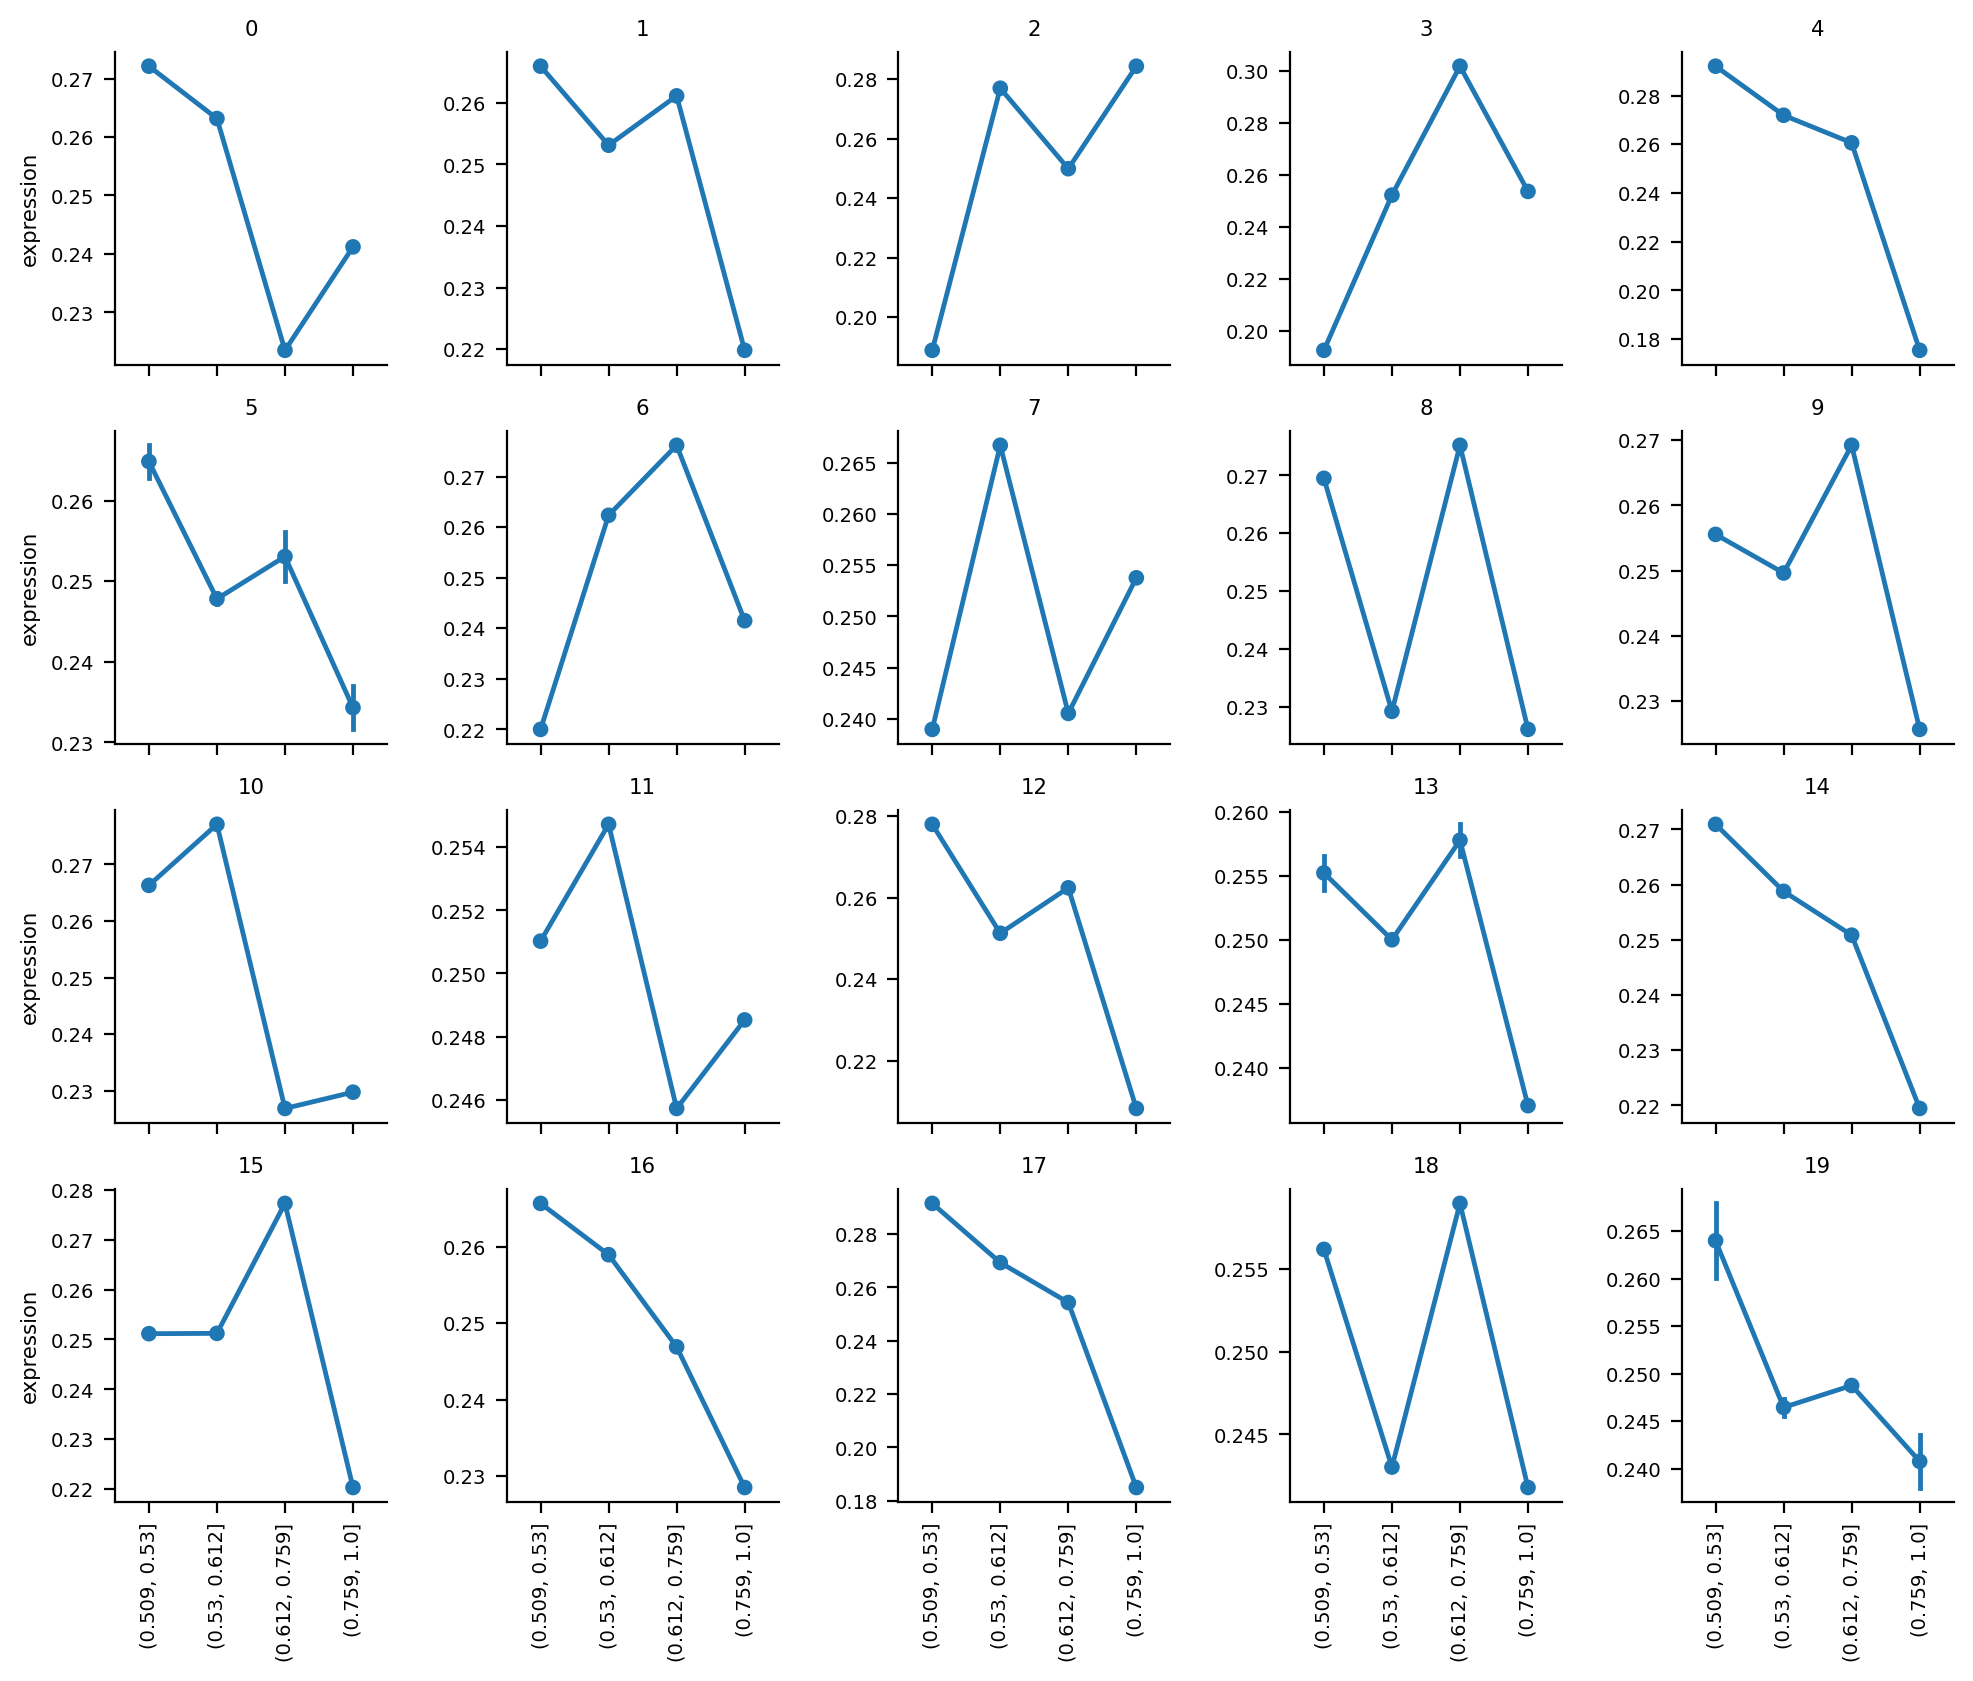

In [84]:
g = sns.FacetGrid(plot_df, col="membership", height=2, col_wrap=5, sharey=False)
g.map(sns.pointplot, 'ptime', 'expression', 
      order=x_ratio_ptime_bins, 
      errorbar='sd')
for ax in g.axes.flat:
    ax.tick_params(axis='x', labelrotation=90)
    ax.set_xlabel(None)
    # ax.set_ylabel('norm_sct')
g.set_titles(col_template="{col_name}", row_template="{row_name}") ;

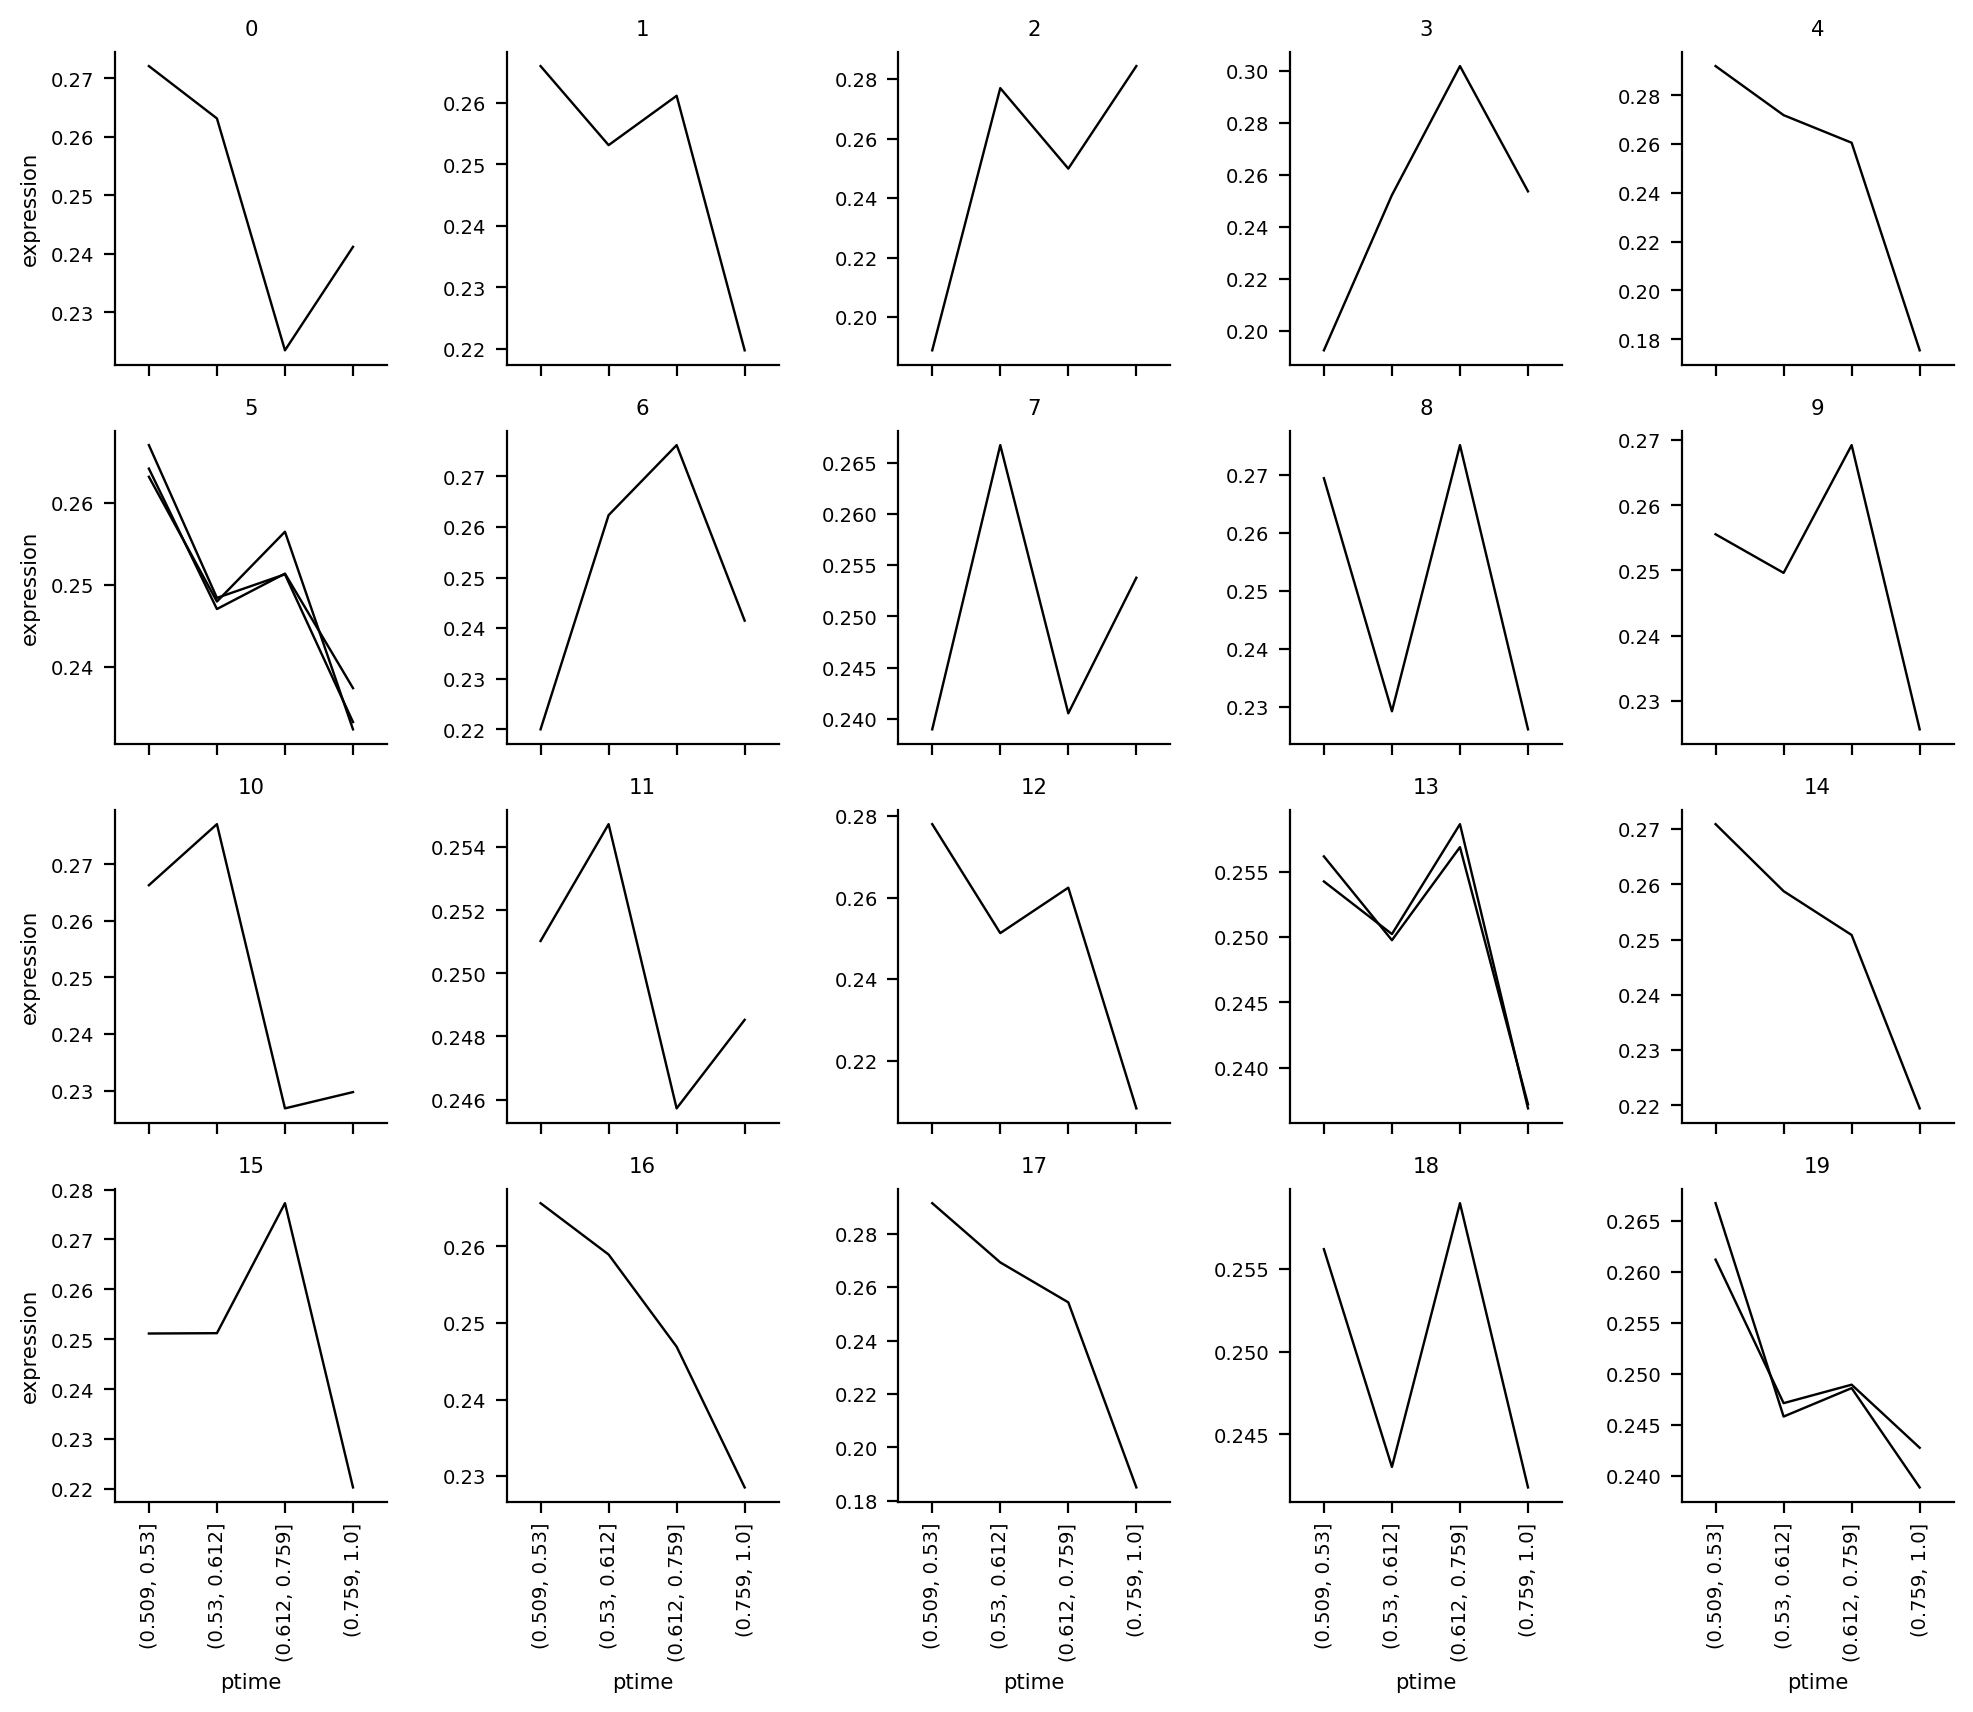

In [85]:
g = sns.FacetGrid(plot_df, col="membership", hue="gene", height=2, col_wrap=5, sharey=False)
g.map(sns.pointplot, 'ptime', 'expression', 
      order=x_ratio_ptime_bins, 
      errorbar=None, scale=0.5, color='black')
for ax in g.axes.flat:
    ax.tick_params(axis='x', labelrotation=90)
    plt.setp(ax.collections, sizes=[0], alpha=1) #for the markers
    plt.setp(ax.lines, alpha=1)       #for the lines    
    #plt.setp(ax.collections, )
g.set_titles(col_template="{col_name}", row_template="{row_name}") ;

In [86]:
for i in range(20):
    print(f'{i}:\t', ' '.join(plot_df.loc[plot_df.membership == i].gene.unique().tolist()))

0:	 LOC105373313
1:	 PDK3
2:	 LOC105373184
3:	 SRPX2
4:	 PPEF1
5:	 HUWE1 OCRL PRICKLE3
6:	 IQSEC2
7:	 LL0XNC01-250H12.3
8:	 CDKL5
9:	 IGBP1
10:	 HTR2C
11:	 RPGR
12:	 PRDX4
13:	 HDAC6 PHF8
14:	 UPF3B
15:	 PABIR3
16:	 SYP
17:	 AFF2
18:	 FHL1
19:	 DIAPH2 EIF1AX


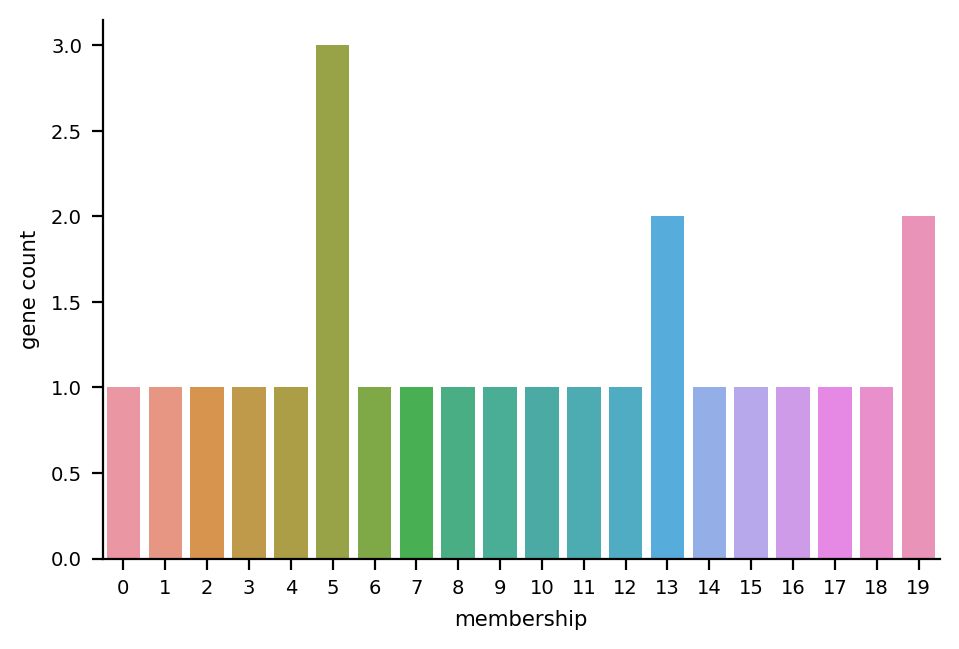

In [87]:
df = plot_df.membership.value_counts() / plot_df.ptime.unique().size
df.index.name = 'membership'
all_genes_bar_plot_df =  df.to_frame('counts').sort_values('membership').reset_index()

ax = sns.barplot(x="membership", y="counts", data=all_genes_bar_plot_df)
ax.set_ylabel('gene count')
sns.despine()

In [88]:
# hexcolors = sns.color_palette().as_hex()
# def _color_red_or_green(val):
#     color = hexcolors[val]
#     return 'background: %s' % color

# diff_exp_genes_with_pred.style.applymap(_color_red_or_green, subset=['membership'])

# Interesting mitochondria genes

In [89]:
# df = means_fine_df.loc[:, ['membership']] 
# df['chromosome'] = adata.var.chromosome[df.index]
# l = df.loc[(df.chromosome == 'MT') & (df.membership.isin([3, 4, 5]))].index.values.tolist()
# gi.gene_info(l)

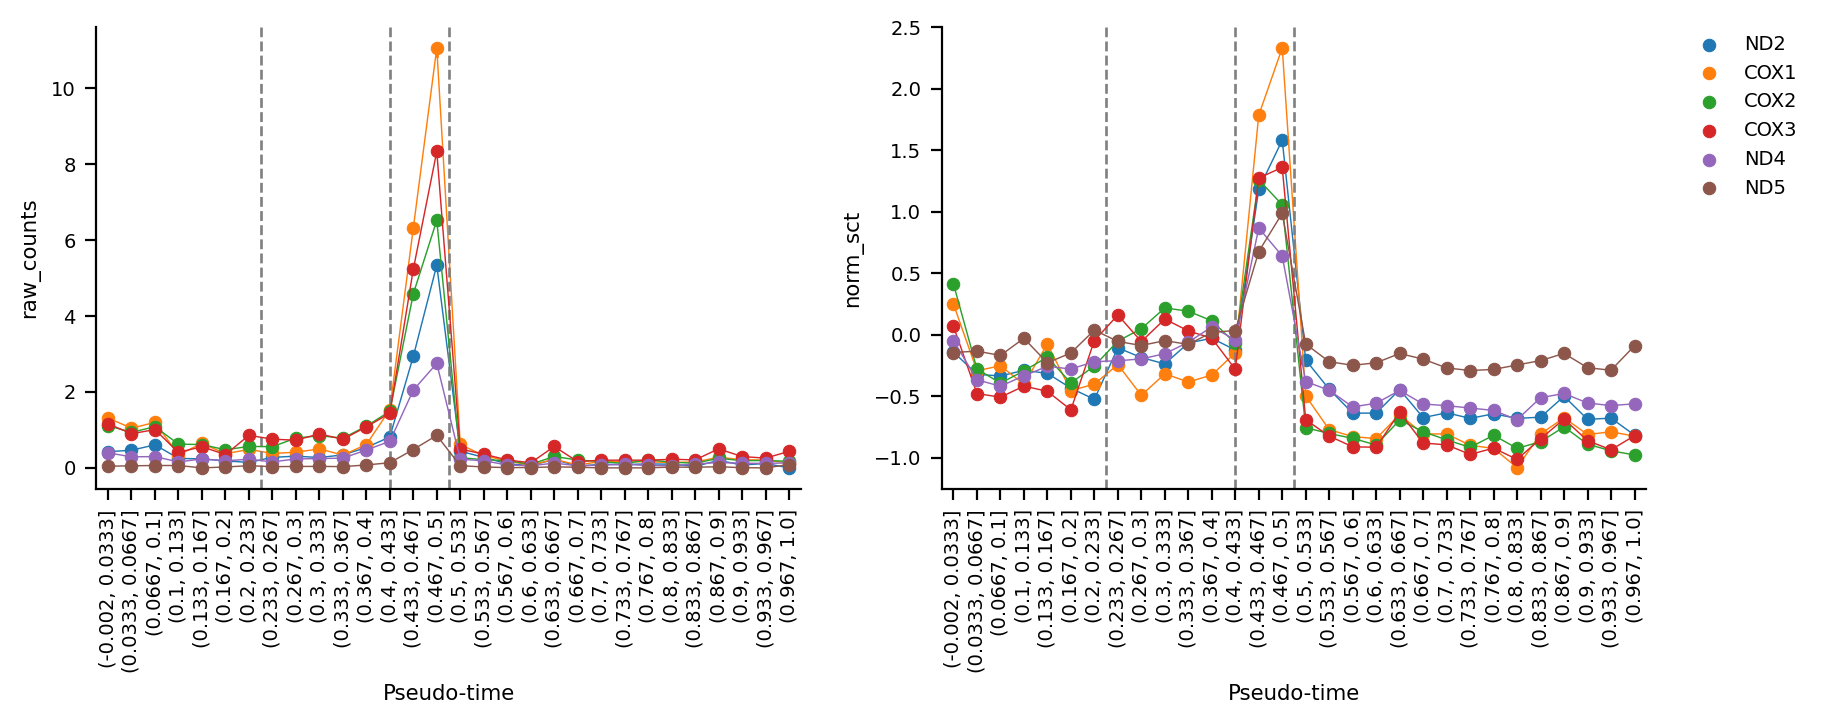

In [90]:
ep.trajectory(['ND2', 'COX1', 'COX2', 'COX3', 'ND4', 'ND5']) ;

missing: ['MIR4421', 'MIR6500', 'TTC39A-AS1']
missing: ['MIR4421', 'MIR6500', 'TTC39A-AS1']


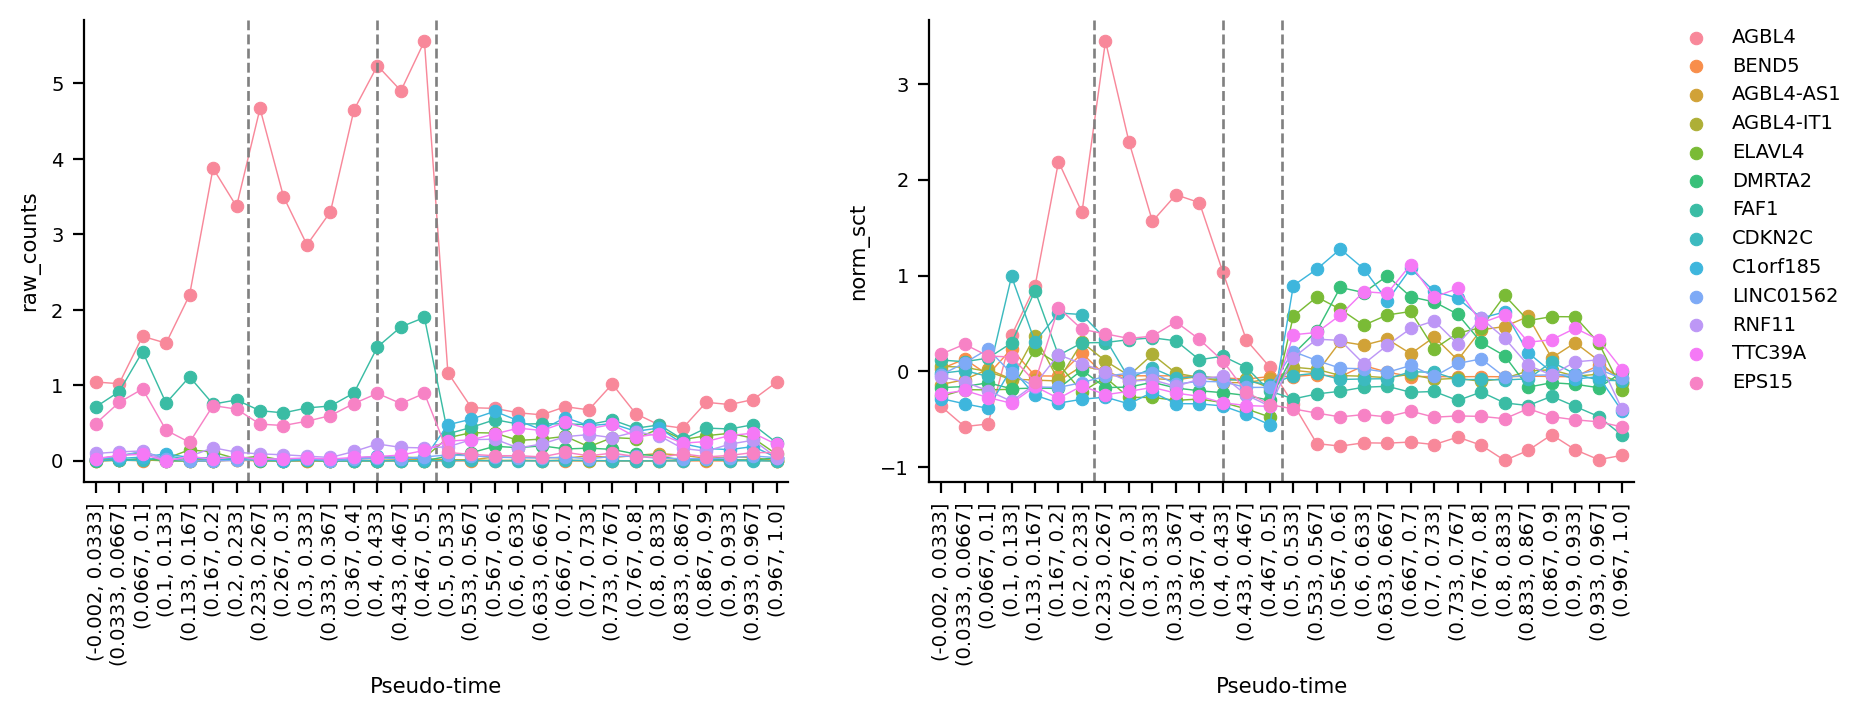

In [91]:
ep.trajectory(
    gi.get_genes_region_dataframe('chr1', 49000000, 52000000, assembly='hg19').name.unique().tolist()
    ) ;

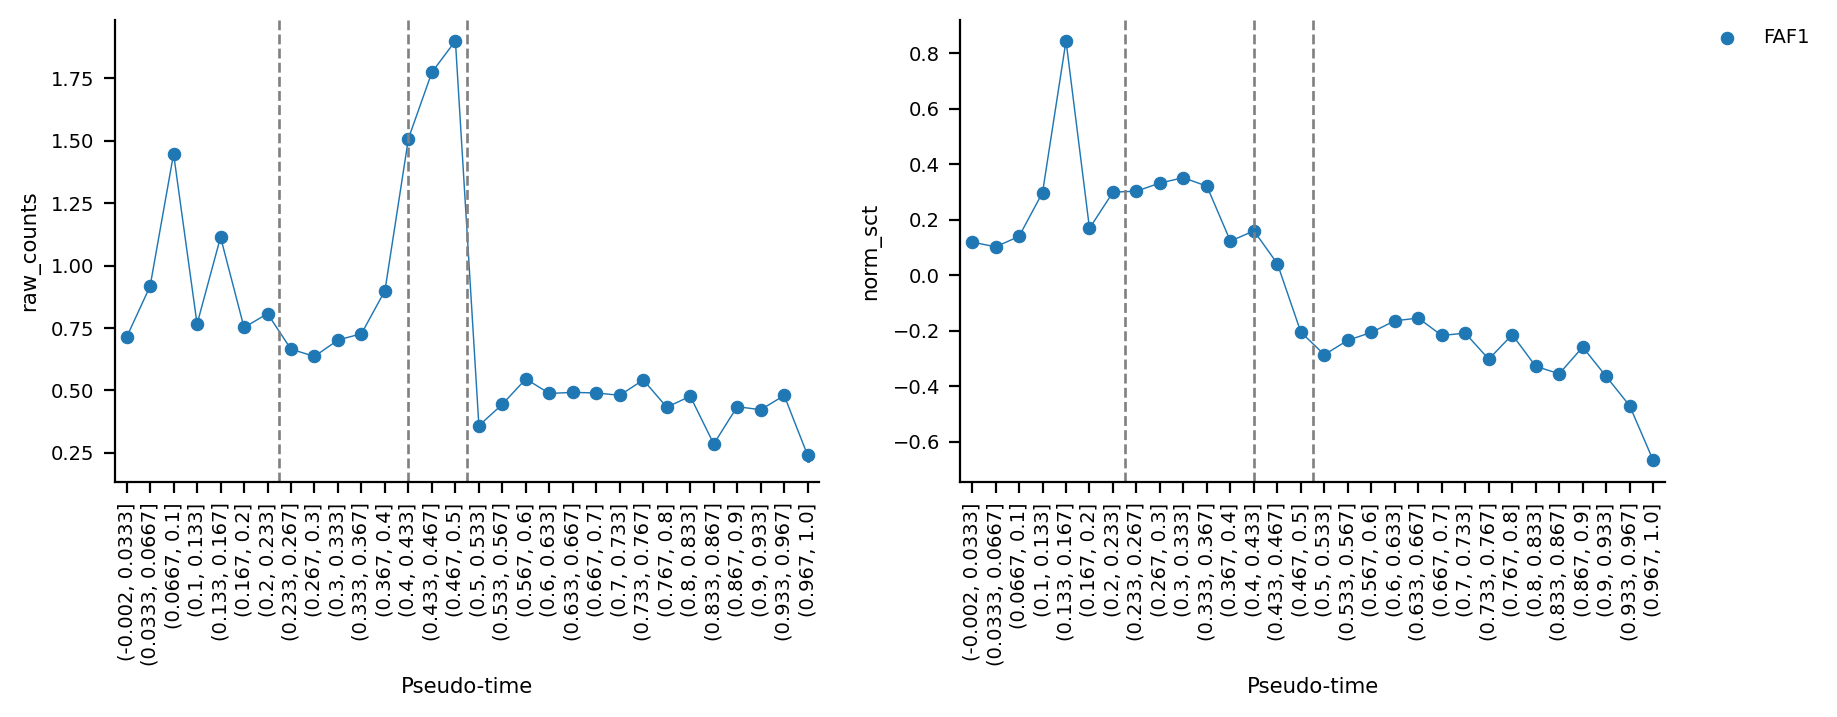

In [92]:
ep.trajectory('FAF1') ;

# Diff exp genes

In [ ]:
diff_exp_genes = pd.read_csv('DEG_XY_spermatids_filtered_pval1_fc2.tsv', 
                             sep='\t', names=['gene', 'pval', 'logfold', '??'])
diff_exp_genes.head()

In [ ]:
gene_has_data = means_df.index.isin(diff_exp_genes.gene)

prediction = kmeans.predict(means_df.loc[gene_has_data, clusters].values)

df = means_df.reset_index()
prediction_df = pd.DataFrame(dict(gene=df.loc[gene_has_data, 'gene'], membership=prediction))
prediction_df.head()

diff_exp_genes_with_pred = diff_exp_genes.merge(prediction_df, on='gene')

In [ ]:
plot_df = means_df.loc[gene_has_data].melt(id_vars=['membership']).groupby('membership').variable.count().reset_index()
plot_df['membership'] = plot_df.membership.astype("category")
plot_df['membership'] = plot_df['membership'].cat.set_categories(membership_labels)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax = sns.barplot(x="membership", y="variable", data=plot_df, order=membership_labels, ax=ax1)
ax.set_ylabel('gene count')
ax.set_title('Diff exp')
sns.despine()

ax = sns.barplot(x="membership", y="counts", data=all_genes_bar_plot_df, ax=ax2)
ax.set_ylabel('gene count')
ax.set_title('All')
sns.despine()

In [ ]:
hexcolors = sns.color_palette().as_hex()
def _color_red_or_green(val):
    color = hexcolors[val]
    return 'background: %s' % color

diff_exp_genes_with_pred.style.applymap(_color_red_or_green, subset=['membership'])

## CodeML signif genes

In [ ]:
codeml_tessa.pval.max()

In [ ]:
codeml_tessa.loc[codeml_tessa.name == 'DYNLT3']

In [ ]:
codeml_tessa.loc[codeml_tessa.name == 'BUB3']

In [ ]:
genes_with_expr_data = codeml_tessa.loc[codeml_tessa.name.isin(means_df.index)].name

In [ ]:
plot_df = means_df.loc[genes_with_expr_data].groupby('membership').membership.count().to_frame('counts').reset_index()

In [ ]:
# plot_df = means_df.loc[genes_with_expr_data].melt(id_vars=['membership'])
# plot_df.head()

In [ ]:
# plot_df['membership'] = plot_df.membership.astype("category")
# plot_df['membership'].cat.set_categories(membership_labels)
# cluster_members = plot_df.groupby('membership').variable.count().reset_index()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

ax = sns.barplot(x="membership", y="counts", data=plot_df, order=membership_labels, ax=ax1)
ax.set_ylabel('gene count')
ax.set_title('Codeml')
sns.despine()

ax = sns.barplot(x="membership", y="counts", data=all_genes_bar_plot_df, ax=ax2)
ax.set_ylabel('gene count')
ax.set_title('All')
sns.despine()

#  Hand-picked contenders in swept regions on X

In [ ]:
candidate_genes = pd.read_hdf('candidate_genes.hdf')
genes = candidate_genes.loc[candidate_genes.name.isin(means_df.index)].name

plot_df = means_df.loc[genes].groupby('membership').membership.count().to_frame('counts').reset_index()

ax = sns.barplot(x="membership", y="counts", data=plot_df, order=membership_labels)
ax.set_ylabel('gene count')
sns.despine()

# Genes on X that turn on in spermatids

In [ ]:
df = (means_df
      .loc[x_genes]
      .loc[lambda df: df.membership.isin([2, 4])]
      .reset_index()
      .sort_values(by='gene')
     )
print(df.index.size)

def _color_membership(val):
    return f'background: {hexcolors[val]}'

def _color_candidates(val):
    # print(val, val in candidate_genes.name)
    if val in candidate_genes.name.to_list():
        color = "#FFC0CB50"
    else:
        color = 'none'
    return f'background: {color}'

with pd.option_context("display.max_rows", 1000):
    display(df.style.applymap(_color_membership, subset=['membership']).applymap(_color_candidates, subset=['gene']))

In [ ]:
df = (means_df
      .loc[~means_df.index.isin(x_genes)]
      .loc[lambda df: df.membership.isin([2, 4])]
      .reset_index()
      .sort_values(by='gene')
     )
print(df.index.size)

# Genes on X with pachytene peak

In [ ]:
df = (means_df
      .loc[x_genes]
      .loc[lambda df: df.membership.isin([1, 3])]
      .reset_index()
      .sort_values(by='gene')
     )
print(df.index.size)
def _color_membership(val):
    return f'background: {hexcolors[val]}'

def _color_candidates(val):
    # print(val, val in candidate_genes.name)
    if val in candidate_genes.name.to_list():
        color = "#FFC0CB50"
    else:
        color = 'none'
    return f'background: {color}'

with pd.option_context("display.max_rows", 1000):
    display(df.style.applymap(_color_membership, subset=['membership']).applymap(_color_candidates, subset=['gene']))

In [ ]:
expr_plot(df.gene, 'raw_counts') ;

In [ ]:
gi.gene_info(df.gene)

# Non-X genes on X with pachytene peak

In [ ]:
df = (means_df
      .loc[~means_df.index.isin(x_genes)]
      .loc[lambda df: df.membership.isin([1, 3])]
      .reset_index()
      .sort_values(by='gene')
     )
print(df.index.size)

In [ ]:
2 / 3156 * 100, 150/3000 * 100

# See if non-X genes are enriched for brain stuff...

In [ ]:
df.gene

In [ ]:
symbol2ncbi_file = f'geneinfo_cache/{9606}_symbol2ncbi.h5'
symbol2ncbi = pd.read_hdf(symbol2ncbi_file, 'ncbi2symbol')
protein_coding = symbol2ncbi.tolist()

In [ ]:
import importlib
import geneinfo
importlib.reload(geneinfo)

print(df.gene.index.size)
go_results = gi.go_enrichment(df.gene.loc[df.gene.isin(protein_coding)], list_study_genes=True)
go_results

In [ ]:
go_results.term_id == 'GO:0007339'

In [ ]:
gi.go_info(go_results.term_id)

In [ ]:
go_results.loc[go_results.term_id == 'GO:0034587'].study_genes

In [ ]:
gi.gene_info(go_results.loc[go_results.term_id == 'GO:0034587'].study_genes)

In [ ]:
ax = expr_plot(go_results.iloc[0].study_genes, 'raw_counts') ;
h,l = ax.axes.get_legend_handles_labels()
ax.legend_.remove()
ax.legend(h,l, ncol=4, bbox_to_anchor=(1.1, 1.05), frameon=False)
#sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), frameon=False)

In [ ]:
ax = expr_plot(['ATR', 'H2AX', 'GALNT3', 'IHO1', 'GK2', 'GPX4'], 'raw_counts') ;

In [ ]:
gi.gene_info('GPX4')

In [ ]:
means_df.loc[means_df.index.intersection(grove_2019)]

In [ ]:
all_genes = set()
for gene_set in go_results.study_genes:
    all_genes.update(gene_set)
print(len(all_genes))

In [ ]:
'PTBP2' in all_genes

In [ ]:
set(all_genes).intersection(set(grove_2019))

In [ ]:
set(all_genes).intersection(set(sfari_genes))

In [ ]:
set(all_genes).intersection(set(codeml_tessa))

In [ ]:
gi.show_go_dag_for_terms(go_results.term_id)

In [ ]:
gi.go_info(go_results.term_id)

# Hmm... 

Only 0.06% of pathytene peak genes are on X although the X is 5% of genome.... And both associated with intelectual disability...

In [ ]:
gi.gene_info('DYNLT3')

In [ ]:
cat_plot(df.gene, 'raw_counts') ;

In [ ]:
#gi.geneinfo(df.gene.to_list())

# Genes in chr3 region

In [ ]:
# %env ftp_proxy http://proxyserv:3128
# %env http_proxy http://proxyserv:3128
# %env https_proxy http://proxyserv:3128

In [ ]:
chr3region_genes = adata.var.loc[adata.var.chromosome == '3', 'gene_ids']
chr3region_genes = chr3region_genes[~chr3region_genes.isnull()]

chr3region_genes = pd.Series([record[0] for record in gi.get_genes_region('chr3', 47000000, 53000000, assembly='hg38')])
chr3region_genes = chr3region_genes.loc[chr3region_genes.isin(means_df.index)]

In [ ]:
df = (means_df
      .loc[chr3region_genes.unique()]
      .loc[lambda df: df.membership.isin([1, 3])]
      .reset_index()
      .sort_values(by='gene')
     )
with pd.option_context("display.max_rows", 1000):
    display(df)

In [ ]:
cat_plot(df.gene, 'raw_counts') ;

In [ ]:
cat_plot(['NDUFAF3'], 'raw_counts') ;

In [ ]:
df = (means_df
      .loc[chr3region_genes]
      .loc[lambda df: df.membership.isin([9, 1])]
      .reset_index()
      .sort_values(by='gene')
     )
with pd.option_context("display.max_rows", 1000):
    display(df)

In [ ]:
cat_plot(df.gene, 'raw_counts')

In [ ]:
df = (means_df
      .loc[lambda df: df.membership.isin([1, 9])]
      .reset_index()
      .sort_values(by='gene')
     )

def _color_membership(val):
    return f'background: {hexcolors[val]}'

def _color_candidates(val):
    # print(val, val in candidate_genes.name)
    if val in candidate_genes.name.to_list():
        color = "#FFC0CB50"
    else:
        color = 'none'
    return f'background: {color}'


with pd.option_context("display.max_rows", 1000):
    display(df.style.applymap(_color_membership, subset=['membership']).applymap(_color_candidates, subset=['gene']))
   